Hard Drive Failure Prediction Masters Thesis
========================================
This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`

TODO: make sure the models are always saved in the correct folder on root/models

Index

1. [Thesis Overview](#thesis)
2. [Setup](#setup)
3. [Feature Selection & Correlation Analysis](#generate-a-correlation-matrix-to-see-the-best-features-to-use)
4. [Preprocessing Data](#preprocess-data)
5. [Missing Value Imputation](#missing-value-imputation)
6. [Categorical Variable Encoding](#categorical-variable-encoding)
7. [Ordinal Encoding of Capacity](#ordinal-encoding-of-capacity-capacity_bytes)
8. [Model Training and Evaluation](#step-2-load-the-data-to-train-the-models)
    - [LSTM Model](#step-3-train-the-lstm-model)
    - [Decision Tree Model](#step-4-train-and-test-the-decision-tree-ct-on-raw-data)
9. [Predictions and Visualization](#step-4-generate-predictions)
10. [Pipeline: LSTM + Decision Tree](#now-we-will-predict-a-hard-drive-with-the-lstm-and-consume-it-and-classify-the-prediction-result-with-the-ct)

In [299]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime
from sklearn.metrics import classification_report
import random
from joblib import load
import seaborn as sns
from feature_engine.imputation import RandomSampleImputer

# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net


## Setup

Set the variables for the data paths and the features to be used in the models.

In [483]:
post_proc_data_path = "../data/"
ct_data_path = "../data/a_test/processed_data"
lstm_data_path = "../data/a_test/processed_data"
days_to_train = 5
days_to_predict = 1
verbose = True

# Correlation matrix parameters
n_features = 10 # Number of features to select based on correlation

#LSTM parameters
num_features = 10 # For default SMART data, this should match the number of features in your dataset
n_neurons = 4
num_epochs = 1500
learning_rate = 0.01

lstm_param_grid = {
    'n_neurons': [4, 8, 16, 32],
    'learning_rate': [0.001, 0.003, 0.005, 0.01],
    'batch_size': [2, 4, 8, 16]
}

#CT parameters
ct_depth = 100
ct_leaf = 15

ct_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
}

In [301]:

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Feature Selection
Generate a correlation matrix to see the best features to use.

In [302]:
# Load data for correlation analysis
ct_raw_data = CT.importdata(post_proc_data_path, columns_to_delete=[])
preprocessing_df = ct_raw_data.copy()


Processing subfolders:  30%|███       | 3/10 [00:03<00:07,  1.06s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [363]:
ct_raw_data.drop(columns=['date','serial_number','model','capacity_bytes','datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format',], inplace=True, errors='ignore')

In [364]:
ct_raw_data.drop(columns=[col for col in ct_raw_data.columns if col.startswith('smart_') and col.endswith('_raw')], inplace=True, errors='ignore')

In [365]:
print("Columns in ct_raw_data:", ct_raw_data.columns.tolist())


Columns in ct_raw_data: ['failure', 'smart_1_normalized', 'smart_2_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized', 'smart_7_normalized', 'smart_8_normalized', 'smart_9_normalized', 'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized', 'smart_13_normalized', 'smart_15_normalized', 'smart_16_normalized', 'smart_17_normalized', 'smart_18_normalized', 'smart_22_normalized', 'smart_23_normalized', 'smart_24_normalized', 'smart_27_normalized', 'smart_71_normalized', 'smart_82_normalized', 'smart_90_normalized', 'smart_160_normalized', 'smart_161_normalized', 'smart_163_normalized', 'smart_164_normalized', 'smart_165_normalized', 'smart_166_normalized', 'smart_167_normalized', 'smart_168_normalized', 'smart_169_normalized', 'smart_170_normalized', 'smart_171_normalized', 'smart_172_normalized', 'smart_173_normalized', 'smart_174_normalized', 'smart_175_normalized', 'smart_176_normalized', 'smart_177_normalized', 'smart_178_normalized', 'smart_179_

In [366]:
# Compute correlation matrix for all numeric columns
correlation_matrix = ct_raw_data.corr()

# Get absolute correlation with 'failure' and sort descending (excluding 'failure' itself)
feature_corr = correlation_matrix['failure'].abs().drop('failure').sort_values(ascending=False)

# Get all features with nonzero correlation to failure
best_features = feature_corr[feature_corr > 0].index.tolist()

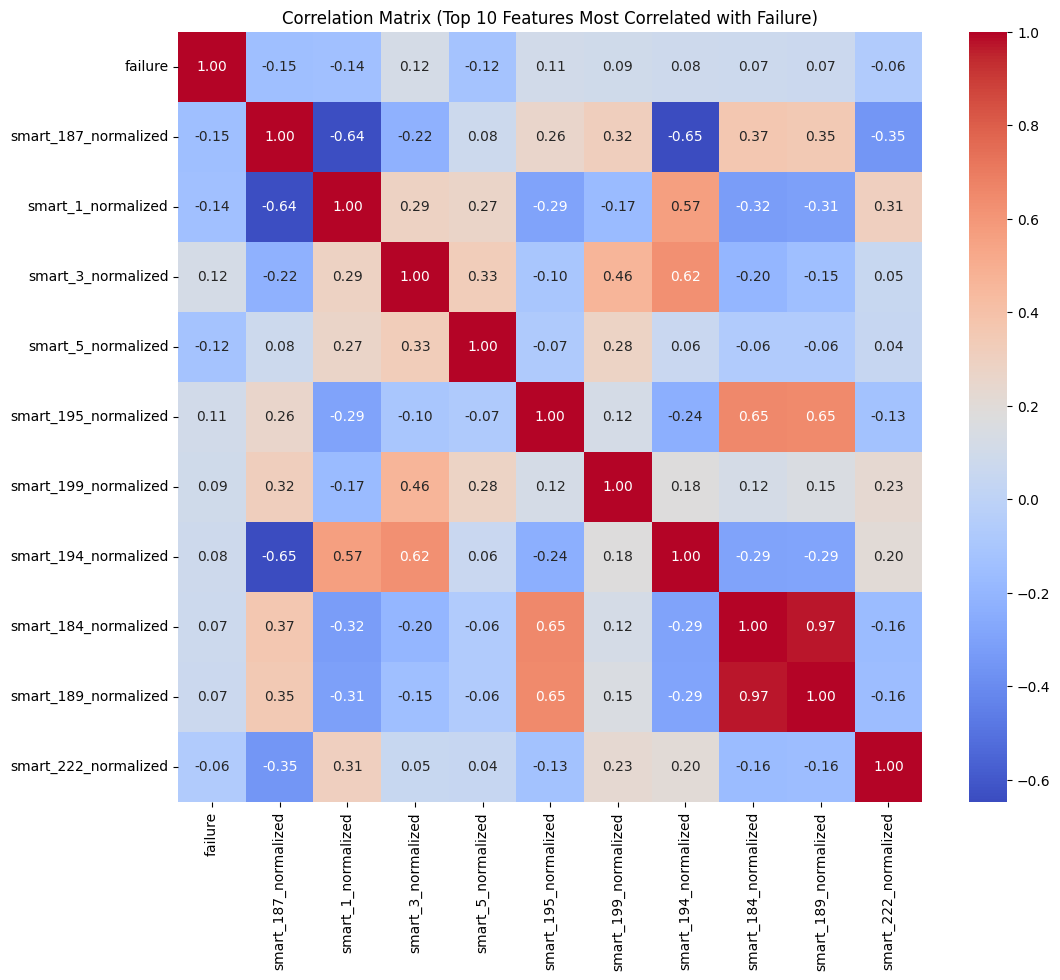

In [367]:


# Plot the correlation matrix for the top 15 features most correlated with failure
top_n = 10
top_corr_features = feature_corr.head(top_n).index.tolist()
corr_subset = correlation_matrix.loc[['failure'] + top_corr_features, ['failure'] + top_corr_features]

plt.figure(figsize=(12, 10))
plt.title(f"Correlation Matrix (Top {top_n} Features Most Correlated with Failure)")
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [368]:
# Print features and their correlation values
print("Best features by correlation with failure:")


for feature in best_features[:n_features]:
    print(f"{feature}: {feature_corr[feature]:.4f}")
normalized_rows = [int(feature.split('_')[1]) for feature in best_features[:n_features] if 'normalized' in feature]

Best features by correlation with failure:
smart_187_normalized: 0.1453
smart_1_normalized: 0.1413
smart_3_normalized: 0.1220
smart_5_normalized: 0.1215
smart_195_normalized: 0.1057
smart_199_normalized: 0.0935
smart_194_normalized: 0.0819
smart_184_normalized: 0.0745
smart_189_normalized: 0.0736
smart_222_normalized: 0.0623


In [369]:
# We are only going to use normalized features for the LSTM model performance
print(f"Top {top_n} normalized features: ", normalized_rows)

# Changinge the number of features used based on correlation analysis results
num_features = len(normalized_rows)
print(f"Total number of features used: {num_features}")

Top 10 normalized features:  [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Total number of features used: 10


## Preprocess data

In [370]:
columns_to_delete = [
    # Remove normalized and raw features in normalized_rows and raw_rows from columns_to_delete
    'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format',
    'smart_1_normalized','smart_1_raw','smart_2_normalized','smart_2_raw','smart_3_normalized','smart_3_raw',
    'smart_4_normalized','smart_4_raw','smart_5_normalized','smart_5_raw','smart_7_normalized','smart_7_raw',
    'smart_8_normalized','smart_8_raw','smart_9_normalized','smart_9_raw','smart_10_normalized','smart_10_raw',
    'smart_11_normalized','smart_11_raw','smart_12_normalized','smart_12_raw','smart_13_normalized','smart_13_raw',
    'smart_15_normalized','smart_15_raw','smart_16_normalized','smart_16_raw','smart_17_normalized','smart_17_raw',
    'smart_18_normalized','smart_18_raw','smart_22_normalized','smart_22_raw','smart_23_normalized','smart_23_raw',
    'smart_24_normalized','smart_24_raw','smart_160_normalized','smart_160_raw','smart_161_normalized','smart_161_raw',
    'smart_163_normalized','smart_163_raw','smart_164_normalized','smart_164_raw','smart_165_normalized','smart_165_raw',
    'smart_166_normalized','smart_166_raw','smart_167_normalized','smart_167_raw','smart_168_normalized','smart_168_raw',
    'smart_169_normalized','smart_169_raw','smart_170_normalized','smart_170_raw','smart_171_normalized','smart_171_raw',
    'smart_172_normalized','smart_172_raw','smart_173_normalized','smart_173_raw','smart_174_normalized','smart_174_raw',
    'smart_175_normalized','smart_175_raw','smart_176_normalized','smart_176_raw','smart_177_normalized','smart_177_raw',
    'smart_178_normalized','smart_178_raw','smart_179_normalized','smart_179_raw','smart_180_normalized','smart_180_raw',
    'smart_181_normalized','smart_181_raw','smart_182_normalized','smart_182_raw','smart_183_normalized','smart_183_raw',
    'smart_184_normalized','smart_184_raw','smart_187_normalized','smart_187_raw','smart_188_normalized','smart_188_raw',
    'smart_189_normalized','smart_189_raw','smart_190_normalized','smart_190_raw','smart_191_normalized','smart_191_raw',
    'smart_192_normalized','smart_192_raw','smart_193_normalized','smart_193_raw','smart_194_normalized','smart_194_raw',
    'smart_195_normalized','smart_195_raw','smart_196_normalized','smart_196_raw','smart_197_normalized','smart_197_raw',
    'smart_198_normalized','smart_198_raw','smart_199_normalized','smart_199_raw','smart_200_normalized','smart_200_raw',
    'smart_201_normalized','smart_201_raw','smart_202_normalized','smart_202_raw','smart_206_normalized','smart_206_raw',
    'smart_210_normalized','smart_210_raw','smart_218_normalized','smart_218_raw','smart_220_normalized','smart_220_raw',
    'smart_222_normalized','smart_222_raw','smart_223_normalized','smart_223_raw','smart_224_normalized','smart_224_raw',
    'smart_225_normalized','smart_225_raw','smart_226_normalized','smart_226_raw','smart_230_normalized','smart_230_raw',
    'smart_231_normalized','smart_231_raw','smart_232_normalized','smart_232_raw','smart_233_normalized','smart_233_raw',
    'smart_234_normalized','smart_234_raw','smart_235_normalized','smart_235_raw','smart_240_normalized','smart_240_raw',
    'smart_241_normalized','smart_241_raw','smart_242_normalized','smart_242_raw','smart_244_normalized','smart_244_raw',
    'smart_245_normalized','smart_245_raw','smart_246_normalized','smart_246_raw','smart_247_normalized','smart_247_raw',
    'smart_248_normalized','smart_248_raw','smart_250_normalized','smart_250_raw','smart_251_normalized','smart_251_raw',
    'smart_252_normalized','smart_252_raw','smart_254_normalized','smart_254_raw','smart_255_normalized','smart_255_raw'
]

for n in normalized_rows:
    columns_to_delete.remove(f"smart_{n}_normalized")
df = preprocessing_df.drop(columns=columns_to_delete, errors='ignore')

In [371]:
df

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_27_normalized,smart_27_raw,...,smart_187_normalized,smart_189_normalized,smart_194_normalized,smart_195_normalized,smart_199_normalized,smart_211_normalized,smart_211_raw,smart_212_normalized,smart_212_raw,smart_222_normalized
244236,2025-01-01,8180A0ZCFVKG,TOSHIBA MG08ACA16TA,-2147483648,False,100.0,100.0,100.0,0.0,0.0,...,0.0,0.0,100.0,0.0,200.0,0.0,0.0,0.0,0.0,45.0
299107,2025-01-01,1PGY8TJY,WDC WUH722222ALE6L4,-2147483648,False,100.0,84.0,100.0,0.0,0.0,...,0.0,0.0,70.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
106180,2025-01-01,QBGUP2JT,WDC WUH721414ALE6L4,-1073741824,False,100.0,95.0,100.0,0.0,0.0,...,0.0,0.0,68.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
78820,2025-01-01,ZL2P83JJ,ST16000NM001G,-2147483648,False,84.0,93.0,100.0,0.0,0.0,...,100.0,0.0,26.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0
177056,2025-01-01,61A0A0NBF97G,TOSHIBA MG07ACA14TA,-1073741824,False,100.0,100.0,100.0,0.0,0.0,...,0.0,0.0,100.0,0.0,200.0,0.0,0.0,0.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104206,2024-12-30,AAH5X34H,HGST HUH721212ALN604,0,False,100.0,158.0,100.0,0.0,0.0,...,0.0,0.0,176.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0
84092,2024-12-30,8HH7KZ7H,HGST HUH721212ALE604,0,False,100.0,100.0,100.0,0.0,0.0,...,0.0,0.0,157.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0
101531,2024-12-30,AAG771AH,HGST HUH721212ALN604,0,False,100.0,100.0,100.0,0.0,0.0,...,0.0,0.0,193.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0
79967,2024-12-30,ZL0051G9,ST12000NM0008,0,False,84.0,90.0,100.0,0.0,0.0,...,100.0,0.0,30.0,2.0,200.0,0.0,0.0,0.0,0.0,0.0


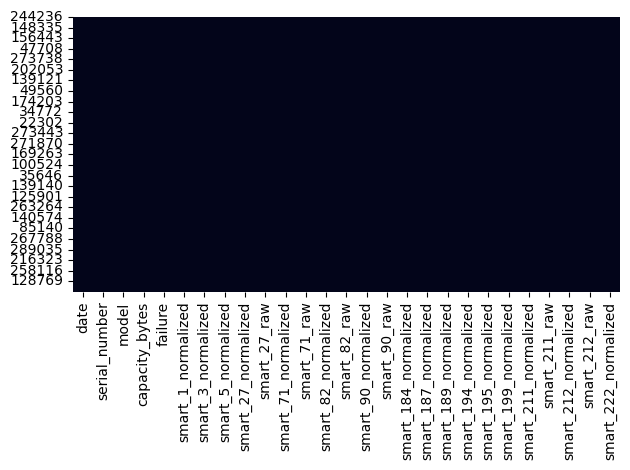

In [372]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
# plt.savefig(f'../reports/figures/heat_maps/heat_map_.png')
plt.close()

Now we will remove columns that only contain missing data.

In [373]:
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only NaN values: {nan_columns}")

df = df.drop(columns=nan_columns)

Columns with only NaN values: []


We print the columns and the most frequently occurring elements to get an idea of what we will do with the different data.

In [374]:
for column in df.columns:
    print(f"Column: {column}")
    print(f"Top 3 most occurring elements: {df[column].value_counts().head(3).to_dict().keys()}")
    print(f"Number of NaN values: {df[column].isna().sum()}")
    print("\n")

Column: date
Top 3 most occurring elements: dict_keys(['2024-08-01', '2024-05-31', '2024-08-09'])
Number of NaN values: 0


Column: serial_number
Top 3 most occurring elements: dict_keys(['Z305GW45', 'Z305KVPX', 'PL2331LAHD806J'])
Number of NaN values: 0


Column: model
Top 3 most occurring elements: dict_keys(['TOSHIBA MG08ACA16TA', 'TOSHIBA MG07ACA14TA', 'ST16000NM001G'])
Number of NaN values: 0


Column: capacity_bytes
Top 3 most occurring elements: dict_keys([-2147483648, 0, -1073741824])
Number of NaN values: 0


Column: failure
Top 3 most occurring elements: dict_keys([False, True])
Number of NaN values: 0


Column: smart_1_normalized
Top 3 most occurring elements: dict_keys([100.0, 83.0, 82.0])
Number of NaN values: 0


Column: smart_3_normalized
Top 3 most occurring elements: dict_keys([100.0, 90.0, 84.0])
Number of NaN values: 0


Column: smart_5_normalized
Top 3 most occurring elements: dict_keys([100.0, 0.0, 99.0])
Number of NaN values: 0


Column: smart_27_normalized
Top 3 

We can see that columns with categorical variables have no missing variables. We will only work on replacing missing data with numerical variables that belong to S.M.A.R.T attributes, both normalized and raw.

In [375]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column: {column}, NaN values: {nan_count}")

### Missing Value Imputation
----------
Mode is used to impute qualitative predictors (categorical variables), and the mean or median is used to impute quantitative predictors (numerical variables).


### Categorical variables

Categorical variables with NaN elements in the dataset: none

In [376]:
nan_counts = df.iloc[:, :5].isna().sum()
print(nan_counts)

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
dtype: int64


### Numerical variables
We evaluate the distribution:

In a uniform distribution, the method to be used should be random substitution; on the other hand, if the distribution is similar to normal, i.e., symmetric and kurtosis greater than -1.0, if the variable shows outliers, median substitution is applied, since this measure of central tendency does not vary in the presence of such values; otherwise, arithmetic mean substitution is used.

In [377]:
output_dir = '../reports/figures/histogramas/'
os.makedirs(output_dir, exist_ok=True)

# Crear histogramas para las columnas 6 en adelante
for column in df.columns[5:]:
    plt.figure(figsize=(10, 6))
    df[column].dropna().hist(bins=50)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.savefig(f'{output_dir}{column}_histograma.png')
    plt.close()

Random substitution (Kurtosis less than -1.0 and uniform distribution)

Columnas con kurtosis menor a -1.0: ['smart_187_normalized']


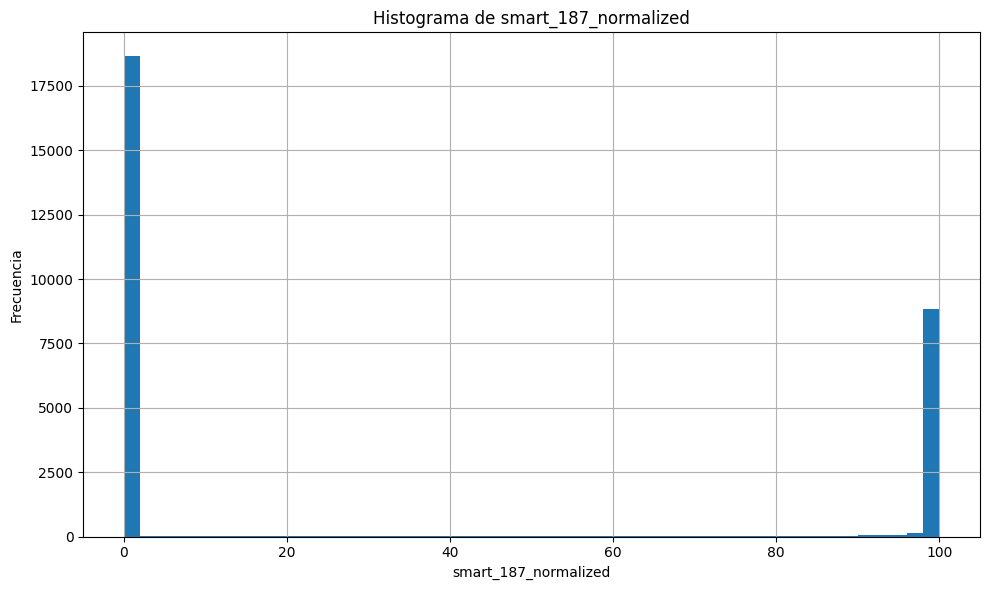

In [378]:
df_smart = df.iloc[:, 5:]
kurtosis_columns = [col for col in df_smart.columns if df_smart[col].kurtosis() < -1.0]
print(f"Columnas con kurtosis menor a -1.0: {kurtosis_columns}")
# Plot the column with kurtosis less than -1.0
for col in kurtosis_columns:
    plt.figure(figsize=(10, 6))
    df[col].dropna().hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.savefig(f'../reports/figures/histogramas/{col}_histograma.png')
    plt.tight_layout()
    plt.show()
    plt.close()


### Search for outliers

With the IQR we see which columns have anomalies and save them in a dictionary

In [379]:
# Calcular el rango intercuartílico (IQR) para las columnas 6 en adelante
iqr_values = {}
outliers_dict = {}
no_kurtosis_df = df.drop(columns=kurtosis_columns)
for column in no_kurtosis_df.columns[5:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = IQR
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {column}: {outliers.shape[0]}")
    if not outliers.empty:
        outliers_dict[column] = outliers

Outliers in column smart_1_normalized: 402
Outliers in column smart_3_normalized: 2635
Outliers in column smart_5_normalized: 1175
Outliers in column smart_27_normalized: 279
Outliers in column smart_27_raw: 279
Outliers in column smart_71_normalized: 1707
Outliers in column smart_71_raw: 1
Outliers in column smart_82_normalized: 0
Outliers in column smart_82_raw: 0
Outliers in column smart_90_normalized: 1707
Outliers in column smart_90_raw: 1707
Outliers in column smart_184_normalized: 2865
Outliers in column smart_189_normalized: 2747
Outliers in column smart_194_normalized: 1060
Outliers in column smart_195_normalized: 5041
Outliers in column smart_199_normalized: 5345
Outliers in column smart_211_normalized: 1
Outliers in column smart_211_raw: 1
Outliers in column smart_212_normalized: 1
Outliers in column smart_212_raw: 0
Outliers in column smart_222_normalized: 6663


We create the dictionary to substitute null values

In [380]:
valores = {}
for column in df.columns[5:]:
    if column not in kurtosis_columns:
        if column in outliers:
            valores[column] = df[column].median()
        else:
            valores[column] = df[column].mean()

print(valores)

{'smart_1_normalized': np.float64(100.0), 'smart_3_normalized': np.float64(96.0), 'smart_5_normalized': np.float64(100.0), 'smart_27_normalized': np.float64(0.0), 'smart_27_raw': np.float64(0.0), 'smart_71_normalized': np.float64(0.0), 'smart_71_raw': np.float64(0.0), 'smart_82_normalized': np.float64(0.0), 'smart_82_raw': np.float64(0.0), 'smart_90_normalized': np.float64(0.0), 'smart_90_raw': np.float64(0.0), 'smart_184_normalized': np.float64(0.0), 'smart_189_normalized': np.float64(0.0), 'smart_194_normalized': np.float64(63.0), 'smart_195_normalized': np.float64(0.0), 'smart_199_normalized': np.float64(200.0), 'smart_211_normalized': np.float64(0.0), 'smart_211_raw': np.float64(0.0), 'smart_212_normalized': np.float64(0.0), 'smart_212_raw': np.float64(0.0), 'smart_222_normalized': np.float64(0.0)}


In [381]:
df=df.fillna(valores)
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


In [382]:
aleatorio=RandomSampleImputer()
for column in kurtosis_columns:
    df[column]=aleatorio.fit_transform(df[[column]])
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


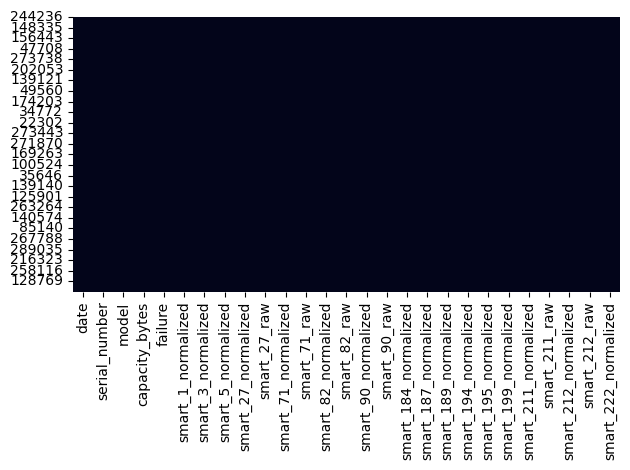

In [383]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.close()

### Categorical Variable Encoding
-------------
[Categorical Variable Encoding](../references/codificacion_var_categoricas.pdf)

Variables that we will convert to a categorical variable:
- model: Will be divided into two variables: Company and model.
- capacity_bytes: We will separate them into different categories depending on the amount of storage


In [384]:
# Calcular la frecuencia de cada modelo
model_freq = df['model'].value_counts()

# Crear un diccionario para mapear cada modelo a su frecuencia
model_freq_dict = model_freq.to_dict()

# Crear una nueva columna categórica basada en la frecuencia de uso
df['model_freq'] = df['model'].map(model_freq_dict)

# Convertir la nueva columna a tipo categórico
df['model_freq'] = pd.cut(df['model_freq'], bins=[0, 10, 100, 1000, 10000, float('inf')],
                          labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(df[['model', 'model_freq']].head())

                      model model_freq
244236  TOSHIBA MG08ACA16TA       Alto
299107  WDC WUH722222ALE6L4       Alto
106180  WDC WUH721414ALE6L4      Medio
78820         ST16000NM001G       Alto
177056  TOSHIBA MG07ACA14TA       Alto


They are divided into brand and model

In [385]:
import re

def extract_brand(model):
    match = re.match(r'^[A-Za-z]+', model)
    return match.group(0) if match else None

df['brand'] = df['model'].apply(extract_brand)
print(df['brand'].drop_duplicates())

244236     TOSHIBA
299107         WDC
78820           ST
25506         HGST
220229    DELLBOSS
186278          CT
140430     Seagate
142865     MTFDDAV
194900          WD
208243         WUH
11454       Micron
Name: brand, dtype: object


In [386]:
print(df.head())

              date serial_number                model  capacity_bytes  \
244236  2025-01-01  8180A0ZCFVKG  TOSHIBA MG08ACA16TA     -2147483648   
299107  2025-01-01      1PGY8TJY  WDC WUH722222ALE6L4     -2147483648   
106180  2025-01-01      QBGUP2JT  WDC WUH721414ALE6L4     -1073741824   
78820   2025-01-01      ZL2P83JJ        ST16000NM001G     -2147483648   
177056  2025-01-01  61A0A0NBF97G  TOSHIBA MG07ACA14TA     -1073741824   

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
244236    False               100.0               100.0               100.0   
299107    False               100.0                84.0               100.0   
106180    False               100.0                95.0               100.0   
78820     False                84.0                93.0               100.0   
177056    False               100.0               100.0               100.0   

        smart_27_normalized  smart_27_raw  ...  smart_194_normalized  \
244236        

Now we apply One-Hot encoding to the brand and model frequency

In [387]:
df = pd.get_dummies(df, columns=['brand', 'model_freq'])
print(df.head())

              date serial_number                model  capacity_bytes  \
244236  2025-01-01  8180A0ZCFVKG  TOSHIBA MG08ACA16TA     -2147483648   
299107  2025-01-01      1PGY8TJY  WDC WUH722222ALE6L4     -2147483648   
106180  2025-01-01      QBGUP2JT  WDC WUH721414ALE6L4     -1073741824   
78820   2025-01-01      ZL2P83JJ        ST16000NM001G     -2147483648   
177056  2025-01-01  61A0A0NBF97G  TOSHIBA MG07ACA14TA     -1073741824   

        failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
244236    False               100.0               100.0               100.0   
299107    False               100.0                84.0               100.0   
106180    False               100.0                95.0               100.0   
78820     False                84.0                93.0               100.0   
177056    False               100.0               100.0               100.0   

        smart_27_normalized  smart_27_raw  ...  brand_Seagate  brand_TOSHIBA  \
244236

#### Converting capacity_bytes to ordinal categorical:

In [388]:
print(df['capacity_bytes'].unique())

[-2147483648 -1073741824           0    39149568 -2122489856  -999489536
  1891655680   951246848  -460759040  1105813504          -1  -932356096
        -512]


In [389]:
# Replace -1 in 'capacity_bytes' with the correct value from the same serial_number

# First, find serial_numbers with more than one unique capacity (including -1)
mask_minus1 = df['capacity_bytes'] == '-1'
serials_with_minus1 = df.loc[mask_minus1, 'serial_number'].unique()

# For each affected serial_number, replace -1 with the other value
for serial in tqdm(serials_with_minus1, desc="Replacing -1 in capacity_bytes"):
    # Get all unique non -1 capacities for this serial_number
    capacities = df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] != '-1'), 'capacity_bytes'].unique()
    if len(capacities) == 1:
        correct_capacity = capacities[0]
        df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] == '-1'), 'capacity_bytes'] = correct_capacity

print("Replaced -1 values in 'capacity_bytes' where possible.")

Replacing -1 in capacity_bytes: 0it [00:00, ?it/s]

Replaced -1 values in 'capacity_bytes' where possible.


In [390]:
print(df['capacity_bytes'].unique())

[-2147483648 -1073741824           0    39149568 -2122489856  -999489536
  1891655680   951246848  -460759040  1105813504          -1  -932356096
        -512]


In [391]:
Var=df['capacity_bytes']                      # Variable categórica ordinal
n=Var.nunique()                     # Cardinalidad
lim_inf=(n-1)//2 if n%2!=0 else n-1 # Abs del límite inferior
step=1 if n%2!=0 else 2             # Intervalo
X=range(-lim_inf,lim_inf+1,step)
list(X)

[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]

In [392]:
beta0=0
beta1=1 # beta1>0  ->  codificación creciente. beta1<0  ->  codificación decreciente
y=[beta0+beta1*x for x in X]
y

[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]

In [393]:
# Asociamos estos valores a las categorías ordenadas de 'Var'
# Var.unique()
Var_ord = np.sort(Var.unique())
Var_ord

array([-2147483648, -2122489856, -1073741824,  -999489536,  -932356096,
        -460759040,        -512,          -1,           0,    39149568,
         951246848,  1105813504,  1891655680], dtype=int32)

In [394]:
map_lin_CB={categoria:codificacion for categoria,codificacion in zip(Var_ord,y)}
map_lin_CB

{np.int32(-2147483648): -6,
 np.int32(-2122489856): -5,
 np.int32(-1073741824): -4,
 np.int32(-999489536): -3,
 np.int32(-932356096): -2,
 np.int32(-460759040): -1,
 np.int32(-512): 0,
 np.int32(-1): 1,
 np.int32(0): 2,
 np.int32(39149568): 3,
 np.int32(951246848): 4,
 np.int32(1105813504): 5,
 np.int32(1891655680): 6}

In [395]:
df['Lin_capacity_bytes']=df['capacity_bytes'].map(map_lin_CB)

df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_27_normalized,smart_27_raw,...,brand_TOSHIBA,brand_WD,brand_WDC,brand_WUH,model_freq_Muy Bajo,model_freq_Bajo,model_freq_Medio,model_freq_Alto,model_freq_Muy Alto,Lin_capacity_bytes
244236,2025-01-01,8180A0ZCFVKG,TOSHIBA MG08ACA16TA,-2147483648,False,100.0,100.0,100.0,0.0,0.0,...,True,False,False,False,False,False,False,True,False,-6
299107,2025-01-01,1PGY8TJY,WDC WUH722222ALE6L4,-2147483648,False,100.0,84.0,100.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,-6
106180,2025-01-01,QBGUP2JT,WDC WUH721414ALE6L4,-1073741824,False,100.0,95.0,100.0,0.0,0.0,...,False,False,True,False,False,False,True,False,False,-4
78820,2025-01-01,ZL2P83JJ,ST16000NM001G,-2147483648,False,84.0,93.0,100.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,-6
177056,2025-01-01,61A0A0NBF97G,TOSHIBA MG07ACA14TA,-1073741824,False,100.0,100.0,100.0,0.0,0.0,...,True,False,False,False,False,False,False,True,False,-4


In [396]:
import shutil

# Store each day's data in a separate CSV file in ../data/processed_data
output_dir = "../data/a_test/processed_data"
# Delete all contents of the output directory before storing new files
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
# Group by date and save each group to a separate CSV, overwriting if file exists
for day, group in df.groupby(df['date'].dt.date):
    filename = os.path.join(output_dir, f"data_{day}.csv")
    group.to_csv(filename, index=False, mode='w')  # mode='w' ensures overwrite
    print(f"Saved (overwritten) {filename}")


Saved (overwritten) ../data/a_test/processed_data\data_2024-04-01.csv


Saved (overwritten) ../data/a_test/processed_data\data_2024-04-02.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-03.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-04.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-05.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-06.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-07.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-08.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-09.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-10.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-11.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-12.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-13.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-14.csv
Saved (overwritten) ../data/a_test/processed_data\data_2024-04-15.csv
Saved (overwritten) 

## LSTM

In [484]:
# dtype_dictionary = {
#     # Core identification and metadata columns
#     'date': 'str',                          # Will be converted to datetime later
#     'serial_number': 'str',                 # Drive identifier
#     'model': 'str',                         # Hard drive model
#     'capacity_bytes': 'str',                # Keep as string due to potential '-1' values
#     'failure': 'bool',                      # Target variable (binary)
    
#     # SMART normalized attributes (0-1 range typically)
#     'smart_1_normalized': 'float32',        # Read Error Rate
#     'smart_3_normalized': 'float32',        # Spin Up Time
#     'smart_5_normalized': 'float32',        # Reallocated Sectors Count
#     'smart_187_normalized': 'float32',      # Reported Uncorrectable Errors
#     'smart_195_normalized': 'float32',      # Hardware ECC Recovered
    
#     # SMART raw attributes (can be large integers)
#     'smart_5_raw': 'int64',                 # Reallocated Sectors Count (raw)
#     'smart_9_raw': 'int64',                 # Power-On Hours (raw)
    
#     # Brand columns (one-hot encoded - binary) - These are the actual brands in your data
#     'brand_HGST': 'bool',
#     'brand_Hitachi': 'bool',
#     'brand_SAMSUNG': 'bool',
#     'brand_ST': 'bool',
#     'brand_Seagate': 'bool',
#     'brand_TOSHIBA': 'bool',
#     'brand_WD': 'bool',
#     'brand_WDC': 'bool',
#     'brand_WUH': 'bool',
    
#     # Model frequency columns (one-hot encoded - binary) - Spanish labels from your preprocessing
#     'model_freq_Muy Bajo': 'bool',          # Very Low frequency
#     'model_freq_Bajo': 'bool',              # Low frequency
#     'model_freq_Medio': 'bool',             # Medium frequency
#     'model_freq_Alto': 'bool',              # High frequency
#     'model_freq_Muy Alto': 'bool',          # Very High frequency
    
#     # Ordinal encoded capacity (your mapping creates small integer values)
#     'Lin_capacity_bytes': 'int8',           # Small ordinal values from your mapping
# }

columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes']

In [485]:
min_sequence_length = days_to_train + days_to_predict
print(f'Using device: {device}')


Using device: cuda


In [486]:
print(f"normalized_rows: {normalized_rows}")
print(f"Expected features: {len(normalized_rows)}")
raw_rows = []

normalized_rows: [187, 1, 3, 5, 195, 199, 194, 184, 189, 222]
Expected features: 10


In [487]:

print("🔄 Loading and splitting data to prevent data leakage...")

train_loader, test_loader = smart.load_data(root=lstm_data_path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        normalized_rows=normalized_rows,
                                        raw_rows=raw_rows,
                                        verbose=False,
                                        batch_size=3,
                                        columns_to_delete=columns_to_delete)


🔄 Loading and splitting data to prevent data leakage...


Loading CSV files:   0%|          | 0/361 [00:00<?, ?it/s]

Loading CSV files: 100%|██████████| 361/361 [00:04<00:00, 75.49it/s]

[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_222_normalized']


### Train the LSTM model

In [488]:
# Check if trained model exists
model_path = 'models/LSTM/lstm_model.pth'
print(f" n_neurons: {n_neurons}, model_path: {model_path}, days_to_predict: {days_to_predict}, days_to_train: {days_to_train}, train_loader: {train_loader}, test_loader: {test_loader}, learning_rate: {learning_rate}, num_epochs: {num_epochs}")
model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = False,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


 n_neurons: 4, model_path: models/LSTM/lstm_model.pth, days_to_predict: 1, days_to_train: 5, train_loader: <torch.utils.data.dataloader.DataLoader object at 0x000002C99089DC70>, test_loader: <torch.utils.data.dataloader.DataLoader object at 0x000002C99089D5B0>, learning_rate: 0.01, num_epochs: 1500
shape: (torch.Size([3, 5, 10]), torch.Size([3, 1, 10]))
No saved model found. Training from scratch...


Training Progress:   0%|          | 0/1500 [00:00<?, ?it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10226.403335
Epoch 1/1500 - Train Loss: 10370.320055, Val Loss: 10226.403335


Training Progress:   0%|          | 2/1500 [00:00<01:15, 19.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10218.532015
Epoch 2/1500 - Train Loss: 10634.450975, Val Loss: 10218.532015


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10210.951191
Epoch 3/1500 - Train Loss: 10385.581365, Val Loss: 10210.951191


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10203.260459
Epoch 4/1500 - Train Loss: 10415.476349, Val Loss: 10203.260459


Training Progress:   0%|          | 5/1500 [00:00<01:09, 21.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10195.518204
Epoch 5/1500 - Train Loss: 10373.595867, Val Loss: 10195.518204


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10187.883901
Epoch 6/1500 - Train Loss: 10332.540193, Val Loss: 10187.883901


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10179.903170
Epoch 7/1500 - Train Loss: 10426.505128, Val Loss: 10179.903170


Training Progress:   1%|          | 8/1500 [00:00<01:08, 21.83it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10172.568942
Epoch 8/1500 - Train Loss: 10388.407998, Val Loss: 10172.568942


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10165.527114
Epoch 9/1500 - Train Loss: 10427.167401, Val Loss: 10165.527114


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10158.226332
Epoch 10/1500 - Train Loss: 10373.376429, Val Loss: 10158.226332


Training Progress:   1%|          | 11/1500 [00:00<01:24, 17.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10151.134144
Epoch 11/1500 - Train Loss: 10257.423858, Val Loss: 10151.134144


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10143.413757
Epoch 12/1500 - Train Loss: 10562.651351, Val Loss: 10143.413757


Training Progress:   1%|          | 13/1500 [00:00<01:23, 17.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10136.355437
Epoch 13/1500 - Train Loss: 10294.412992, Val Loss: 10136.355437


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10129.122391
Epoch 14/1500 - Train Loss: 10275.708763, Val Loss: 10129.122391


Training Progress:   1%|          | 15/1500 [00:00<01:27, 17.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10121.734421
Epoch 15/1500 - Train Loss: 10508.898940, Val Loss: 10121.734421


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10114.360035
Epoch 16/1500 - Train Loss: 10617.134276, Val Loss: 10114.360035


Training Progress:   1%|          | 17/1500 [00:00<01:29, 16.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10107.354593
Epoch 17/1500 - Train Loss: 10302.979880, Val Loss: 10107.354593


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10100.407688
Epoch 18/1500 - Train Loss: 10497.460685, Val Loss: 10100.407688


Training Progress:   1%|▏         | 19/1500 [00:01<01:25, 17.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10093.151394
Epoch 19/1500 - Train Loss: 10291.587163, Val Loss: 10093.151394


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10086.010336
Epoch 20/1500 - Train Loss: 10527.372948, Val Loss: 10086.010336


Training Progress:   1%|▏         | 21/1500 [00:01<01:41, 14.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10078.785490
Epoch 21/1500 - Train Loss: 10511.456611, Val Loss: 10078.785490


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10072.075135
Epoch 22/1500 - Train Loss: 10192.164258, Val Loss: 10072.075135


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10065.036666
Epoch 23/1500 - Train Loss: 10230.770031, Val Loss: 10065.036666


Training Progress:   2%|▏         | 24/1500 [00:01<01:27, 16.93it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10057.532499
Epoch 24/1500 - Train Loss: 10456.782582, Val Loss: 10057.532499


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10050.112800
Epoch 25/1500 - Train Loss: 10286.715395, Val Loss: 10050.112800


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10042.755127
Epoch 26/1500 - Train Loss: 10280.951415, Val Loss: 10042.755127


Training Progress:   2%|▏         | 27/1500 [00:01<01:19, 18.61it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10035.658777
Epoch 27/1500 - Train Loss: 10206.903031, Val Loss: 10035.658777


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10028.310890
Epoch 28/1500 - Train Loss: 10200.913794, Val Loss: 10028.310890


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10020.652897
Epoch 29/1500 - Train Loss: 10200.764388, Val Loss: 10020.652897


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10012.827729
Epoch 30/1500 - Train Loss: 10468.922943, Val Loss: 10012.827729


Training Progress:   2%|▏         | 30/1500 [00:01<01:26, 16.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 10005.144636
Epoch 31/1500 - Train Loss: 10421.674206, Val Loss: 10005.144636


Training Progress:   2%|▏         | 32/1500 [00:01<01:27, 16.74it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9997.677268
Epoch 32/1500 - Train Loss: 10179.461311, Val Loss: 9997.677268


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9989.973244
Epoch 33/1500 - Train Loss: 10406.837709, Val Loss: 9989.973244


Training Progress:   2%|▏         | 34/1500 [00:01<01:28, 16.64it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9982.353424
Epoch 34/1500 - Train Loss: 10438.042241, Val Loss: 9982.353424


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9975.182956
Epoch 35/1500 - Train Loss: 10232.375920, Val Loss: 9975.182956


Training Progress:   2%|▏         | 36/1500 [00:02<01:25, 17.20it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9967.997541
Epoch 36/1500 - Train Loss: 10151.450570, Val Loss: 9967.997541


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9961.041286
Epoch 37/1500 - Train Loss: 10150.499805, Val Loss: 9961.041286


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9953.710624
Epoch 38/1500 - Train Loss: 10215.016612, Val Loss: 9953.710624


Training Progress:   3%|▎         | 39/1500 [00:02<01:19, 18.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9946.375009
Epoch 39/1500 - Train Loss: 10138.631180, Val Loss: 9946.375009


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9938.595782
Epoch 40/1500 - Train Loss: 10481.395658, Val Loss: 9938.595782


Training Progress:   3%|▎         | 41/1500 [00:02<01:32, 15.74it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9931.458896
Epoch 41/1500 - Train Loss: 10119.573134, Val Loss: 9931.458896


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9924.392045
Epoch 42/1500 - Train Loss: 10073.005495, Val Loss: 9924.392045


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9917.018713
Epoch 43/1500 - Train Loss: 10348.595116, Val Loss: 9917.018713


Training Progress:   3%|▎         | 44/1500 [00:02<01:21, 17.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9909.871091
Epoch 44/1500 - Train Loss: 10100.001978, Val Loss: 9909.871091


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9902.598329
Epoch 45/1500 - Train Loss: 10334.704204, Val Loss: 9902.598329


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9895.762962
Epoch 46/1500 - Train Loss: 10052.460138, Val Loss: 9895.762962


Training Progress:   3%|▎         | 47/1500 [00:02<01:15, 19.33it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9888.175889
Epoch 47/1500 - Train Loss: 10325.700281, Val Loss: 9888.175889


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9880.873108
Epoch 48/1500 - Train Loss: 10157.519043, Val Loss: 9880.873108


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9873.582351
Epoch 49/1500 - Train Loss: 10033.112961, Val Loss: 9873.582351


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9866.218642
Epoch 50/1500 - Train Loss: 10305.999148, Val Loss: 9866.218642


Training Progress:   3%|▎         | 50/1500 [00:03<02:21, 10.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9859.177552
Epoch 51/1500 - Train Loss: 10069.131456, Val Loss: 9859.177552


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9851.762997
Epoch 52/1500 - Train Loss: 10015.338786, Val Loss: 9851.762997


Training Progress:   4%|▎         | 53/1500 [00:03<01:58, 12.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9844.128048
Epoch 53/1500 - Train Loss: 10408.337916, Val Loss: 9844.128048


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9836.784642
Epoch 54/1500 - Train Loss: 10326.153817, Val Loss: 9836.784642


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9830.120679
Epoch 55/1500 - Train Loss: 10119.191705, Val Loss: 9830.120679


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:   4%|▎         | 56/1500 [00:03<01:40, 14.33it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9823.375421
Epoch 56/1500 - Train Loss: 10035.102564, Val Loss: 9823.375421


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9816.306836
Epoch 57/1500 - Train Loss: 10269.352350, Val Loss: 9816.306836


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9809.599825
Epoch 58/1500 - Train Loss: 9980.485189, Val Loss: 9809.599825


Training Progress:   4%|▍         | 59/1500 [00:03<01:29, 16.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9802.474503
Epoch 59/1500 - Train Loss: 9973.587037, Val Loss: 9802.474503


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9795.013908
Epoch 60/1500 - Train Loss: 10295.016798, Val Loss: 9795.013908


Training Progress:   4%|▍         | 61/1500 [00:03<01:35, 15.02it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9787.869927
Epoch 61/1500 - Train Loss: 9964.897271, Val Loss: 9787.869927


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9780.519074
Epoch 62/1500 - Train Loss: 10077.847158, Val Loss: 9780.519074


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9773.269424
Epoch 63/1500 - Train Loss: 9992.625332, Val Loss: 9773.269424


Training Progress:   4%|▍         | 64/1500 [00:03<01:25, 16.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9766.103234
Epoch 64/1500 - Train Loss: 10229.330207, Val Loss: 9766.103234


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9759.145208
Epoch 65/1500 - Train Loss: 10103.359106, Val Loss: 9759.145208


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9751.992959
Epoch 66/1500 - Train Loss: 10097.076154, Val Loss: 9751.992959


Training Progress:   4%|▍         | 67/1500 [00:04<01:17, 18.48it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9745.182995
Epoch 67/1500 - Train Loss: 10212.263720, Val Loss: 9745.182995


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9738.157887
Epoch 68/1500 - Train Loss: 10248.919373, Val Loss: 9738.157887


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9731.581970
Epoch 69/1500 - Train Loss: 10200.965135, Val Loss: 9731.581970


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9725.069432
Epoch 70/1500 - Train Loss: 10237.794067, Val Loss: 9725.069432


Training Progress:   5%|▍         | 70/1500 [00:04<01:24, 16.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9718.293361
Epoch 71/1500 - Train Loss: 9949.653761, Val Loss: 9718.293361


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9711.422317
Epoch 72/1500 - Train Loss: 9904.539402, Val Loss: 9711.422317


Training Progress:   5%|▍         | 73/1500 [00:04<01:18, 18.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9704.403499
Epoch 73/1500 - Train Loss: 9982.066334, Val Loss: 9704.403499


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9697.381063
Epoch 74/1500 - Train Loss: 10007.689305, Val Loss: 9697.381063


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9690.400671
Epoch 75/1500 - Train Loss: 10002.088509, Val Loss: 9690.400671


Training Progress:   5%|▌         | 76/1500 [00:04<01:13, 19.43it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9683.332866
Epoch 76/1500 - Train Loss: 10001.080557, Val Loss: 9683.332866


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9676.797199
Epoch 77/1500 - Train Loss: 9875.603999, Val Loss: 9676.797199


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9669.606418
Epoch 78/1500 - Train Loss: 10150.331536, Val Loss: 9669.606418


Training Progress:   5%|▌         | 79/1500 [00:04<01:09, 20.49it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9662.644843
Epoch 79/1500 - Train Loss: 9903.505936, Val Loss: 9662.644843


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9655.571882
Epoch 80/1500 - Train Loss: 10136.446068, Val Loss: 9655.571882


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9648.571656
Epoch 81/1500 - Train Loss: 10130.831761, Val Loss: 9648.571656


Training Progress:   5%|▌         | 82/1500 [00:04<01:20, 17.57it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9641.626703
Epoch 82/1500 - Train Loss: 10169.998481, Val Loss: 9641.626703


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9634.555230
Epoch 83/1500 - Train Loss: 10122.233805, Val Loss: 9634.555230


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9627.659727
Epoch 84/1500 - Train Loss: 9956.206096, Val Loss: 9627.659727


Training Progress:   6%|▌         | 85/1500 [00:05<01:14, 18.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9620.712067
Epoch 85/1500 - Train Loss: 10231.908112, Val Loss: 9620.712067


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9614.159017
Epoch 86/1500 - Train Loss: 9822.715270, Val Loss: 9614.159017


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9607.233045
Epoch 87/1500 - Train Loss: 9860.400816, Val Loss: 9607.233045


Training Progress:   6%|▌         | 88/1500 [00:05<01:10, 20.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9600.268163
Epoch 88/1500 - Train Loss: 9812.571397, Val Loss: 9600.268163


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9593.061417
Epoch 89/1500 - Train Loss: 9849.384520, Val Loss: 9593.061417


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9586.281254
Epoch 90/1500 - Train Loss: 9799.697423, Val Loss: 9586.281254


Training Progress:   6%|▌         | 91/1500 [00:05<01:18, 17.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9579.132971
Epoch 91/1500 - Train Loss: 9792.914163, Val Loss: 9579.132971


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9571.811332
Epoch 92/1500 - Train Loss: 10071.517070, Val Loss: 9571.811332


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9564.680934
Epoch 93/1500 - Train Loss: 9781.412829, Val Loss: 9564.680934


Training Progress:   6%|▋         | 94/1500 [00:05<01:13, 19.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9557.580498
Epoch 94/1500 - Train Loss: 9819.797329, Val Loss: 9557.580498


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9550.178239
Epoch 95/1500 - Train Loss: 9766.910454, Val Loss: 9550.178239


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9543.023900
Epoch 96/1500 - Train Loss: 9766.106980, Val Loss: 9543.023900


Training Progress:   6%|▋         | 97/1500 [00:05<01:09, 20.18it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9535.415427
Epoch 97/1500 - Train Loss: 9879.611924, Val Loss: 9535.415427


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9527.985242
Epoch 98/1500 - Train Loss: 10161.062641, Val Loss: 9527.985242


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9521.226577
Epoch 99/1500 - Train Loss: 9746.679941, Val Loss: 9521.226577


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9514.282024
Epoch 100/1500 - Train Loss: 9784.982766, Val Loss: 9514.282024


Training Progress:   7%|▋         | 100/1500 [00:05<01:21, 17.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9507.032510
Epoch 101/1500 - Train Loss: 9777.566449, Val Loss: 9507.032510


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9499.693938
Epoch 102/1500 - Train Loss: 9771.724666, Val Loss: 9499.693938


Training Progress:   7%|▋         | 103/1500 [00:05<01:14, 18.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9492.355694
Epoch 103/1500 - Train Loss: 9772.337118, Val Loss: 9492.355694


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9485.048907
Epoch 104/1500 - Train Loss: 9766.835507, Val Loss: 9485.048907


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9477.964296
Epoch 105/1500 - Train Loss: 9754.342344, Val Loss: 9477.964296


Training Progress:   7%|▋         | 106/1500 [00:06<01:12, 19.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9470.755094
Epoch 106/1500 - Train Loss: 9748.596162, Val Loss: 9470.755094


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9463.199320
Epoch 107/1500 - Train Loss: 10112.482721, Val Loss: 9463.199320


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9456.493794
Epoch 108/1500 - Train Loss: 9735.818341, Val Loss: 9456.493794


Training Progress:   7%|▋         | 109/1500 [00:06<01:08, 20.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9449.372039
Epoch 109/1500 - Train Loss: 9977.817936, Val Loss: 9449.372039


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9442.350567
Epoch 110/1500 - Train Loss: 9807.537472, Val Loss: 9442.350567


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9435.321665
Epoch 111/1500 - Train Loss: 10006.758498, Val Loss: 9435.321665


Training Progress:   7%|▋         | 112/1500 [00:06<01:18, 17.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9428.492305
Epoch 112/1500 - Train Loss: 9720.841288, Val Loss: 9428.492305


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9421.641946
Epoch 113/1500 - Train Loss: 10079.800412, Val Loss: 9421.641946


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9415.138690
Epoch 114/1500 - Train Loss: 9947.093913, Val Loss: 9415.138690


Training Progress:   8%|▊         | 115/1500 [00:06<01:13, 18.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9408.723507
Epoch 115/1500 - Train Loss: 9783.525552, Val Loss: 9408.723507


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9402.433963
Epoch 116/1500 - Train Loss: 9650.297522, Val Loss: 9402.433963


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9395.524314
Epoch 117/1500 - Train Loss: 9973.496895, Val Loss: 9395.524314


Training Progress:   8%|▊         | 118/1500 [00:06<01:10, 19.60it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9388.868300
Epoch 118/1500 - Train Loss: 9679.366735, Val Loss: 9388.868300


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9381.839329
Epoch 119/1500 - Train Loss: 9630.631259, Val Loss: 9381.839329


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9374.530845
Epoch 120/1500 - Train Loss: 9679.128782, Val Loss: 9374.530845


Training Progress:   8%|▊         | 121/1500 [00:06<01:17, 17.83it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9367.343188
Epoch 121/1500 - Train Loss: 10037.036579, Val Loss: 9367.343188


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9360.858704
Epoch 122/1500 - Train Loss: 9742.223885, Val Loss: 9360.858704


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9354.192512
Epoch 123/1500 - Train Loss: 9736.578287, Val Loss: 9354.192512


Training Progress:   8%|▊         | 124/1500 [00:07<01:12, 18.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9347.687824
Epoch 124/1500 - Train Loss: 9734.290833, Val Loss: 9347.687824


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9341.089626
Epoch 125/1500 - Train Loss: 9641.117901, Val Loss: 9341.089626


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9334.265872
Epoch 126/1500 - Train Loss: 9594.611324, Val Loss: 9334.265872


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:   8%|▊         | 127/1500 [00:07<01:10, 19.56it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9327.158770
Epoch 127/1500 - Train Loss: 9929.490288, Val Loss: 9327.158770


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9320.523936
Epoch 128/1500 - Train Loss: 9583.207249, Val Loss: 9320.523936


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9313.783497
Epoch 129/1500 - Train Loss: 9907.237847, Val Loss: 9313.783497


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9306.999077
Epoch 130/1500 - Train Loss: 9572.131415, Val Loss: 9306.999077


Training Progress:   9%|▊         | 130/1500 [00:07<01:26, 15.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9300.001076
Epoch 131/1500 - Train Loss: 9693.346940, Val Loss: 9300.001076


Training Progress:   9%|▉         | 132/1500 [00:07<01:25, 16.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9293.111071
Epoch 132/1500 - Train Loss: 9687.808908, Val Loss: 9293.111071


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9286.321794
Epoch 133/1500 - Train Loss: 9649.689715, Val Loss: 9286.321794


Training Progress:   9%|▉         | 134/1500 [00:07<01:22, 16.60it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9279.630835
Epoch 134/1500 - Train Loss: 9548.084650, Val Loss: 9279.630835


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9272.836223
Epoch 135/1500 - Train Loss: 9674.438290, Val Loss: 9272.836223


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9265.973173
Epoch 136/1500 - Train Loss: 9708.619749, Val Loss: 9265.973173


Training Progress:   9%|▉         | 137/1500 [00:07<01:14, 18.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9259.371045
Epoch 137/1500 - Train Loss: 9573.772436, Val Loss: 9259.371045


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9252.353413
Epoch 138/1500 - Train Loss: 9655.443444, Val Loss: 9252.353413


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9245.476174
Epoch 139/1500 - Train Loss: 9574.726817, Val Loss: 9245.476174


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9238.806203
Epoch 140/1500 - Train Loss: 9569.272890, Val Loss: 9238.806203


Training Progress:   9%|▉         | 140/1500 [00:08<01:22, 16.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9232.165667
Epoch 141/1500 - Train Loss: 9681.379130, Val Loss: 9232.165667


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9225.395504
Epoch 142/1500 - Train Loss: 9633.686779, Val Loss: 9225.395504


Training Progress:  10%|▉         | 143/1500 [00:08<01:15, 17.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9218.764813
Epoch 143/1500 - Train Loss: 9539.154296, Val Loss: 9218.764813


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9212.187162
Epoch 144/1500 - Train Loss: 9492.442303, Val Loss: 9212.187162


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9205.280142
Epoch 145/1500 - Train Loss: 9488.572051, Val Loss: 9205.280142


Training Progress:  10%|▉         | 146/1500 [00:08<01:10, 19.14it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9198.060734
Epoch 146/1500 - Train Loss: 9774.901707, Val Loss: 9198.060734


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9191.041638
Epoch 147/1500 - Train Loss: 9808.738410, Val Loss: 9191.041638


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9184.076258
Epoch 148/1500 - Train Loss: 9818.411439, Val Loss: 9184.076258


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  10%|▉         | 149/1500 [00:08<01:06, 20.19it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9177.585937
Epoch 149/1500 - Train Loss: 9506.725873, Val Loss: 9177.585937


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9170.981394
Epoch 150/1500 - Train Loss: 9461.025407, Val Loss: 9170.981394


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9164.082161
Epoch 151/1500 - Train Loss: 9497.277325, Val Loss: 9164.082161


Training Progress:  10%|█         | 152/1500 [00:08<01:17, 17.36it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9157.129229
Epoch 152/1500 - Train Loss: 9546.703574, Val Loss: 9157.129229


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9150.226364
Epoch 153/1500 - Train Loss: 9483.193928, Val Loss: 9150.226364


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9143.144163
Epoch 154/1500 - Train Loss: 9728.358663, Val Loss: 9143.144163


Training Progress:  10%|█         | 155/1500 [00:08<01:14, 18.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9136.283631
Epoch 155/1500 - Train Loss: 9473.156601, Val Loss: 9136.283631


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9129.239041
Epoch 156/1500 - Train Loss: 9560.719787, Val Loss: 9129.239041


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9122.346315
Epoch 157/1500 - Train Loss: 9478.767843, Val Loss: 9122.346315


Training Progress:  11%|█         | 158/1500 [00:08<01:09, 19.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9115.421132
Epoch 158/1500 - Train Loss: 9547.766578, Val Loss: 9115.421132


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9108.709499
Epoch 159/1500 - Train Loss: 9835.270562, Val Loss: 9108.709499


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9102.331759
Epoch 160/1500 - Train Loss: 9462.123587, Val Loss: 9102.331759


Training Progress:  11%|█         | 161/1500 [00:09<01:17, 17.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9095.933838
Epoch 161/1500 - Train Loss: 9691.031333, Val Loss: 9095.933838


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9089.542017
Epoch 162/1500 - Train Loss: 9525.642005, Val Loss: 9089.542017


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9083.116165
Epoch 163/1500 - Train Loss: 9520.355609, Val Loss: 9083.116165


Training Progress:  11%|█         | 164/1500 [00:09<01:11, 18.60it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9076.620409
Epoch 164/1500 - Train Loss: 9384.091273, Val Loss: 9076.620409


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9070.000215
Epoch 165/1500 - Train Loss: 9509.743592, Val Loss: 9070.000215


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9063.421417
Epoch 166/1500 - Train Loss: 9664.382945, Val Loss: 9063.421417


Training Progress:  11%|█         | 167/1500 [00:09<01:07, 19.64it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9056.841548
Epoch 167/1500 - Train Loss: 9793.376298, Val Loss: 9056.841548


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9050.445598
Epoch 168/1500 - Train Loss: 9422.023793, Val Loss: 9050.445598


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9043.974305
Epoch 169/1500 - Train Loss: 9783.028173, Val Loss: 9043.974305


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9037.930312
Epoch 170/1500 - Train Loss: 9524.971888, Val Loss: 9037.930312


Training Progress:  11%|█▏        | 170/1500 [00:09<01:16, 17.32it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9031.823481
Epoch 171/1500 - Train Loss: 9343.619959, Val Loss: 9031.823481


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9025.544246
Epoch 172/1500 - Train Loss: 9339.115426, Val Loss: 9025.544246


Training Progress:  12%|█▏        | 173/1500 [00:09<01:10, 18.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9018.730658
Epoch 173/1500 - Train Loss: 9434.655349, Val Loss: 9018.730658


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9012.264338
Epoch 174/1500 - Train Loss: 9662.600510, Val Loss: 9012.264338


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 9005.729352
Epoch 175/1500 - Train Loss: 9363.428007, Val Loss: 9005.729352


Training Progress:  12%|█▏        | 176/1500 [00:09<01:06, 19.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8998.903472
Epoch 176/1500 - Train Loss: 9671.987763, Val Loss: 8998.903472


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8992.396658
Epoch 177/1500 - Train Loss: 9313.751939, Val Loss: 8992.396658


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8985.608361
Epoch 178/1500 - Train Loss: 9502.949201, Val Loss: 8985.608361


Training Progress:  12%|█▏        | 179/1500 [00:10<01:04, 20.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8979.323345
Epoch 179/1500 - Train Loss: 9436.504154, Val Loss: 8979.323345


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8973.030595
Epoch 180/1500 - Train Loss: 9589.997994, Val Loss: 8973.030595


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8966.728472
Epoch 181/1500 - Train Loss: 9586.451039, Val Loss: 8966.728472


Training Progress:  12%|█▏        | 182/1500 [00:10<01:14, 17.67it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8960.543295
Epoch 182/1500 - Train Loss: 9619.920015, Val Loss: 8960.543295


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8954.282554
Epoch 183/1500 - Train Loss: 9341.267720, Val Loss: 8954.282554


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8947.944778
Epoch 184/1500 - Train Loss: 9276.157310, Val Loss: 8947.944778


Training Progress:  12%|█▏        | 185/1500 [00:10<01:09, 18.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8941.343617
Epoch 185/1500 - Train Loss: 9371.185756, Val Loss: 8941.343617


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8934.915788
Epoch 186/1500 - Train Loss: 9559.931872, Val Loss: 8934.915788


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8928.511787
Epoch 187/1500 - Train Loss: 9434.917210, Val Loss: 8928.511787


Training Progress:  13%|█▎        | 188/1500 [00:10<01:05, 19.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8921.985964
Epoch 188/1500 - Train Loss: 9429.694624, Val Loss: 8921.985964


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8915.488036
Epoch 189/1500 - Train Loss: 9384.209338, Val Loss: 8915.488036


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8909.108090
Epoch 190/1500 - Train Loss: 9281.208558, Val Loss: 8909.108090


Training Progress:  13%|█▎        | 191/1500 [00:10<01:13, 17.79it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8902.452826
Epoch 191/1500 - Train Loss: 9298.137000, Val Loss: 8902.452826


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8895.876865
Epoch 192/1500 - Train Loss: 9369.884602, Val Loss: 8895.876865


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8889.246312
Epoch 193/1500 - Train Loss: 9520.174778, Val Loss: 8889.246312


Training Progress:  13%|█▎        | 194/1500 [00:10<01:08, 19.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8882.943101
Epoch 194/1500 - Train Loss: 9359.326357, Val Loss: 8882.943101


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8876.453185
Epoch 195/1500 - Train Loss: 9415.811160, Val Loss: 8876.453185


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8870.089155
Epoch 196/1500 - Train Loss: 9643.055670, Val Loss: 8870.089155


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  13%|█▎        | 197/1500 [00:11<01:06, 19.69it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8864.085513
Epoch 197/1500 - Train Loss: 9563.651925, Val Loss: 8864.085513


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8858.267057
Epoch 198/1500 - Train Loss: 9335.629858, Val Loss: 8858.267057


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8852.490093
Epoch 199/1500 - Train Loss: 9192.839519, Val Loss: 8852.490093


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8846.185939
Epoch 200/1500 - Train Loss: 9483.330295, Val Loss: 8846.185939


Training Progress:  13%|█▎        | 200/1500 [00:11<01:15, 17.31it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8839.930358
Epoch 201/1500 - Train Loss: 9185.491965, Val Loss: 8839.930358


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8833.468842
Epoch 202/1500 - Train Loss: 9180.110074, Val Loss: 8833.468842


Training Progress:  14%|█▎        | 203/1500 [00:11<01:09, 18.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8826.735317
Epoch 203/1500 - Train Loss: 9607.082337, Val Loss: 8826.735317


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8820.387441
Epoch 204/1500 - Train Loss: 9463.977556, Val Loss: 8820.387441


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8814.131611
Epoch 205/1500 - Train Loss: 9160.796784, Val Loss: 8814.131611


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  14%|█▎        | 206/1500 [00:11<01:05, 19.70it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8807.540630
Epoch 206/1500 - Train Loss: 9156.084042, Val Loss: 8807.540630


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8801.039117
Epoch 207/1500 - Train Loss: 9449.236479, Val Loss: 8801.039117


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8794.298202
Epoch 208/1500 - Train Loss: 9507.667415, Val Loss: 8794.298202


Training Progress:  14%|█▍        | 209/1500 [00:11<01:04, 20.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8788.070180
Epoch 209/1500 - Train Loss: 9278.289761, Val Loss: 8788.070180


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8782.033805
Epoch 210/1500 - Train Loss: 9136.769950, Val Loss: 8782.033805


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8775.723235
Epoch 211/1500 - Train Loss: 9130.502919, Val Loss: 8775.723235


Training Progress:  14%|█▍        | 212/1500 [00:11<01:12, 17.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8769.056619
Epoch 212/1500 - Train Loss: 9263.921874, Val Loss: 8769.056619


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8762.502649
Epoch 213/1500 - Train Loss: 9257.517923, Val Loss: 8762.502649


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8756.213193
Epoch 214/1500 - Train Loss: 9154.445603, Val Loss: 8756.213193


Training Progress:  14%|█▍        | 215/1500 [00:12<01:07, 18.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8749.730104
Epoch 215/1500 - Train Loss: 9149.104417, Val Loss: 8749.730104


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8742.978759
Epoch 216/1500 - Train Loss: 9104.773087, Val Loss: 8742.978759


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8736.297602
Epoch 217/1500 - Train Loss: 9136.327230, Val Loss: 8736.297602


Training Progress:  15%|█▍        | 218/1500 [00:12<01:04, 19.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8729.339827
Epoch 218/1500 - Train Loss: 9234.235067, Val Loss: 8729.339827


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8722.645652
Epoch 219/1500 - Train Loss: 9128.276295, Val Loss: 8722.645652


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8716.109043
Epoch 220/1500 - Train Loss: 9081.856845, Val Loss: 8716.109043


Training Progress:  15%|█▍        | 221/1500 [00:12<01:12, 17.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8709.224217
Epoch 221/1500 - Train Loss: 9117.493303, Val Loss: 8709.224217


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8702.419178
Epoch 222/1500 - Train Loss: 9073.128724, Val Loss: 8702.419178


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8695.526378
Epoch 223/1500 - Train Loss: 9364.566908, Val Loss: 8695.526378


Training Progress:  15%|█▍        | 224/1500 [00:12<01:07, 18.83it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8688.716816
Epoch 224/1500 - Train Loss: 9201.271378, Val Loss: 8688.716816


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8682.026197
Epoch 225/1500 - Train Loss: 9264.048477, Val Loss: 8682.026197


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8675.906932
Epoch 226/1500 - Train Loss: 9050.206830, Val Loss: 8675.906932


Training Progress:  15%|█▌        | 227/1500 [00:12<01:03, 19.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8669.399154
Epoch 227/1500 - Train Loss: 9112.142018, Val Loss: 8669.399154


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8663.038339
Epoch 228/1500 - Train Loss: 9037.422585, Val Loss: 8663.038339


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8656.534446
Epoch 229/1500 - Train Loss: 9033.705573, Val Loss: 8656.534446


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8649.682777
Epoch 230/1500 - Train Loss: 9396.175782, Val Loss: 8649.682777


Training Progress:  15%|█▌        | 230/1500 [00:12<01:12, 17.48it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8643.472289
Epoch 231/1500 - Train Loss: 9024.211250, Val Loss: 8643.472289


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8637.134723
Epoch 232/1500 - Train Loss: 9087.960144, Val Loss: 8637.134723


Training Progress:  16%|█▌        | 233/1500 [00:13<01:08, 18.40it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8630.731797
Epoch 233/1500 - Train Loss: 9351.166615, Val Loss: 8630.731797


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8624.431354
Epoch 234/1500 - Train Loss: 9008.433025, Val Loss: 8624.431354


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8617.913408
Epoch 235/1500 - Train Loss: 9072.647243, Val Loss: 8617.913408


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  16%|█▌        | 236/1500 [00:13<01:05, 19.28it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8611.380795
Epoch 236/1500 - Train Loss: 9141.004778, Val Loss: 8611.380795


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8605.128897
Epoch 237/1500 - Train Loss: 8991.129047, Val Loss: 8605.128897


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8598.788321
Epoch 238/1500 - Train Loss: 9285.662328, Val Loss: 8598.788321


Training Progress:  16%|█▌        | 239/1500 [00:13<01:05, 19.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8592.392908
Epoch 239/1500 - Train Loss: 9282.141273, Val Loss: 8592.392908


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8586.238680
Epoch 240/1500 - Train Loss: 8975.553930, Val Loss: 8586.238680


Training Progress:  16%|█▌        | 241/1500 [00:13<01:21, 15.47it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8579.838538
Epoch 241/1500 - Train Loss: 9270.186627, Val Loss: 8579.838538


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8573.397642
Epoch 242/1500 - Train Loss: 9036.779152, Val Loss: 8573.397642


Training Progress:  16%|█▌        | 243/1500 [00:13<01:18, 16.05it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8567.035639
Epoch 243/1500 - Train Loss: 9104.827880, Val Loss: 8567.035639


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8560.756091
Epoch 244/1500 - Train Loss: 9024.965779, Val Loss: 8560.756091


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8554.586434
Epoch 245/1500 - Train Loss: 8949.296666, Val Loss: 8554.586434


Training Progress:  16%|█▋        | 246/1500 [00:13<01:10, 17.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8548.295608
Epoch 246/1500 - Train Loss: 9016.326812, Val Loss: 8548.295608


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8541.927693
Epoch 247/1500 - Train Loss: 9239.309972, Val Loss: 8541.927693


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8535.746498
Epoch 248/1500 - Train Loss: 9003.441114, Val Loss: 8535.746498


Training Progress:  17%|█▋        | 249/1500 [00:13<01:05, 19.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8529.652220
Epoch 249/1500 - Train Loss: 8968.861406, Val Loss: 8529.652220


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8523.107943
Epoch 250/1500 - Train Loss: 9368.924075, Val Loss: 8523.107943


Training Progress:  17%|█▋        | 251/1500 [00:14<01:15, 16.49it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8517.023391
Epoch 251/1500 - Train Loss: 8919.159836, Val Loss: 8517.023391


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8510.669119
Epoch 252/1500 - Train Loss: 9213.679771, Val Loss: 8510.669119


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8504.398032
Epoch 253/1500 - Train Loss: 9052.374547, Val Loss: 8504.398032


Training Progress:  17%|█▋        | 254/1500 [00:14<01:09, 18.02it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8498.364794
Epoch 254/1500 - Train Loss: 8941.064134, Val Loss: 8498.364794


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8491.915985
Epoch 255/1500 - Train Loss: 9199.854780, Val Loss: 8491.915985


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8485.706152
Epoch 256/1500 - Train Loss: 9038.575388, Val Loss: 8485.706152


Training Progress:  17%|█▋        | 257/1500 [00:14<01:07, 18.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8479.288876
Epoch 257/1500 - Train Loss: 9188.129132, Val Loss: 8479.288876


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8473.272135
Epoch 258/1500 - Train Loss: 8921.936946, Val Loss: 8473.272135


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8466.983553
Epoch 259/1500 - Train Loss: 9023.309146, Val Loss: 8466.983553


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8460.645132
Epoch 260/1500 - Train Loss: 8942.549698, Val Loss: 8460.645132


Training Progress:  17%|█▋        | 260/1500 [00:14<01:16, 16.13it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8454.381085
Epoch 261/1500 - Train Loss: 8937.455238, Val Loss: 8454.381085


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8448.166950
Epoch 262/1500 - Train Loss: 8933.611035, Val Loss: 8448.166950


Training Progress:  18%|█▊        | 263/1500 [00:14<01:09, 17.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8442.128666
Epoch 263/1500 - Train Loss: 8967.549293, Val Loss: 8442.128666


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8435.880055
Epoch 264/1500 - Train Loss: 9225.998137, Val Loss: 8435.880055


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8429.968063
Epoch 265/1500 - Train Loss: 8957.501775, Val Loss: 8429.968063


Training Progress:  18%|█▊        | 266/1500 [00:14<01:04, 19.12it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8424.005006
Epoch 266/1500 - Train Loss: 8915.027230, Val Loss: 8424.005006


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8417.840323
Epoch 267/1500 - Train Loss: 9211.226517, Val Loss: 8417.840323


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8411.976965
Epoch 268/1500 - Train Loss: 8902.371347, Val Loss: 8411.976965


Training Progress:  18%|█▊        | 269/1500 [00:15<01:01, 19.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8406.177509
Epoch 269/1500 - Train Loss: 9129.027265, Val Loss: 8406.177509


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8400.339156
Epoch 270/1500 - Train Loss: 8966.355228, Val Loss: 8400.339156


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8394.629365
Epoch 271/1500 - Train Loss: 8854.570145, Val Loss: 8394.629365


Training Progress:  18%|█▊        | 272/1500 [00:15<01:09, 17.60it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8388.570320
Epoch 272/1500 - Train Loss: 8995.208316, Val Loss: 8388.570320


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8382.567934
Epoch 273/1500 - Train Loss: 8844.285037, Val Loss: 8382.567934


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8376.288960
Epoch 274/1500 - Train Loss: 9100.502307, Val Loss: 8376.288960


Training Progress:  18%|█▊        | 275/1500 [00:15<01:04, 18.88it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8370.088085
Epoch 275/1500 - Train Loss: 8942.754358, Val Loss: 8370.088085


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8363.712504
Epoch 276/1500 - Train Loss: 9130.483872, Val Loss: 8363.712504


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8357.602328
Epoch 277/1500 - Train Loss: 8824.342477, Val Loss: 8357.602328


Training Progress:  19%|█▊        | 278/1500 [00:15<01:01, 19.82it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8351.315591
Epoch 278/1500 - Train Loss: 8776.884616, Val Loss: 8351.315591


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8344.850983
Epoch 279/1500 - Train Loss: 9076.307887, Val Loss: 8344.850983


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8338.715834
Epoch 280/1500 - Train Loss: 8805.174656, Val Loss: 8338.715834


Training Progress:  19%|█▊        | 281/1500 [00:15<01:09, 17.47it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8332.223461
Epoch 281/1500 - Train Loss: 9104.835361, Val Loss: 8332.223461


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8326.036735
Epoch 282/1500 - Train Loss: 8758.459714, Val Loss: 8326.036735


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8319.418008
Epoch 283/1500 - Train Loss: 8827.214454, Val Loss: 8319.418008


Training Progress:  19%|█▉        | 284/1500 [00:15<01:04, 18.71it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8313.092026
Epoch 284/1500 - Train Loss: 9050.813090, Val Loss: 8313.092026


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8307.003658
Epoch 285/1500 - Train Loss: 8929.299090, Val Loss: 8307.003658


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8300.752132
Epoch 286/1500 - Train Loss: 9189.934598, Val Loss: 8300.752132


Training Progress:  19%|█▉        | 287/1500 [00:15<01:01, 19.71it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8294.784098
Epoch 287/1500 - Train Loss: 8957.511215, Val Loss: 8294.784098


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8289.270539
Epoch 288/1500 - Train Loss: 8766.517495, Val Loss: 8289.270539


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8283.316286
Epoch 289/1500 - Train Loss: 8759.934535, Val Loss: 8283.316286


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8277.088225
Epoch 290/1500 - Train Loss: 8792.133563, Val Loss: 8277.088225


Training Progress:  19%|█▉        | 290/1500 [00:16<01:09, 17.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8271.059957
Epoch 291/1500 - Train Loss: 8899.257658, Val Loss: 8271.059957


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8264.749180
Epoch 292/1500 - Train Loss: 9160.534424, Val Loss: 8264.749180


Training Progress:  20%|█▉        | 293/1500 [00:16<01:04, 18.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8259.036067
Epoch 293/1500 - Train Loss: 9004.312762, Val Loss: 8259.036067


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8253.152057
Epoch 294/1500 - Train Loss: 8848.499727, Val Loss: 8253.152057


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8247.165814
Epoch 295/1500 - Train Loss: 8807.057651, Val Loss: 8247.165814


Training Progress:  20%|█▉        | 296/1500 [00:16<01:01, 19.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8241.343760
Epoch 296/1500 - Train Loss: 8688.509214, Val Loss: 8241.343760


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8235.258303
Epoch 297/1500 - Train Loss: 8830.924051, Val Loss: 8235.258303


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8229.111790
Epoch 298/1500 - Train Loss: 8752.587832, Val Loss: 8229.111790


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  20%|█▉        | 299/1500 [00:16<00:58, 20.48it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8223.265842
Epoch 299/1500 - Train Loss: 8787.131101, Val Loss: 8223.265842


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8217.317634
Epoch 300/1500 - Train Loss: 8667.180946, Val Loss: 8217.317634


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8211.143424
Epoch 301/1500 - Train Loss: 8964.404378, Val Loss: 8211.143424


Training Progress:  20%|██        | 302/1500 [00:16<01:06, 17.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8205.044839
Epoch 302/1500 - Train Loss: 8736.836375, Val Loss: 8205.044839


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8199.018113
Epoch 303/1500 - Train Loss: 8728.986807, Val Loss: 8199.018113


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8193.010090
Epoch 304/1500 - Train Loss: 8797.725615, Val Loss: 8193.010090


Training Progress:  20%|██        | 305/1500 [00:16<01:02, 19.09it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8187.098794
Epoch 305/1500 - Train Loss: 8641.634666, Val Loss: 8187.098794


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8181.113326
Epoch 306/1500 - Train Loss: 8636.856198, Val Loss: 8181.113326


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8174.970495
Epoch 307/1500 - Train Loss: 8634.491190, Val Loss: 8174.970495


Training Progress:  21%|██        | 308/1500 [00:17<00:59, 20.08it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8168.538480
Epoch 308/1500 - Train Loss: 8930.703457, Val Loss: 8168.538480


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8162.260780
Epoch 309/1500 - Train Loss: 8698.236009, Val Loss: 8162.260780


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8156.082658
Epoch 310/1500 - Train Loss: 8920.695247, Val Loss: 8156.082658


Training Progress:  21%|██        | 311/1500 [00:17<01:07, 17.73it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8149.871040
Epoch 311/1500 - Train Loss: 8761.673307, Val Loss: 8149.871040


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8144.048263
Epoch 312/1500 - Train Loss: 8609.125607, Val Loss: 8144.048263


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8137.967534
Epoch 313/1500 - Train Loss: 8754.783673, Val Loss: 8137.967534


Training Progress:  21%|██        | 314/1500 [00:17<01:02, 19.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8131.955745
Epoch 314/1500 - Train Loss: 8748.185787, Val Loss: 8131.955745


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8126.062152
Epoch 315/1500 - Train Loss: 8627.522754, Val Loss: 8126.062152


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8119.835808
Epoch 316/1500 - Train Loss: 8587.591440, Val Loss: 8119.835808


Training Progress:  21%|██        | 317/1500 [00:17<00:58, 20.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8113.524116
Epoch 317/1500 - Train Loss: 8582.500006, Val Loss: 8113.524116


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8107.096591
Epoch 318/1500 - Train Loss: 8730.279624, Val Loss: 8107.096591


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8100.731610
Epoch 319/1500 - Train Loss: 8877.479581, Val Loss: 8100.731610


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8094.627728
Epoch 320/1500 - Train Loss: 8870.890359, Val Loss: 8094.627728


Training Progress:  21%|██▏       | 320/1500 [00:17<01:04, 18.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8088.607018
Epoch 321/1500 - Train Loss: 8639.064214, Val Loss: 8088.607018


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8082.454685
Epoch 322/1500 - Train Loss: 8788.891404, Val Loss: 8082.454685


Training Progress:  22%|██▏       | 323/1500 [00:17<01:00, 19.43it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8076.814916
Epoch 323/1500 - Train Loss: 8553.691357, Val Loss: 8076.814916


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8070.710138
Epoch 324/1500 - Train Loss: 9004.876197, Val Loss: 8070.710138


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8065.117590
Epoch 325/1500 - Train Loss: 8542.335182, Val Loss: 8065.117590


Training Progress:  22%|██▏       | 326/1500 [00:18<00:56, 20.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8059.235749
Epoch 326/1500 - Train Loss: 8653.796265, Val Loss: 8059.235749


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8053.362855
Epoch 327/1500 - Train Loss: 8609.811063, Val Loss: 8053.362855


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8047.619807
Epoch 328/1500 - Train Loss: 8604.935842, Val Loss: 8047.619807


Training Progress:  22%|██▏       | 329/1500 [00:18<00:54, 21.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8041.731273
Epoch 329/1500 - Train Loss: 8604.813089, Val Loss: 8041.731273


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8035.775729
Epoch 330/1500 - Train Loss: 8859.573051, Val Loss: 8035.775729


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8030.073568
Epoch 331/1500 - Train Loss: 8664.713249, Val Loss: 8030.073568


Training Progress:  22%|██▏       | 332/1500 [00:18<01:02, 18.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8024.305006
Epoch 332/1500 - Train Loss: 8541.958553, Val Loss: 8024.305006


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8018.443857
Epoch 333/1500 - Train Loss: 8538.376174, Val Loss: 8018.443857


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8012.202678
Epoch 334/1500 - Train Loss: 8800.833760, Val Loss: 8012.202678


Training Progress:  22%|██▏       | 335/1500 [00:18<00:58, 20.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 8006.088626
Epoch 335/1500 - Train Loss: 8572.122254, Val Loss: 8006.088626


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7999.896919
Epoch 336/1500 - Train Loss: 8875.508597, Val Loss: 7999.896919


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7994.185097
Epoch 337/1500 - Train Loss: 8633.948611, Val Loss: 7994.185097


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  23%|██▎       | 338/1500 [00:18<00:59, 19.59it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7988.290535
Epoch 338/1500 - Train Loss: 8865.853434, Val Loss: 7988.290535


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7982.802190
Epoch 339/1500 - Train Loss: 8556.412950, Val Loss: 7982.802190


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7977.248765
Epoch 340/1500 - Train Loss: 8773.925744, Val Loss: 7977.248765


Training Progress:  23%|██▎       | 341/1500 [00:18<01:05, 17.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7971.814795
Epoch 341/1500 - Train Loss: 8458.177320, Val Loss: 7971.814795


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7966.041785
Epoch 342/1500 - Train Loss: 8542.067468, Val Loss: 7966.041785


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7960.158303
Epoch 343/1500 - Train Loss: 8759.345697, Val Loss: 7960.158303


Training Progress:  23%|██▎       | 344/1500 [00:18<01:00, 19.23it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7954.497954
Epoch 344/1500 - Train Loss: 8483.627247, Val Loss: 7954.497954


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7948.438078
Epoch 345/1500 - Train Loss: 8785.782783, Val Loss: 7948.438078


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7942.445824
Epoch 346/1500 - Train Loss: 8627.953438, Val Loss: 7942.445824


Training Progress:  23%|██▎       | 347/1500 [00:19<00:59, 19.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7936.568445
Epoch 347/1500 - Train Loss: 8471.198109, Val Loss: 7936.568445


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7930.650258
Epoch 348/1500 - Train Loss: 8426.059375, Val Loss: 7930.650258


Training Progress:  23%|██▎       | 349/1500 [00:19<01:01, 18.77it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7924.355905
Epoch 349/1500 - Train Loss: 8420.014631, Val Loss: 7924.355905


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7918.259935
Epoch 350/1500 - Train Loss: 8452.068068, Val Loss: 7918.259935


Training Progress:  23%|██▎       | 351/1500 [00:19<01:14, 15.46it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7911.880780
Epoch 351/1500 - Train Loss: 8569.993866, Val Loss: 7911.880780


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7905.812778
Epoch 352/1500 - Train Loss: 8493.763012, Val Loss: 7905.812778


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7899.741866
Epoch 353/1500 - Train Loss: 8483.727956, Val Loss: 7899.741866


Training Progress:  24%|██▎       | 354/1500 [00:19<01:05, 17.47it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7893.883111
Epoch 354/1500 - Train Loss: 8517.520419, Val Loss: 7893.883111


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7888.107541
Epoch 355/1500 - Train Loss: 8389.901619, Val Loss: 7888.107541


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7882.032275
Epoch 356/1500 - Train Loss: 8390.322540, Val Loss: 7882.032275


Training Progress:  24%|██▍       | 357/1500 [00:19<00:59, 19.09it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7876.010160
Epoch 357/1500 - Train Loss: 8418.504137, Val Loss: 7876.010160


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7869.810153
Epoch 358/1500 - Train Loss: 8569.397011, Val Loss: 7869.810153


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7863.627014
Epoch 359/1500 - Train Loss: 8528.618533, Val Loss: 7863.627014


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7857.628470
Epoch 360/1500 - Train Loss: 8370.453570, Val Loss: 7857.628470


Training Progress:  24%|██▍       | 360/1500 [00:19<01:06, 17.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7851.412915
Epoch 361/1500 - Train Loss: 8827.702701, Val Loss: 7851.412915


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7845.494313
Epoch 362/1500 - Train Loss: 8441.602819, Val Loss: 7845.494313


Training Progress:  24%|██▍       | 363/1500 [00:20<01:01, 18.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7839.765002
Epoch 363/1500 - Train Loss: 8697.461701, Val Loss: 7839.765002


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7834.203830
Epoch 364/1500 - Train Loss: 8348.206474, Val Loss: 7834.203830


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7828.439720
Epoch 365/1500 - Train Loss: 8376.273132, Val Loss: 7828.439720


Training Progress:  24%|██▍       | 366/1500 [00:20<00:56, 20.00it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7822.335156
Epoch 366/1500 - Train Loss: 8459.656545, Val Loss: 7822.335156


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7816.204916
Epoch 367/1500 - Train Loss: 8493.156638, Val Loss: 7816.204916


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7810.232915
Epoch 368/1500 - Train Loss: 8637.439474, Val Loss: 7810.232915


Training Progress:  25%|██▍       | 369/1500 [00:20<00:53, 20.97it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7804.293711
Epoch 369/1500 - Train Loss: 8789.862529, Val Loss: 7804.293711


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7798.792301
Epoch 370/1500 - Train Loss: 8402.018909, Val Loss: 7798.792301


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7793.152444
Epoch 371/1500 - Train Loss: 8658.689218, Val Loss: 7793.152444


Training Progress:  25%|██▍       | 372/1500 [00:20<01:01, 18.43it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7787.601351
Epoch 372/1500 - Train Loss: 8398.190286, Val Loss: 7787.601351


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7782.221058
Epoch 373/1500 - Train Loss: 8336.989629, Val Loss: 7782.221058


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7776.502115
Epoch 374/1500 - Train Loss: 8605.845712, Val Loss: 7776.502115


Training Progress:  25%|██▌       | 375/1500 [00:20<00:57, 19.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7770.702500
Epoch 375/1500 - Train Loss: 8450.370906, Val Loss: 7770.702500


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7765.066382
Epoch 376/1500 - Train Loss: 8597.383958, Val Loss: 7765.066382


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7759.439269
Epoch 377/1500 - Train Loss: 8368.743943, Val Loss: 7759.439269


Training Progress:  25%|██▌       | 378/1500 [00:20<00:53, 20.80it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7753.805641
Epoch 378/1500 - Train Loss: 8434.836276, Val Loss: 7753.805641


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7748.179588
Epoch 379/1500 - Train Loss: 8430.076667, Val Loss: 7748.179588


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7742.440721
Epoch 380/1500 - Train Loss: 8431.215850, Val Loss: 7742.440721


Training Progress:  25%|██▌       | 381/1500 [00:20<01:00, 18.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7736.874203
Epoch 381/1500 - Train Loss: 8421.736559, Val Loss: 7736.874203


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7731.184632
Epoch 382/1500 - Train Loss: 8570.052057, Val Loss: 7731.184632


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7725.575838
Epoch 383/1500 - Train Loss: 8253.907123, Val Loss: 7725.575838


Training Progress:  26%|██▌       | 384/1500 [00:21<00:58, 19.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7719.787038
Epoch 384/1500 - Train Loss: 8283.410453, Val Loss: 7719.787038


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7713.779616
Epoch 385/1500 - Train Loss: 8559.123915, Val Loss: 7713.779616


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7708.188284
Epoch 386/1500 - Train Loss: 8244.098181, Val Loss: 7708.188284


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  26%|██▌       | 387/1500 [00:21<00:54, 20.29it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7702.299449
Epoch 387/1500 - Train Loss: 8231.794804, Val Loss: 7702.299449


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7696.133270
Epoch 388/1500 - Train Loss: 8541.287479, Val Loss: 7696.133270


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7690.243244
Epoch 389/1500 - Train Loss: 8536.400017, Val Loss: 7690.243244


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7684.508985
Epoch 390/1500 - Train Loss: 8255.160402, Val Loss: 7684.508985


Training Progress:  26%|██▌       | 390/1500 [00:21<01:03, 17.56it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7678.615534
Epoch 391/1500 - Train Loss: 8255.192919, Val Loss: 7678.615534


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7672.626044
Epoch 392/1500 - Train Loss: 8207.256020, Val Loss: 7672.626044


Training Progress:  26%|██▌       | 393/1500 [00:21<00:58, 19.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7666.393131
Epoch 393/1500 - Train Loss: 8514.683022, Val Loss: 7666.393131


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7660.238392
Epoch 394/1500 - Train Loss: 8326.139042, Val Loss: 7660.238392


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7654.405328
Epoch 395/1500 - Train Loss: 8231.890900, Val Loss: 7654.405328


Training Progress:  26%|██▋       | 396/1500 [00:21<00:54, 20.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7648.668166
Epoch 396/1500 - Train Loss: 8195.316100, Val Loss: 7648.668166


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7642.514337
Epoch 397/1500 - Train Loss: 8350.644699, Val Loss: 7642.514337


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7636.556251
Epoch 398/1500 - Train Loss: 8269.088820, Val Loss: 7636.556251


Training Progress:  27%|██▋       | 399/1500 [00:21<00:52, 21.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7630.991741
Epoch 399/1500 - Train Loss: 8174.462249, Val Loss: 7630.991741


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7624.973342
Epoch 400/1500 - Train Loss: 8260.863396, Val Loss: 7624.973342


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7619.078886
Epoch 401/1500 - Train Loss: 8261.349214, Val Loss: 7619.078886


Training Progress:  27%|██▋       | 402/1500 [00:22<00:59, 18.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7613.458136
Epoch 402/1500 - Train Loss: 8161.086144, Val Loss: 7613.458136


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7607.408992
Epoch 403/1500 - Train Loss: 8467.055846, Val Loss: 7607.408992


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7601.786042
Epoch 404/1500 - Train Loss: 8191.995275, Val Loss: 7601.786042


Training Progress:  27%|██▋       | 405/1500 [00:22<00:56, 19.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7595.666324
Epoch 405/1500 - Train Loss: 8621.320232, Val Loss: 7595.666324


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7590.067058
Epoch 406/1500 - Train Loss: 8459.169477, Val Loss: 7590.067058


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7584.515201
Epoch 407/1500 - Train Loss: 8298.329325, Val Loss: 7584.515201


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  27%|██▋       | 408/1500 [00:22<00:53, 20.46it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7579.091216
Epoch 408/1500 - Train Loss: 8444.354417, Val Loss: 7579.091216


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7573.706973
Epoch 409/1500 - Train Loss: 8168.058186, Val Loss: 7573.706973


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7567.935043
Epoch 410/1500 - Train Loss: 8219.410991, Val Loss: 7567.935043


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  27%|██▋       | 411/1500 [00:22<01:02, 17.43it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7562.148495
Epoch 411/1500 - Train Loss: 8245.883963, Val Loss: 7562.148495


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7556.523032
Epoch 412/1500 - Train Loss: 8430.951973, Val Loss: 7556.523032


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7550.845420
Epoch 413/1500 - Train Loss: 8205.522637, Val Loss: 7550.845420


Training Progress:  28%|██▊       | 414/1500 [00:22<00:57, 18.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7545.626430
Epoch 414/1500 - Train Loss: 8107.802312, Val Loss: 7545.626430


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7539.894956
Epoch 415/1500 - Train Loss: 8227.149276, Val Loss: 7539.894956


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7534.383159
Epoch 416/1500 - Train Loss: 8128.002797, Val Loss: 7534.383159


Training Progress:  28%|██▊       | 417/1500 [00:22<00:55, 19.67it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7528.460648
Epoch 417/1500 - Train Loss: 8565.715587, Val Loss: 7528.460648


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7523.022353
Epoch 418/1500 - Train Loss: 8252.455881, Val Loss: 7523.022353


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7517.480619
Epoch 419/1500 - Train Loss: 8241.060666, Val Loss: 7517.480619


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7511.975502
Epoch 420/1500 - Train Loss: 8273.956092, Val Loss: 7511.975502


Training Progress:  28%|██▊       | 420/1500 [00:23<01:00, 17.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7506.364275
Epoch 421/1500 - Train Loss: 8199.263548, Val Loss: 7506.364275


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7501.055684
Epoch 422/1500 - Train Loss: 8063.148105, Val Loss: 7501.055684


Training Progress:  28%|██▊       | 423/1500 [00:23<00:56, 19.05it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7495.469137
Epoch 423/1500 - Train Loss: 8222.464006, Val Loss: 7495.469137


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7489.819628
Epoch 424/1500 - Train Loss: 8148.969378, Val Loss: 7489.819628


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7484.499455
Epoch 425/1500 - Train Loss: 8057.196350, Val Loss: 7484.499455


Training Progress:  28%|██▊       | 426/1500 [00:23<00:53, 20.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7478.534712
Epoch 426/1500 - Train Loss: 8304.337119, Val Loss: 7478.534712


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7473.125871
Epoch 427/1500 - Train Loss: 8082.658593, Val Loss: 7473.125871


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7467.639641
Epoch 428/1500 - Train Loss: 8077.923714, Val Loss: 7467.639641


Training Progress:  29%|██▊       | 429/1500 [00:23<00:51, 20.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7461.710045
Epoch 429/1500 - Train Loss: 8127.337790, Val Loss: 7461.710045


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7456.029381
Epoch 430/1500 - Train Loss: 8120.098742, Val Loss: 7456.029381


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7450.588075
Epoch 431/1500 - Train Loss: 8021.815455, Val Loss: 7450.588075


Training Progress:  29%|██▉       | 432/1500 [00:23<00:57, 18.69it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7444.852696
Epoch 432/1500 - Train Loss: 8017.098825, Val Loss: 7444.852696


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7438.973261
Epoch 433/1500 - Train Loss: 8333.134764, Val Loss: 7438.973261


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7433.413420
Epoch 434/1500 - Train Loss: 8043.517513, Val Loss: 7433.413420


Training Progress:  29%|██▉       | 435/1500 [00:23<00:53, 19.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7427.630938
Epoch 435/1500 - Train Loss: 8323.780166, Val Loss: 7427.630938


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7421.708687
Epoch 436/1500 - Train Loss: 8478.868013, Val Loss: 7421.708687


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7416.162079
Epoch 437/1500 - Train Loss: 8164.826463, Val Loss: 7416.162079


Training Progress:  29%|██▉       | 438/1500 [00:23<00:55, 19.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7410.960283
Epoch 438/1500 - Train Loss: 8025.860311, Val Loss: 7410.960283


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7405.185595
Epoch 439/1500 - Train Loss: 8245.664176, Val Loss: 7405.185595


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7399.979779
Epoch 440/1500 - Train Loss: 8295.838600, Val Loss: 7399.979779


Training Progress:  29%|██▉       | 440/1500 [00:24<01:10, 14.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7394.667424
Epoch 441/1500 - Train Loss: 7979.413175, Val Loss: 7394.667424


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7389.186349
Epoch 442/1500 - Train Loss: 8005.749012, Val Loss: 7389.186349


Training Progress:  30%|██▉       | 443/1500 [00:24<01:03, 16.74it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7383.483003
Epoch 443/1500 - Train Loss: 8281.998690, Val Loss: 7383.483003


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7377.929050
Epoch 444/1500 - Train Loss: 8002.465634, Val Loss: 7377.929050


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7372.092573
Epoch 445/1500 - Train Loss: 8088.264540, Val Loss: 7372.092573


Training Progress:  30%|██▉       | 446/1500 [00:24<00:57, 18.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7366.481443
Epoch 446/1500 - Train Loss: 8265.536309, Val Loss: 7366.481443


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7360.935602
Epoch 447/1500 - Train Loss: 8049.277639, Val Loss: 7360.935602


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7355.291645
Epoch 448/1500 - Train Loss: 8424.197289, Val Loss: 7355.291645


Training Progress:  30%|██▉       | 449/1500 [00:24<00:53, 19.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7350.137111
Epoch 449/1500 - Train Loss: 7978.987675, Val Loss: 7350.137111


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7344.746271
Epoch 450/1500 - Train Loss: 7939.758169, Val Loss: 7344.746271


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7339.301834
Epoch 451/1500 - Train Loss: 7932.615828, Val Loss: 7339.301834


Training Progress:  30%|███       | 452/1500 [00:24<00:59, 17.65it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7333.504205
Epoch 452/1500 - Train Loss: 7930.569674, Val Loss: 7333.504205


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7327.613862
Epoch 453/1500 - Train Loss: 8022.113713, Val Loss: 7327.613862


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7321.957401
Epoch 454/1500 - Train Loss: 8396.993261, Val Loss: 7321.957401


Training Progress:  30%|███       | 455/1500 [00:24<00:55, 18.94it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7316.740943
Epoch 455/1500 - Train Loss: 8260.872732, Val Loss: 7316.740943


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7311.543626
Epoch 456/1500 - Train Loss: 7946.329088, Val Loss: 7311.543626


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7305.921016
Epoch 457/1500 - Train Loss: 8314.024046, Val Loss: 7305.921016


Training Progress:  31%|███       | 458/1500 [00:24<00:52, 19.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7300.520595
Epoch 458/1500 - Train Loss: 8212.709791, Val Loss: 7300.520595


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7295.145009
Epoch 459/1500 - Train Loss: 7989.707099, Val Loss: 7295.145009


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7289.898652
Epoch 460/1500 - Train Loss: 7983.836445, Val Loss: 7289.898652


Training Progress:  31%|███       | 461/1500 [00:25<00:58, 17.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7284.630526
Epoch 461/1500 - Train Loss: 8048.664054, Val Loss: 7284.630526


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7279.366585
Epoch 462/1500 - Train Loss: 7976.079009, Val Loss: 7279.366585


Training Progress:  31%|███       | 463/1500 [00:25<00:57, 18.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7274.258882
Epoch 463/1500 - Train Loss: 7906.260333, Val Loss: 7274.258882


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7268.905424
Epoch 464/1500 - Train Loss: 7867.305401, Val Loss: 7268.905424


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7263.229284
Epoch 465/1500 - Train Loss: 8179.364957, Val Loss: 7263.229284


Training Progress:  31%|███       | 466/1500 [00:25<00:54, 18.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7257.659391
Epoch 466/1500 - Train Loss: 8032.629697, Val Loss: 7257.659391


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7252.292634
Epoch 467/1500 - Train Loss: 7958.831079, Val Loss: 7252.292634


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7246.911949
Epoch 468/1500 - Train Loss: 7855.322035, Val Loss: 7246.911949


Training Progress:  31%|███▏      | 469/1500 [00:25<00:52, 19.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7241.234104
Epoch 469/1500 - Train Loss: 8011.300485, Val Loss: 7241.234104


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7235.837698
Epoch 470/1500 - Train Loss: 7876.159636, Val Loss: 7235.837698


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7230.117527
Epoch 471/1500 - Train Loss: 8002.249620, Val Loss: 7230.117527


Training Progress:  31%|███▏      | 472/1500 [00:25<00:59, 17.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7224.640046
Epoch 472/1500 - Train Loss: 7928.416271, Val Loss: 7224.640046


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7219.115070
Epoch 473/1500 - Train Loss: 7994.309700, Val Loss: 7219.115070


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7213.832252
Epoch 474/1500 - Train Loss: 7855.105657, Val Loss: 7213.832252


Training Progress:  32%|███▏      | 475/1500 [00:25<00:55, 18.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7208.478095
Epoch 475/1500 - Train Loss: 7852.889557, Val Loss: 7208.478095


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7202.741452
Epoch 476/1500 - Train Loss: 7819.841042, Val Loss: 7202.741452


Training Progress:  32%|███▏      | 477/1500 [00:26<00:54, 18.66it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7197.092034
Epoch 477/1500 - Train Loss: 7842.317868, Val Loss: 7197.092034


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7191.312547
Epoch 478/1500 - Train Loss: 8118.788883, Val Loss: 7191.312547


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7185.628942
Epoch 479/1500 - Train Loss: 8067.562006, Val Loss: 7185.628942


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7180.258891
Epoch 480/1500 - Train Loss: 8063.088805, Val Loss: 7180.258891


Training Progress:  32%|███▏      | 480/1500 [00:26<01:00, 16.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7175.157514
Epoch 481/1500 - Train Loss: 8113.215258, Val Loss: 7175.157514


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7170.193993
Epoch 482/1500 - Train Loss: 7782.745929, Val Loss: 7170.193993


Training Progress:  32%|███▏      | 483/1500 [00:26<00:55, 18.29it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7164.841738
Epoch 483/1500 - Train Loss: 7984.346591, Val Loss: 7164.841738


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7159.669057
Epoch 484/1500 - Train Loss: 7781.845935, Val Loss: 7159.669057


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7154.263516
Epoch 485/1500 - Train Loss: 7938.894810, Val Loss: 7154.263516


Training Progress:  32%|███▏      | 486/1500 [00:26<00:50, 19.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7148.859779
Epoch 486/1500 - Train Loss: 7772.750023, Val Loss: 7148.859779


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7143.458036
Epoch 487/1500 - Train Loss: 7768.116536, Val Loss: 7143.458036


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7137.627329
Epoch 488/1500 - Train Loss: 8028.123235, Val Loss: 7137.627329


Training Progress:  33%|███▎      | 489/1500 [00:26<00:52, 19.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7132.320700
Epoch 489/1500 - Train Loss: 7922.096768, Val Loss: 7132.320700


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7127.049704
Epoch 490/1500 - Train Loss: 7952.791404, Val Loss: 7127.049704


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7121.837488
Epoch 491/1500 - Train Loss: 7741.593538, Val Loss: 7121.837488


Training Progress:  33%|███▎      | 492/1500 [00:26<01:02, 16.05it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7116.399274
Epoch 492/1500 - Train Loss: 8055.416440, Val Loss: 7116.399274


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7111.050244
Epoch 493/1500 - Train Loss: 7870.557857, Val Loss: 7111.050244


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7105.728648
Epoch 494/1500 - Train Loss: 8082.668239, Val Loss: 7105.728648


Training Progress:  33%|███▎      | 495/1500 [00:27<00:56, 17.69it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7100.484314
Epoch 495/1500 - Train Loss: 7733.019460, Val Loss: 7100.484314


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7095.035005
Epoch 496/1500 - Train Loss: 8038.527679, Val Loss: 7095.035005


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7089.714507
Epoch 497/1500 - Train Loss: 7722.695852, Val Loss: 7089.714507


Training Progress:  33%|███▎      | 498/1500 [00:27<00:52, 19.12it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7084.335275
Epoch 498/1500 - Train Loss: 7883.023720, Val Loss: 7084.335275


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7078.964306
Epoch 499/1500 - Train Loss: 7748.666672, Val Loss: 7078.964306


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7073.586864
Epoch 500/1500 - Train Loss: 7700.448400, Val Loss: 7073.586864


Training Progress:  33%|███▎      | 501/1500 [00:27<00:56, 17.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7067.818712
Epoch 501/1500 - Train Loss: 8016.102302, Val Loss: 7067.818712


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7062.439917
Epoch 502/1500 - Train Loss: 7802.679101, Val Loss: 7062.439917


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7056.972332
Epoch 503/1500 - Train Loss: 8109.926936, Val Loss: 7056.972332


Training Progress:  34%|███▎      | 504/1500 [00:27<00:52, 19.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7051.672394
Epoch 504/1500 - Train Loss: 8174.187940, Val Loss: 7051.672394


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7046.652341
Epoch 505/1500 - Train Loss: 7783.190905, Val Loss: 7046.652341


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7041.758158
Epoch 506/1500 - Train Loss: 7675.623821, Val Loss: 7041.758158


Training Progress:  34%|███▍      | 507/1500 [00:27<00:48, 20.31it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7036.583158
Epoch 507/1500 - Train Loss: 7876.597799, Val Loss: 7036.583158


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7031.516910
Epoch 508/1500 - Train Loss: 8019.435412, Val Loss: 7031.516910


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7026.412291
Epoch 509/1500 - Train Loss: 7834.051707, Val Loss: 7026.412291


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7021.354602
Epoch 510/1500 - Train Loss: 7665.301277, Val Loss: 7021.354602


Training Progress:  34%|███▍      | 510/1500 [00:27<00:54, 18.26it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7015.975307
Epoch 511/1500 - Train Loss: 8006.016365, Val Loss: 7015.975307


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7010.815048
Epoch 512/1500 - Train Loss: 7648.621661, Val Loss: 7010.815048


Training Progress:  34%|███▍      | 513/1500 [00:27<00:50, 19.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7005.287456
Epoch 513/1500 - Train Loss: 8066.086683, Val Loss: 7005.287456


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 7000.089127
Epoch 514/1500 - Train Loss: 7749.946523, Val Loss: 7000.089127


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6995.032033
Epoch 515/1500 - Train Loss: 7953.258910, Val Loss: 6995.032033


Training Progress:  34%|███▍      | 516/1500 [00:28<00:47, 20.80it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6990.024353
Epoch 516/1500 - Train Loss: 7638.391562, Val Loss: 6990.024353


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6984.676475
Epoch 517/1500 - Train Loss: 7763.777562, Val Loss: 6984.676475


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6979.386976
Epoch 518/1500 - Train Loss: 7938.754750, Val Loss: 6979.386976


Training Progress:  35%|███▍      | 519/1500 [00:28<00:45, 21.71it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6974.252939
Epoch 519/1500 - Train Loss: 7728.040924, Val Loss: 6974.252939


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6968.980085
Epoch 520/1500 - Train Loss: 8035.528271, Val Loss: 6968.980085


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6963.988326
Epoch 521/1500 - Train Loss: 7712.665211, Val Loss: 6963.988326


Training Progress:  35%|███▍      | 522/1500 [00:28<01:15, 12.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6958.819542
Epoch 522/1500 - Train Loss: 8095.136212, Val Loss: 6958.819542


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6954.115961
Epoch 523/1500 - Train Loss: 7917.743159, Val Loss: 6954.115961


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6949.062653
Epoch 524/1500 - Train Loss: 8018.124979, Val Loss: 6949.062653


Training Progress:  35%|███▌      | 525/1500 [00:28<01:05, 14.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6944.490572
Epoch 525/1500 - Train Loss: 7622.818197, Val Loss: 6944.490572


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6939.390917
Epoch 526/1500 - Train Loss: 7586.146861, Val Loss: 6939.390917


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6934.178761
Epoch 527/1500 - Train Loss: 7908.087343, Val Loss: 6934.178761


Training Progress:  35%|███▌      | 528/1500 [00:28<00:57, 16.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6929.030965
Epoch 528/1500 - Train Loss: 7896.855546, Val Loss: 6929.030965


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6923.910671
Epoch 529/1500 - Train Loss: 7677.725835, Val Loss: 6923.910671


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6918.951786
Epoch 530/1500 - Train Loss: 7573.893260, Val Loss: 6918.951786


Training Progress:  35%|███▌      | 531/1500 [00:29<00:59, 16.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6913.766851
Epoch 531/1500 - Train Loss: 7667.780633, Val Loss: 6913.766851


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6908.457999
Epoch 532/1500 - Train Loss: 7558.216614, Val Loss: 6908.457999


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6902.956951
Epoch 533/1500 - Train Loss: 7979.193686, Val Loss: 6902.956951


Training Progress:  36%|███▌      | 534/1500 [00:29<00:54, 17.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6897.897680
Epoch 534/1500 - Train Loss: 7723.916129, Val Loss: 6897.897680


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6892.861299
Epoch 535/1500 - Train Loss: 7651.532612, Val Loss: 6892.861299


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6887.811993
Epoch 536/1500 - Train Loss: 7644.846365, Val Loss: 6887.811993


Training Progress:  36%|███▌      | 537/1500 [00:29<00:49, 19.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6882.929696
Epoch 537/1500 - Train Loss: 7578.583517, Val Loss: 6882.929696


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6877.621264
Epoch 538/1500 - Train Loss: 7538.635374, Val Loss: 6877.621264


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6872.350868
Epoch 539/1500 - Train Loss: 7528.202849, Val Loss: 6872.350868


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6866.916751
Epoch 540/1500 - Train Loss: 7704.858882, Val Loss: 6866.916751


Training Progress:  36%|███▌      | 540/1500 [00:29<00:54, 17.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6861.509705
Epoch 541/1500 - Train Loss: 7692.306895, Val Loss: 6861.509705


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6856.214220
Epoch 542/1500 - Train Loss: 7832.896528, Val Loss: 6856.214220


Training Progress:  36%|███▌      | 543/1500 [00:29<00:50, 18.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6851.154026
Epoch 543/1500 - Train Loss: 7551.866635, Val Loss: 6851.154026


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6845.832940
Epoch 544/1500 - Train Loss: 7931.839301, Val Loss: 6845.832940


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6840.981697
Epoch 545/1500 - Train Loss: 7509.919773, Val Loss: 6840.981697


Training Progress:  36%|███▋      | 546/1500 [00:29<00:47, 20.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6835.939987
Epoch 546/1500 - Train Loss: 7495.928909, Val Loss: 6835.939987


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6830.639740
Epoch 547/1500 - Train Loss: 7491.492761, Val Loss: 6830.639740


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6825.191669
Epoch 548/1500 - Train Loss: 7808.883851, Val Loss: 6825.191669


Training Progress:  37%|███▋      | 549/1500 [00:29<00:44, 21.14it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6819.883953
Epoch 549/1500 - Train Loss: 7590.764772, Val Loss: 6819.883953


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6814.651048
Epoch 550/1500 - Train Loss: 7585.290832, Val Loss: 6814.651048


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6809.603429
Epoch 551/1500 - Train Loss: 7828.684578, Val Loss: 6809.603429


Training Progress:  37%|███▋      | 552/1500 [00:30<00:50, 18.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6804.609769
Epoch 552/1500 - Train Loss: 7512.050448, Val Loss: 6804.609769


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6799.302597
Epoch 553/1500 - Train Loss: 7640.010531, Val Loss: 6799.302597


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6794.088316
Epoch 554/1500 - Train Loss: 7602.173212, Val Loss: 6794.088316


Training Progress:  37%|███▋      | 555/1500 [00:30<00:47, 19.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6788.817460
Epoch 555/1500 - Train Loss: 7631.428361, Val Loss: 6788.817460


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6783.589251
Epoch 556/1500 - Train Loss: 7880.533301, Val Loss: 6783.589251


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6778.867482
Epoch 557/1500 - Train Loss: 7589.168242, Val Loss: 6778.867482


Training Progress:  37%|███▋      | 558/1500 [00:30<00:44, 21.12it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6774.124554
Epoch 558/1500 - Train Loss: 7442.933682, Val Loss: 6774.124554


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6768.886584
Epoch 559/1500 - Train Loss: 7555.265453, Val Loss: 6768.886584


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6764.010343
Epoch 560/1500 - Train Loss: 7467.073078, Val Loss: 6764.010343


Training Progress:  37%|███▋      | 561/1500 [00:30<00:50, 18.64it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6758.814676
Epoch 561/1500 - Train Loss: 7439.695920, Val Loss: 6758.814676


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6753.644122
Epoch 562/1500 - Train Loss: 7460.562610, Val Loss: 6753.644122


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6748.299529
Epoch 563/1500 - Train Loss: 7529.291091, Val Loss: 6748.299529


Training Progress:  38%|███▊      | 564/1500 [00:30<00:46, 20.18it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6742.969108
Epoch 564/1500 - Train Loss: 7592.526408, Val Loss: 6742.969108


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6737.598955
Epoch 565/1500 - Train Loss: 7842.293504, Val Loss: 6737.598955


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6732.671991
Epoch 566/1500 - Train Loss: 7728.025000, Val Loss: 6732.671991


Training Progress:  38%|███▊      | 567/1500 [00:30<00:43, 21.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6727.899745
Epoch 567/1500 - Train Loss: 7413.481942, Val Loss: 6727.899745


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6722.719690
Epoch 568/1500 - Train Loss: 7406.880368, Val Loss: 6722.719690


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6717.558577
Epoch 569/1500 - Train Loss: 7394.645452, Val Loss: 6717.558577


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6712.159372
Epoch 570/1500 - Train Loss: 7533.307315, Val Loss: 6712.159372


Training Progress:  38%|███▊      | 570/1500 [00:31<00:51, 18.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6706.970765
Epoch 571/1500 - Train Loss: 7503.971887, Val Loss: 6706.970765


Training Progress:  38%|███▊      | 572/1500 [00:31<00:53, 17.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6702.020112
Epoch 572/1500 - Train Loss: 7390.499574, Val Loss: 6702.020112


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6696.773903
Epoch 573/1500 - Train Loss: 7562.861174, Val Loss: 6696.773903


Training Progress:  38%|███▊      | 574/1500 [00:31<00:54, 17.14it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6691.647781
Epoch 574/1500 - Train Loss: 7549.551730, Val Loss: 6691.647781


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6686.624226
Epoch 575/1500 - Train Loss: 7367.272851, Val Loss: 6686.624226


Training Progress:  38%|███▊      | 576/1500 [00:31<00:54, 16.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6681.415660
Epoch 576/1500 - Train Loss: 7695.076796, Val Loss: 6681.415660


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6676.209430
Epoch 577/1500 - Train Loss: 7535.649362, Val Loss: 6676.209430


Training Progress:  39%|███▊      | 578/1500 [00:31<00:53, 17.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6671.260209
Epoch 578/1500 - Train Loss: 7389.151870, Val Loss: 6671.260209


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6666.243015
Epoch 579/1500 - Train Loss: 7350.964278, Val Loss: 6666.243015


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6661.098390
Epoch 580/1500 - Train Loss: 7389.541900, Val Loss: 6661.098390


Training Progress:  39%|███▊      | 580/1500 [00:31<01:04, 14.20it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6655.704794
Epoch 581/1500 - Train Loss: 7461.582519, Val Loss: 6655.704794


Training Progress:  39%|███▉      | 582/1500 [00:31<00:59, 15.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6650.461168
Epoch 582/1500 - Train Loss: 7457.343900, Val Loss: 6650.461168


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6645.369765
Epoch 583/1500 - Train Loss: 7341.564692, Val Loss: 6645.369765


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6640.245743
Epoch 584/1500 - Train Loss: 7438.461165, Val Loss: 6640.245743


Training Progress:  39%|███▉      | 585/1500 [00:32<00:54, 16.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6635.193885
Epoch 585/1500 - Train Loss: 7435.405403, Val Loss: 6635.193885


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6630.191847
Epoch 586/1500 - Train Loss: 7440.455783, Val Loss: 6630.191847


Training Progress:  39%|███▉      | 587/1500 [00:32<00:52, 17.42it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6625.296119
Epoch 587/1500 - Train Loss: 7316.186638, Val Loss: 6625.296119


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6620.130927
Epoch 588/1500 - Train Loss: 7320.111143, Val Loss: 6620.130927


Training Progress:  39%|███▉      | 589/1500 [00:32<00:52, 17.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6614.854315
Epoch 589/1500 - Train Loss: 7486.760040, Val Loss: 6614.854315


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6609.693631
Epoch 590/1500 - Train Loss: 7481.358461, Val Loss: 6609.693631


Training Progress:  39%|███▉      | 591/1500 [00:32<01:02, 14.43it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6604.779106
Epoch 591/1500 - Train Loss: 7300.021517, Val Loss: 6604.779106


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6599.666431
Epoch 592/1500 - Train Loss: 7506.430690, Val Loss: 6599.666431


Training Progress:  40%|███▉      | 593/1500 [00:32<00:58, 15.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6594.556414
Epoch 593/1500 - Train Loss: 7299.725851, Val Loss: 6594.556414


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6589.323723
Epoch 594/1500 - Train Loss: 7473.870446, Val Loss: 6589.323723


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6584.369526
Epoch 595/1500 - Train Loss: 7280.414348, Val Loss: 6584.369526


Training Progress:  40%|███▉      | 596/1500 [00:32<00:53, 17.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6579.282871
Epoch 596/1500 - Train Loss: 7309.615532, Val Loss: 6579.282871


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6574.087540
Epoch 597/1500 - Train Loss: 7283.581549, Val Loss: 6574.087540


Training Progress:  40%|███▉      | 598/1500 [00:32<00:51, 17.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6568.680803
Epoch 598/1500 - Train Loss: 7447.453558, Val Loss: 6568.680803


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6563.449782
Epoch 599/1500 - Train Loss: 7442.024451, Val Loss: 6563.449782


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6558.228675
Epoch 600/1500 - Train Loss: 7440.140151, Val Loss: 6558.228675


Training Progress:  40%|████      | 600/1500 [00:33<01:02, 14.39it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6553.177117
Epoch 601/1500 - Train Loss: 7758.045284, Val Loss: 6553.177117


Training Progress:  40%|████      | 602/1500 [00:33<00:58, 15.36it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6548.361178
Epoch 602/1500 - Train Loss: 7542.843097, Val Loss: 6548.361178


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6543.622735
Epoch 603/1500 - Train Loss: 7749.644481, Val Loss: 6543.622735


Training Progress:  40%|████      | 604/1500 [00:33<00:55, 16.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6539.189278
Epoch 604/1500 - Train Loss: 7355.246936, Val Loss: 6539.189278


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6534.690006
Epoch 605/1500 - Train Loss: 7249.466215, Val Loss: 6534.690006


Training Progress:  40%|████      | 606/1500 [00:33<00:52, 17.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6529.955460
Epoch 606/1500 - Train Loss: 7245.261521, Val Loss: 6529.955460


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6525.065090
Epoch 607/1500 - Train Loss: 7264.645189, Val Loss: 6525.065090


Training Progress:  41%|████      | 608/1500 [00:33<00:50, 17.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6519.884724
Epoch 608/1500 - Train Loss: 7438.682886, Val Loss: 6519.884724


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6514.949345
Epoch 609/1500 - Train Loss: 7222.710476, Val Loss: 6514.949345


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6509.837362
Epoch 610/1500 - Train Loss: 7330.198944, Val Loss: 6509.837362


Training Progress:  41%|████      | 610/1500 [00:33<01:00, 14.61it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6504.710570
Epoch 611/1500 - Train Loss: 7392.759708, Val Loss: 6504.710570


Training Progress:  41%|████      | 612/1500 [00:33<00:56, 15.65it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6499.792019
Epoch 612/1500 - Train Loss: 7388.432191, Val Loss: 6499.792019


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6494.968647
Epoch 613/1500 - Train Loss: 7237.703145, Val Loss: 6494.968647


Training Progress:  41%|████      | 614/1500 [00:33<00:54, 16.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6490.028830
Epoch 614/1500 - Train Loss: 7524.880281, Val Loss: 6490.028830


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6485.289615
Epoch 615/1500 - Train Loss: 7194.868113, Val Loss: 6485.289615


Training Progress:  41%|████      | 616/1500 [00:33<00:52, 16.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6480.281238
Epoch 616/1500 - Train Loss: 7202.717299, Val Loss: 6480.281238


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6474.936410
Epoch 617/1500 - Train Loss: 7377.551866, Val Loss: 6474.936410


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6469.875612
Epoch 618/1500 - Train Loss: 7506.863368, Val Loss: 6469.875612


Training Progress:  41%|████▏     | 619/1500 [00:34<00:48, 18.14it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6464.887287
Epoch 619/1500 - Train Loss: 7369.069231, Val Loss: 6464.887287


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6459.888478
Epoch 620/1500 - Train Loss: 7353.791603, Val Loss: 6459.888478


Training Progress:  41%|████▏     | 621/1500 [00:34<00:58, 15.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6455.071082
Epoch 621/1500 - Train Loss: 7317.291638, Val Loss: 6455.071082


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6450.209190
Epoch 622/1500 - Train Loss: 7670.487995, Val Loss: 6450.209190


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6445.589044
Epoch 623/1500 - Train Loss: 7484.632306, Val Loss: 6445.589044


Training Progress:  42%|████▏     | 624/1500 [00:34<00:53, 16.31it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6440.987814
Epoch 624/1500 - Train Loss: 7168.918661, Val Loss: 6440.987814


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6436.151130
Epoch 625/1500 - Train Loss: 7335.135722, Val Loss: 6436.151130


Training Progress:  42%|████▏     | 626/1500 [00:34<00:54, 15.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6431.346518
Epoch 626/1500 - Train Loss: 7483.302467, Val Loss: 6431.346518


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6426.671395
Epoch 627/1500 - Train Loss: 7325.707314, Val Loss: 6426.671395


Training Progress:  42%|████▏     | 628/1500 [00:34<00:53, 16.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6422.033418
Epoch 628/1500 - Train Loss: 7149.889477, Val Loss: 6422.033418


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6417.233578
Epoch 629/1500 - Train Loss: 7135.441233, Val Loss: 6417.233578


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6412.290945
Epoch 630/1500 - Train Loss: 7133.492492, Val Loss: 6412.290945


Training Progress:  42%|████▏     | 630/1500 [00:34<01:07, 12.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6407.099526
Epoch 631/1500 - Train Loss: 7243.817499, Val Loss: 6407.099526


Training Progress:  42%|████▏     | 632/1500 [00:35<01:01, 14.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6402.076906
Epoch 632/1500 - Train Loss: 7134.163864, Val Loss: 6402.076906


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6396.986380
Epoch 633/1500 - Train Loss: 7128.747864, Val Loss: 6396.986380


Training Progress:  42%|████▏     | 634/1500 [00:35<00:56, 15.37it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6391.819744
Epoch 634/1500 - Train Loss: 7263.197146, Val Loss: 6391.819744


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6386.909390
Epoch 635/1500 - Train Loss: 7144.014253, Val Loss: 6386.909390


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6381.723702
Epoch 636/1500 - Train Loss: 7441.620076, Val Loss: 6381.723702


Training Progress:  42%|████▏     | 637/1500 [00:35<00:51, 16.66it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6376.790391
Epoch 637/1500 - Train Loss: 7428.094110, Val Loss: 6376.790391


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6371.984244
Epoch 638/1500 - Train Loss: 7130.104333, Val Loss: 6371.984244


Training Progress:  43%|████▎     | 639/1500 [00:35<00:50, 17.20it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6366.929404
Epoch 639/1500 - Train Loss: 7137.419595, Val Loss: 6366.929404


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6361.758371
Epoch 640/1500 - Train Loss: 7272.733577, Val Loss: 6361.758371


Training Progress:  43%|████▎     | 641/1500 [00:35<00:59, 14.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6356.733488
Epoch 641/1500 - Train Loss: 7201.321794, Val Loss: 6356.733488


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6351.849010
Epoch 642/1500 - Train Loss: 7115.297449, Val Loss: 6351.849010


Training Progress:  43%|████▎     | 643/1500 [00:35<00:54, 15.65it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6346.749460
Epoch 643/1500 - Train Loss: 7517.848303, Val Loss: 6346.749460


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6342.027863
Epoch 644/1500 - Train Loss: 7074.129605, Val Loss: 6342.027863


Training Progress:  43%|████▎     | 645/1500 [00:35<00:51, 16.49it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6337.070045
Epoch 645/1500 - Train Loss: 7509.643900, Val Loss: 6337.070045


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6332.394450
Epoch 646/1500 - Train Loss: 7181.756917, Val Loss: 6332.394450


Training Progress:  43%|████▎     | 647/1500 [00:35<00:50, 16.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6327.824676
Epoch 647/1500 - Train Loss: 7187.191541, Val Loss: 6327.824676


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6323.100719
Epoch 648/1500 - Train Loss: 7563.375200, Val Loss: 6323.100719


Training Progress:  43%|████▎     | 649/1500 [00:36<00:49, 17.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6318.614183
Epoch 649/1500 - Train Loss: 7168.439242, Val Loss: 6318.614183


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6314.030192
Epoch 650/1500 - Train Loss: 7346.672410, Val Loss: 6314.030192


Training Progress:  43%|████▎     | 651/1500 [00:36<01:00, 14.01it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6309.644906
Epoch 651/1500 - Train Loss: 7368.719719, Val Loss: 6309.644906


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6305.324053
Epoch 652/1500 - Train Loss: 7051.702799, Val Loss: 6305.324053


Training Progress:  44%|████▎     | 653/1500 [00:36<01:00, 14.05it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6300.586747
Epoch 653/1500 - Train Loss: 7334.543957, Val Loss: 6300.586747


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6296.236196
Epoch 654/1500 - Train Loss: 7063.124435, Val Loss: 6296.236196


Training Progress:  44%|████▎     | 655/1500 [00:36<00:55, 15.26it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6291.638324
Epoch 655/1500 - Train Loss: 7060.145641, Val Loss: 6291.638324


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6286.851096
Epoch 656/1500 - Train Loss: 7066.713649, Val Loss: 6286.851096


Training Progress:  44%|████▍     | 657/1500 [00:36<00:52, 15.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6281.909614
Epoch 657/1500 - Train Loss: 7168.392395, Val Loss: 6281.909614


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6276.936001
Epoch 658/1500 - Train Loss: 7339.881544, Val Loss: 6276.936001


Training Progress:  44%|████▍     | 659/1500 [00:36<00:51, 16.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6272.061071
Epoch 659/1500 - Train Loss: 7336.776864, Val Loss: 6272.061071


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6267.359000
Epoch 660/1500 - Train Loss: 7156.108501, Val Loss: 6267.359000


Training Progress:  44%|████▍     | 661/1500 [00:36<01:06, 12.56it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6262.704174
Epoch 661/1500 - Train Loss: 7013.451073, Val Loss: 6262.704174


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6257.920816
Epoch 662/1500 - Train Loss: 7041.744809, Val Loss: 6257.920816


Training Progress:  44%|████▍     | 663/1500 [00:37<01:01, 13.57it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6252.917630
Epoch 663/1500 - Train Loss: 7006.191860, Val Loss: 6252.917630


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6247.973886
Epoch 664/1500 - Train Loss: 7001.962993, Val Loss: 6247.973886


Training Progress:  44%|████▍     | 665/1500 [00:37<00:57, 14.56it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6242.830125
Epoch 665/1500 - Train Loss: 7309.791040, Val Loss: 6242.830125


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6237.837813
Epoch 666/1500 - Train Loss: 7099.147737, Val Loss: 6237.837813


Training Progress:  44%|████▍     | 667/1500 [00:37<00:53, 15.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6233.098881
Epoch 667/1500 - Train Loss: 7008.682277, Val Loss: 6233.098881


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6228.037528
Epoch 668/1500 - Train Loss: 7416.348760, Val Loss: 6228.037528


Training Progress:  45%|████▍     | 669/1500 [00:37<00:52, 15.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6223.217009
Epoch 669/1500 - Train Loss: 7293.361825, Val Loss: 6223.217009


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6218.656229
Epoch 670/1500 - Train Loss: 7290.334410, Val Loss: 6218.656229


Training Progress:  45%|████▍     | 671/1500 [00:37<01:03, 13.02it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6213.951271
Epoch 671/1500 - Train Loss: 7262.389134, Val Loss: 6213.951271


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6209.344955
Epoch 672/1500 - Train Loss: 7465.748820, Val Loss: 6209.344955


Training Progress:  45%|████▍     | 673/1500 [00:37<00:57, 14.39it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6205.103609
Epoch 673/1500 - Train Loss: 6996.165335, Val Loss: 6205.103609


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6200.704386
Epoch 674/1500 - Train Loss: 6958.657129, Val Loss: 6200.704386


Training Progress:  45%|████▌     | 675/1500 [00:37<00:52, 15.64it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6195.881184
Epoch 675/1500 - Train Loss: 7094.977375, Val Loss: 6195.881184


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6191.160028
Epoch 676/1500 - Train Loss: 7449.495907, Val Loss: 6191.160028


Training Progress:  45%|████▌     | 677/1500 [00:37<00:49, 16.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6186.547663
Epoch 677/1500 - Train Loss: 7238.394248, Val Loss: 6186.547663


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6182.356539
Epoch 678/1500 - Train Loss: 7289.793027, Val Loss: 6182.356539


Training Progress:  45%|████▌     | 679/1500 [00:38<00:47, 17.13it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6177.952842
Epoch 679/1500 - Train Loss: 7057.799966, Val Loss: 6177.952842


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6173.528635
Epoch 680/1500 - Train Loss: 7140.118175, Val Loss: 6173.528635


Training Progress:  45%|████▌     | 681/1500 [00:38<00:58, 13.94it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6169.062659
Epoch 681/1500 - Train Loss: 7277.542743, Val Loss: 6169.062659


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6164.562651
Epoch 682/1500 - Train Loss: 7035.507847, Val Loss: 6164.562651


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6160.149701
Epoch 683/1500 - Train Loss: 7238.231908, Val Loss: 6160.149701


Training Progress:  46%|████▌     | 684/1500 [00:38<00:51, 15.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6155.641934
Epoch 684/1500 - Train Loss: 6919.327531, Val Loss: 6155.641934


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6150.935641
Epoch 685/1500 - Train Loss: 7099.134532, Val Loss: 6150.935641


Training Progress:  46%|████▌     | 686/1500 [00:38<00:49, 16.47it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6146.391002
Epoch 686/1500 - Train Loss: 7226.009954, Val Loss: 6146.391002


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6141.791288
Epoch 687/1500 - Train Loss: 6895.577868, Val Loss: 6141.791288


Training Progress:  46%|████▌     | 688/1500 [00:38<00:47, 17.08it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6137.002800
Epoch 688/1500 - Train Loss: 7087.108937, Val Loss: 6137.002800


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6132.307878
Epoch 689/1500 - Train Loss: 7244.859017, Val Loss: 6132.307878


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6127.648391
Epoch 690/1500 - Train Loss: 7001.201224, Val Loss: 6127.648391


Training Progress:  46%|████▌     | 690/1500 [00:38<00:56, 14.33it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6122.930486
Epoch 691/1500 - Train Loss: 6997.242884, Val Loss: 6122.930486


Training Progress:  46%|████▌     | 692/1500 [00:38<00:51, 15.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6118.367047
Epoch 692/1500 - Train Loss: 7058.390740, Val Loss: 6118.367047


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6113.848846
Epoch 693/1500 - Train Loss: 6882.739337, Val Loss: 6113.848846


Training Progress:  46%|████▋     | 694/1500 [00:39<00:48, 16.57it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6109.148666
Epoch 694/1500 - Train Loss: 6987.364662, Val Loss: 6109.148666


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6104.533623
Epoch 695/1500 - Train Loss: 6875.632253, Val Loss: 6104.533623


Training Progress:  46%|████▋     | 696/1500 [00:39<00:47, 17.05it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6099.856170
Epoch 696/1500 - Train Loss: 6989.939005, Val Loss: 6099.856170


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6095.284897
Epoch 697/1500 - Train Loss: 6885.685570, Val Loss: 6095.284897


Training Progress:  47%|████▋     | 698/1500 [00:39<00:50, 15.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6090.320436
Epoch 698/1500 - Train Loss: 6969.336691, Val Loss: 6090.320436


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6085.731201
Epoch 699/1500 - Train Loss: 6845.641239, Val Loss: 6085.731201


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6080.811335
Epoch 700/1500 - Train Loss: 7147.297724, Val Loss: 6080.811335


Training Progress:  47%|████▋     | 700/1500 [00:39<01:03, 12.61it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6076.222885
Epoch 701/1500 - Train Loss: 7196.106068, Val Loss: 6076.222885


Training Progress:  47%|████▋     | 702/1500 [00:39<00:57, 13.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6071.700751
Epoch 702/1500 - Train Loss: 6834.438714, Val Loss: 6071.700751


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6066.971885
Epoch 703/1500 - Train Loss: 6962.209472, Val Loss: 6066.971885


Training Progress:  47%|████▋     | 704/1500 [00:39<00:52, 15.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6062.326781
Epoch 704/1500 - Train Loss: 6945.320563, Val Loss: 6062.326781


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6057.830639
Epoch 705/1500 - Train Loss: 6974.315885, Val Loss: 6057.830639


Training Progress:  47%|████▋     | 706/1500 [00:39<00:48, 16.37it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6053.216317
Epoch 706/1500 - Train Loss: 7142.966584, Val Loss: 6053.216317


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6048.652640
Epoch 707/1500 - Train Loss: 6966.369293, Val Loss: 6048.652640


Training Progress:  47%|████▋     | 708/1500 [00:39<00:46, 17.20it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6044.103805
Epoch 708/1500 - Train Loss: 6929.449588, Val Loss: 6044.103805


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6039.703921
Epoch 709/1500 - Train Loss: 6805.223227, Val Loss: 6039.703921


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6035.100567
Epoch 710/1500 - Train Loss: 6954.404325, Val Loss: 6035.100567


Training Progress:  47%|████▋     | 710/1500 [00:40<00:56, 14.07it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6030.471756
Epoch 711/1500 - Train Loss: 6799.277202, Val Loss: 6030.471756


Training Progress:  47%|████▋     | 712/1500 [00:40<00:51, 15.40it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6025.684643
Epoch 712/1500 - Train Loss: 6913.608115, Val Loss: 6025.684643


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6021.123640
Epoch 713/1500 - Train Loss: 6821.885146, Val Loss: 6021.123640


Training Progress:  48%|████▊     | 714/1500 [00:40<00:47, 16.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6016.418969
Epoch 714/1500 - Train Loss: 6799.060454, Val Loss: 6016.418969


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6011.628566
Epoch 715/1500 - Train Loss: 6792.902810, Val Loss: 6011.628566


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6006.553757
Epoch 716/1500 - Train Loss: 6897.862516, Val Loss: 6006.553757


Training Progress:  48%|████▊     | 717/1500 [00:40<00:43, 17.83it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 6001.887444
Epoch 717/1500 - Train Loss: 6785.945896, Val Loss: 6001.887444


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5996.902916
Epoch 718/1500 - Train Loss: 6903.128259, Val Loss: 5996.902916


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5992.316815
Epoch 719/1500 - Train Loss: 6798.419227, Val Loss: 5992.316815


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5987.450872
Epoch 720/1500 - Train Loss: 6959.926572, Val Loss: 5987.450872


Training Progress:  48%|████▊     | 720/1500 [00:40<00:51, 15.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5982.768120
Epoch 721/1500 - Train Loss: 6801.424588, Val Loss: 5982.768120


Training Progress:  48%|████▊     | 722/1500 [00:40<00:48, 16.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5977.857001
Epoch 722/1500 - Train Loss: 7078.905844, Val Loss: 5977.857001


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5973.181021
Epoch 723/1500 - Train Loss: 7074.801867, Val Loss: 5973.181021


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5968.667214
Epoch 724/1500 - Train Loss: 7103.451954, Val Loss: 5968.667214


Training Progress:  48%|████▊     | 725/1500 [00:41<00:44, 17.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5964.112970
Epoch 725/1500 - Train Loss: 6740.540067, Val Loss: 5964.112970


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5959.441246
Epoch 726/1500 - Train Loss: 6749.885759, Val Loss: 5959.441246


Training Progress:  48%|████▊     | 727/1500 [00:41<00:43, 17.82it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5954.710696
Epoch 727/1500 - Train Loss: 6766.001156, Val Loss: 5954.710696


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5949.986667
Epoch 728/1500 - Train Loss: 6773.220076, Val Loss: 5949.986667


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5945.194730
Epoch 729/1500 - Train Loss: 6769.177832, Val Loss: 5945.194730


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5940.159723
Epoch 730/1500 - Train Loss: 7170.213868, Val Loss: 5940.159723


Training Progress:  49%|████▊     | 730/1500 [00:41<00:50, 15.22it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5935.545678
Epoch 731/1500 - Train Loss: 6730.701080, Val Loss: 5935.545678


Training Progress:  49%|████▉     | 732/1500 [00:41<00:48, 15.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5930.903630
Epoch 732/1500 - Train Loss: 6931.576908, Val Loss: 5930.903630


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5926.277798
Epoch 733/1500 - Train Loss: 6710.355051, Val Loss: 5926.277798


Training Progress:  49%|████▉     | 734/1500 [00:41<00:45, 16.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5921.639546
Epoch 734/1500 - Train Loss: 6717.746683, Val Loss: 5921.639546


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5916.843282
Epoch 735/1500 - Train Loss: 6745.083798, Val Loss: 5916.843282


Training Progress:  49%|████▉     | 736/1500 [00:41<00:44, 17.10it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5912.093576
Epoch 736/1500 - Train Loss: 6709.711888, Val Loss: 5912.093576


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5907.154266
Epoch 737/1500 - Train Loss: 6892.930879, Val Loss: 5907.154266


Training Progress:  49%|████▉     | 738/1500 [00:41<00:44, 17.09it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5902.353055
Epoch 738/1500 - Train Loss: 6720.644901, Val Loss: 5902.353055


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5897.690907
Epoch 739/1500 - Train Loss: 6715.332727, Val Loss: 5897.690907


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5892.712873
Epoch 740/1500 - Train Loss: 6868.823995, Val Loss: 5892.712873


Training Progress:  49%|████▉     | 740/1500 [00:41<00:52, 14.35it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5887.996340
Epoch 741/1500 - Train Loss: 6864.796425, Val Loss: 5887.996340


Training Progress:  49%|████▉     | 742/1500 [00:42<00:48, 15.50it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5883.378285
Epoch 742/1500 - Train Loss: 6999.110019, Val Loss: 5883.378285


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5878.915574
Epoch 743/1500 - Train Loss: 6792.612961, Val Loss: 5878.915574


Training Progress:  50%|████▉     | 744/1500 [00:42<00:48, 15.60it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5874.488378
Epoch 744/1500 - Train Loss: 6788.695697, Val Loss: 5874.488378


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5869.981627
Epoch 745/1500 - Train Loss: 6784.791086, Val Loss: 5869.981627


Training Progress:  50%|████▉     | 746/1500 [00:42<00:47, 15.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5865.528182
Epoch 746/1500 - Train Loss: 6844.010750, Val Loss: 5865.528182


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5861.195084
Epoch 747/1500 - Train Loss: 7011.651102, Val Loss: 5861.195084


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  50%|████▉     | 748/1500 [00:42<00:46, 16.07it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5856.886676
Epoch 748/1500 - Train Loss: 6649.333604, Val Loss: 5856.886676


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5852.231474
Epoch 749/1500 - Train Loss: 6659.267937, Val Loss: 5852.231474


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5847.629247
Epoch 750/1500 - Train Loss: 6671.523318, Val Loss: 5847.629247


Training Progress:  50%|█████     | 750/1500 [00:42<00:55, 13.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5842.886634
Epoch 751/1500 - Train Loss: 6965.702130, Val Loss: 5842.886634


Training Progress:  50%|█████     | 752/1500 [00:42<00:49, 14.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5838.297886
Epoch 752/1500 - Train Loss: 6634.590296, Val Loss: 5838.297886


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5833.573579
Epoch 753/1500 - Train Loss: 6830.594763, Val Loss: 5833.573579


Training Progress:  50%|█████     | 754/1500 [00:42<00:46, 16.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5828.840291
Epoch 754/1500 - Train Loss: 7077.177855, Val Loss: 5828.840291


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5824.651856
Epoch 755/1500 - Train Loss: 6653.682456, Val Loss: 5824.651856


Training Progress:  50%|█████     | 756/1500 [00:42<00:43, 17.01it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5820.252625
Epoch 756/1500 - Train Loss: 6630.642065, Val Loss: 5820.252625


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5815.609759
Epoch 757/1500 - Train Loss: 6939.972007, Val Loss: 5815.609759


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5811.050737
Epoch 758/1500 - Train Loss: 6950.060830, Val Loss: 5811.050737


Training Progress:  51%|█████     | 759/1500 [00:43<00:40, 18.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5806.628114
Epoch 759/1500 - Train Loss: 6635.743981, Val Loss: 5806.628114


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5802.066787
Epoch 760/1500 - Train Loss: 6602.955550, Val Loss: 5802.066787


Training Progress:  51%|█████     | 761/1500 [00:43<00:49, 14.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5797.248574
Epoch 761/1500 - Train Loss: 7050.177976, Val Loss: 5797.248574


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5792.759396
Epoch 762/1500 - Train Loss: 6781.634132, Val Loss: 5792.759396


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5788.459966
Epoch 763/1500 - Train Loss: 6601.980759, Val Loss: 5788.459966


Training Progress:  51%|█████     | 764/1500 [00:43<00:44, 16.53it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5784.110625
Epoch 764/1500 - Train Loss: 6598.040957, Val Loss: 5784.110625


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5779.500871
Epoch 765/1500 - Train Loss: 6771.105898, Val Loss: 5779.500871


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5775.084638
Epoch 766/1500 - Train Loss: 6734.149229, Val Loss: 5775.084638


Training Progress:  51%|█████     | 767/1500 [00:43<00:41, 17.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5770.606504
Epoch 767/1500 - Train Loss: 6730.279799, Val Loss: 5770.606504


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5766.169627
Epoch 768/1500 - Train Loss: 6726.398639, Val Loss: 5766.169627


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5761.987369
Epoch 769/1500 - Train Loss: 6598.475854, Val Loss: 5761.987369


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5757.424148
Epoch 770/1500 - Train Loss: 6576.797801, Val Loss: 5757.424148


Training Progress:  51%|█████▏    | 770/1500 [00:43<00:46, 15.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5752.852099
Epoch 771/1500 - Train Loss: 6886.362089, Val Loss: 5752.852099


Training Progress:  51%|█████▏    | 772/1500 [00:43<00:44, 16.22it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5748.278841
Epoch 772/1500 - Train Loss: 6742.887105, Val Loss: 5748.278841


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5743.704591
Epoch 773/1500 - Train Loss: 6770.989887, Val Loss: 5743.704591


Training Progress:  52%|█████▏    | 774/1500 [00:44<00:42, 16.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5739.147908
Epoch 774/1500 - Train Loss: 7000.301274, Val Loss: 5739.147908


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5734.825443
Epoch 775/1500 - Train Loss: 6996.409670, Val Loss: 5734.825443


Training Progress:  52%|█████▏    | 776/1500 [00:44<00:41, 17.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5730.779718
Epoch 776/1500 - Train Loss: 6570.956677, Val Loss: 5730.779718


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5726.596596
Epoch 777/1500 - Train Loss: 6548.726763, Val Loss: 5726.596596


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5722.217492
Epoch 778/1500 - Train Loss: 6687.881329, Val Loss: 5722.217492


Training Progress:  52%|█████▏    | 779/1500 [00:44<00:38, 18.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5717.857233
Epoch 779/1500 - Train Loss: 6717.975690, Val Loss: 5717.857233


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5713.538478
Epoch 780/1500 - Train Loss: 6650.485490, Val Loss: 5713.538478


Training Progress:  52%|█████▏    | 781/1500 [00:44<00:46, 15.43it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5709.279379
Epoch 781/1500 - Train Loss: 6549.436585, Val Loss: 5709.279379


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5704.735915
Epoch 782/1500 - Train Loss: 6706.540983, Val Loss: 5704.735915


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5700.499523
Epoch 783/1500 - Train Loss: 6543.705504, Val Loss: 5700.499523


Training Progress:  52%|█████▏    | 784/1500 [00:44<00:42, 16.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5696.002577
Epoch 784/1500 - Train Loss: 6522.626938, Val Loss: 5696.002577


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5691.400670
Epoch 785/1500 - Train Loss: 6694.974268, Val Loss: 5691.400670


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5687.027647
Epoch 786/1500 - Train Loss: 6512.814888, Val Loss: 5687.027647


Training Progress:  52%|█████▏    | 787/1500 [00:44<00:39, 17.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5682.422578
Epoch 787/1500 - Train Loss: 6823.193989, Val Loss: 5682.422578


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5677.926501
Epoch 788/1500 - Train Loss: 6619.978145, Val Loss: 5677.926501


Training Progress:  53%|█████▎    | 789/1500 [00:44<00:38, 18.32it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5673.513637
Epoch 789/1500 - Train Loss: 6679.620941, Val Loss: 5673.513637


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5669.290579
Epoch 790/1500 - Train Loss: 6483.892791, Val Loss: 5669.290579


Training Progress:  53%|█████▎    | 791/1500 [00:45<00:46, 15.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5664.913922
Epoch 791/1500 - Train Loss: 6495.581412, Val Loss: 5664.913922


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5660.302466
Epoch 792/1500 - Train Loss: 6668.196327, Val Loss: 5660.302466


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5655.942531
Epoch 793/1500 - Train Loss: 6472.252088, Val Loss: 5655.942531


Training Progress:  53%|█████▎    | 794/1500 [00:45<00:43, 16.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5651.377432
Epoch 794/1500 - Train Loss: 6483.136381, Val Loss: 5651.377432


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5646.772729
Epoch 795/1500 - Train Loss: 6478.122543, Val Loss: 5646.772729


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  53%|█████▎    | 796/1500 [00:45<00:43, 16.28it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5642.198694
Epoch 796/1500 - Train Loss: 6790.512476, Val Loss: 5642.198694


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5637.726201
Epoch 797/1500 - Train Loss: 6584.872054, Val Loss: 5637.726201


Training Progress:  53%|█████▎    | 798/1500 [00:45<00:43, 16.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5633.285233
Epoch 798/1500 - Train Loss: 6484.396430, Val Loss: 5633.285233


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5628.711731
Epoch 799/1500 - Train Loss: 6639.445166, Val Loss: 5628.711731


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5624.284794
Epoch 800/1500 - Train Loss: 6490.323790, Val Loss: 5624.284794


Training Progress:  53%|█████▎    | 800/1500 [00:45<00:53, 13.18it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5619.777108
Epoch 801/1500 - Train Loss: 6472.751748, Val Loss: 5619.777108


Training Progress:  53%|█████▎    | 802/1500 [00:45<00:47, 14.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5615.202959
Epoch 802/1500 - Train Loss: 6439.431364, Val Loss: 5615.202959


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5610.628992
Epoch 803/1500 - Train Loss: 6575.882425, Val Loss: 5610.628992


Training Progress:  54%|█████▎    | 804/1500 [00:45<00:44, 15.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5606.218726
Epoch 804/1500 - Train Loss: 6429.676155, Val Loss: 5606.218726


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5601.631640
Epoch 805/1500 - Train Loss: 6426.702290, Val Loss: 5601.631640


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5596.923878
Epoch 806/1500 - Train Loss: 6879.122538, Val Loss: 5596.923878


Training Progress:  54%|█████▍    | 807/1500 [00:46<00:40, 17.22it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5592.613477
Epoch 807/1500 - Train Loss: 6420.099267, Val Loss: 5592.613477


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5588.140591
Epoch 808/1500 - Train Loss: 6744.552737, Val Loss: 5588.140591


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5583.897681
Epoch 809/1500 - Train Loss: 6455.665283, Val Loss: 5583.897681


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5579.523586
Epoch 810/1500 - Train Loss: 6408.624669, Val Loss: 5579.523586


Training Progress:  54%|█████▍    | 810/1500 [00:46<00:45, 15.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5574.840895
Epoch 811/1500 - Train Loss: 6731.154314, Val Loss: 5574.840895


Training Progress:  54%|█████▍    | 812/1500 [00:46<00:42, 16.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5570.541653
Epoch 812/1500 - Train Loss: 6400.901710, Val Loss: 5570.541653


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5565.904111
Epoch 813/1500 - Train Loss: 6723.504408, Val Loss: 5565.904111


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5561.542003
Epoch 814/1500 - Train Loss: 6393.184591, Val Loss: 5561.542003


Training Progress:  54%|█████▍    | 815/1500 [00:46<00:39, 17.45it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5557.177257
Epoch 815/1500 - Train Loss: 6403.370126, Val Loss: 5557.177257


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5552.516137
Epoch 816/1500 - Train Loss: 6590.244339, Val Loss: 5552.516137


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5548.100195
Epoch 817/1500 - Train Loss: 6571.178906, Val Loss: 5548.100195


Training Progress:  55%|█████▍    | 818/1500 [00:46<00:37, 18.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5543.766368
Epoch 818/1500 - Train Loss: 6569.454637, Val Loss: 5543.766368


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5539.619067
Epoch 819/1500 - Train Loss: 6386.132544, Val Loss: 5539.619067


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5535.259398
Epoch 820/1500 - Train Loss: 6384.334581, Val Loss: 5535.259398


Training Progress:  55%|█████▍    | 820/1500 [00:46<00:43, 15.49it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5530.915968
Epoch 821/1500 - Train Loss: 6378.536799, Val Loss: 5530.915968


Training Progress:  55%|█████▍    | 822/1500 [00:47<00:41, 16.29it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5526.449727
Epoch 822/1500 - Train Loss: 6690.333188, Val Loss: 5526.449727


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5522.035792
Epoch 823/1500 - Train Loss: 6372.144481, Val Loss: 5522.035792


Training Progress:  55%|█████▍    | 824/1500 [00:47<00:39, 17.12it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5517.534273
Epoch 824/1500 - Train Loss: 6483.991110, Val Loss: 5517.534273


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5513.137132
Epoch 825/1500 - Train Loss: 6542.325947, Val Loss: 5513.137132


Training Progress:  55%|█████▌    | 826/1500 [00:47<00:37, 17.74it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5508.955363
Epoch 826/1500 - Train Loss: 6375.307065, Val Loss: 5508.955363


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5504.367473
Epoch 827/1500 - Train Loss: 6863.694050, Val Loss: 5504.367473


Training Progress:  55%|█████▌    | 828/1500 [00:47<00:36, 18.20it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5500.330441
Epoch 828/1500 - Train Loss: 6353.261607, Val Loss: 5500.330441


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5496.154652
Epoch 829/1500 - Train Loss: 6363.937764, Val Loss: 5496.154652


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5491.706432
Epoch 830/1500 - Train Loss: 6689.970601, Val Loss: 5491.706432


Training Progress:  55%|█████▌    | 830/1500 [00:47<00:43, 15.40it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5487.424346
Epoch 831/1500 - Train Loss: 6534.154384, Val Loss: 5487.424346


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5483.128874
Epoch 832/1500 - Train Loss: 6453.314461, Val Loss: 5483.128874


Training Progress:  56%|█████▌    | 833/1500 [00:47<00:39, 16.96it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5478.931012
Epoch 833/1500 - Train Loss: 6334.412778, Val Loss: 5478.931012


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5474.808606
Epoch 834/1500 - Train Loss: 6315.194324, Val Loss: 5474.808606


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5470.345104
Epoch 835/1500 - Train Loss: 6471.970119, Val Loss: 5470.345104


Training Progress:  56%|█████▌    | 836/1500 [00:47<00:36, 18.06it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5465.930440
Epoch 836/1500 - Train Loss: 6767.296402, Val Loss: 5465.930440


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5461.931553
Epoch 837/1500 - Train Loss: 6303.867358, Val Loss: 5461.931553


Training Progress:  56%|█████▌    | 838/1500 [00:47<00:36, 18.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5457.509304
Epoch 838/1500 - Train Loss: 6623.676934, Val Loss: 5457.509304


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5453.417290
Epoch 839/1500 - Train Loss: 6818.794808, Val Loss: 5453.417290


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5449.528609
Epoch 840/1500 - Train Loss: 6623.295438, Val Loss: 5449.528609


Training Progress:  56%|█████▌    | 840/1500 [00:48<00:47, 13.82it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5445.640924
Epoch 841/1500 - Train Loss: 6319.759991, Val Loss: 5445.640924


Training Progress:  56%|█████▌    | 842/1500 [00:48<00:45, 14.61it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5441.549664
Epoch 842/1500 - Train Loss: 6314.888288, Val Loss: 5441.549664


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5437.139100
Epoch 843/1500 - Train Loss: 6605.283868, Val Loss: 5437.139100


Training Progress:  56%|█████▋    | 844/1500 [00:48<00:43, 15.23it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5433.192206
Epoch 844/1500 - Train Loss: 6409.721564, Val Loss: 5433.192206


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5429.267173
Epoch 845/1500 - Train Loss: 6304.776205, Val Loss: 5429.267173


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5425.020347
Epoch 846/1500 - Train Loss: 6402.339001, Val Loss: 5425.020347


Training Progress:  56%|█████▋    | 847/1500 [00:48<00:38, 16.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5420.833364
Epoch 847/1500 - Train Loss: 6397.816023, Val Loss: 5420.833364


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5416.689095
Epoch 848/1500 - Train Loss: 6423.727756, Val Loss: 5416.689095


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5412.551335
Epoch 849/1500 - Train Loss: 6451.736811, Val Loss: 5412.551335


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5408.357437
Epoch 850/1500 - Train Loss: 6463.958620, Val Loss: 5408.357437


Training Progress:  57%|█████▋    | 850/1500 [00:48<00:42, 15.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5404.173127
Epoch 851/1500 - Train Loss: 6774.267561, Val Loss: 5404.173127


Training Progress:  57%|█████▋    | 852/1500 [00:48<00:40, 16.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5400.455239
Epoch 852/1500 - Train Loss: 6279.485763, Val Loss: 5400.455239


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5396.490631
Epoch 853/1500 - Train Loss: 6289.678069, Val Loss: 5396.490631


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5392.156317
Epoch 854/1500 - Train Loss: 6372.168401, Val Loss: 5392.156317


Training Progress:  57%|█████▋    | 855/1500 [00:49<00:37, 17.28it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5387.997833
Epoch 855/1500 - Train Loss: 6397.941554, Val Loss: 5387.997833


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5383.846953
Epoch 856/1500 - Train Loss: 6441.900291, Val Loss: 5383.846953


Training Progress:  57%|█████▋    | 857/1500 [00:49<00:36, 17.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5379.710459
Epoch 857/1500 - Train Loss: 6752.029245, Val Loss: 5379.710459


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5375.750234
Epoch 858/1500 - Train Loss: 6748.320355, Val Loss: 5375.750234


Training Progress:  57%|█████▋    | 859/1500 [00:49<00:35, 18.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5372.108781
Epoch 859/1500 - Train Loss: 6252.689773, Val Loss: 5372.108781


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5368.220332
Epoch 860/1500 - Train Loss: 6249.726600, Val Loss: 5368.220332


Training Progress:  57%|█████▋    | 861/1500 [00:49<00:41, 15.39it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5364.063230
Epoch 861/1500 - Train Loss: 6245.999666, Val Loss: 5364.063230


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5359.742612
Epoch 862/1500 - Train Loss: 6357.763787, Val Loss: 5359.742612


Training Progress:  58%|█████▊    | 863/1500 [00:49<00:38, 16.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5355.434433
Epoch 863/1500 - Train Loss: 6402.211571, Val Loss: 5355.434433


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5351.255709
Epoch 864/1500 - Train Loss: 6726.189160, Val Loss: 5351.255709


Training Progress:  58%|█████▊    | 865/1500 [00:49<00:37, 17.01it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5347.322623
Epoch 865/1500 - Train Loss: 6423.341997, Val Loss: 5347.322623


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5343.451645
Epoch 866/1500 - Train Loss: 6328.248730, Val Loss: 5343.451645


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5339.505768
Epoch 867/1500 - Train Loss: 6237.926077, Val Loss: 5339.505768


Training Progress:  58%|█████▊    | 868/1500 [00:49<00:35, 17.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5335.362753
Epoch 868/1500 - Train Loss: 6518.257386, Val Loss: 5335.362753


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5331.398017
Epoch 869/1500 - Train Loss: 6214.382102, Val Loss: 5331.398017


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5327.267914
Epoch 870/1500 - Train Loss: 6196.459742, Val Loss: 5327.267914


Training Progress:  58%|█████▊    | 870/1500 [00:49<00:41, 15.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5322.979922
Epoch 871/1500 - Train Loss: 6208.085159, Val Loss: 5322.979922


Training Progress:  58%|█████▊    | 872/1500 [00:50<00:38, 16.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5318.706667
Epoch 872/1500 - Train Loss: 6203.183584, Val Loss: 5318.706667


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5314.106985
Epoch 873/1500 - Train Loss: 6693.315361, Val Loss: 5314.106985


Training Progress:  58%|█████▊    | 874/1500 [00:50<00:36, 17.01it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5309.987650
Epoch 874/1500 - Train Loss: 6182.826370, Val Loss: 5309.987650


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5305.831270
Epoch 875/1500 - Train Loss: 6310.569518, Val Loss: 5305.831270


Training Progress:  58%|█████▊    | 876/1500 [00:50<00:35, 17.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5301.562620
Epoch 876/1500 - Train Loss: 6487.609677, Val Loss: 5301.562620


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5297.466296
Epoch 877/1500 - Train Loss: 6485.807836, Val Loss: 5297.466296


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5293.505114
Epoch 878/1500 - Train Loss: 6283.385396, Val Loss: 5293.505114


Training Progress:  59%|█████▊    | 879/1500 [00:50<00:33, 18.48it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5289.593005
Epoch 879/1500 - Train Loss: 6150.066680, Val Loss: 5289.593005


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5285.408272
Epoch 880/1500 - Train Loss: 6306.404829, Val Loss: 5285.408272


Training Progress:  59%|█████▊    | 881/1500 [00:50<00:39, 15.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5281.319078
Epoch 881/1500 - Train Loss: 6169.866462, Val Loss: 5281.319078


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5277.146777
Epoch 882/1500 - Train Loss: 6331.899791, Val Loss: 5277.146777


Training Progress:  59%|█████▉    | 883/1500 [00:50<00:38, 16.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5273.083760
Epoch 883/1500 - Train Loss: 6133.452848, Val Loss: 5273.083760


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5268.799887
Epoch 884/1500 - Train Loss: 6460.095172, Val Loss: 5268.799887


Training Progress:  59%|█████▉    | 885/1500 [00:50<00:38, 16.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5264.601729
Epoch 885/1500 - Train Loss: 6259.972078, Val Loss: 5264.601729


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5260.471702
Epoch 886/1500 - Train Loss: 6332.747502, Val Loss: 5260.471702


Training Progress:  59%|█████▉    | 887/1500 [00:50<00:37, 16.45it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5256.499465
Epoch 887/1500 - Train Loss: 6447.152227, Val Loss: 5256.499465


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5252.551012
Epoch 888/1500 - Train Loss: 6247.214265, Val Loss: 5252.551012


Training Progress:  59%|█████▉    | 889/1500 [00:51<00:37, 16.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5248.639476
Epoch 889/1500 - Train Loss: 6112.286269, Val Loss: 5248.639476


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5244.503896
Epoch 890/1500 - Train Loss: 6108.580400, Val Loss: 5244.503896


Training Progress:  59%|█████▉    | 891/1500 [00:51<00:43, 13.97it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5240.212328
Epoch 891/1500 - Train Loss: 6431.572339, Val Loss: 5240.212328


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5236.252756
Epoch 892/1500 - Train Loss: 6131.383048, Val Loss: 5236.252756


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5232.154487
Epoch 893/1500 - Train Loss: 6127.720203, Val Loss: 5232.154487


Training Progress:  60%|█████▉    | 894/1500 [00:51<00:38, 15.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5227.958369
Epoch 894/1500 - Train Loss: 6122.150473, Val Loss: 5227.958369


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5223.675042
Epoch 895/1500 - Train Loss: 6107.034946, Val Loss: 5223.675042


Training Progress:  60%|█████▉    | 896/1500 [00:51<00:36, 16.53it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5219.239329
Epoch 896/1500 - Train Loss: 6235.251456, Val Loss: 5219.239329


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5215.051190
Epoch 897/1500 - Train Loss: 6214.827498, Val Loss: 5215.051190


Training Progress:  60%|█████▉    | 898/1500 [00:51<00:34, 17.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5210.937974
Epoch 898/1500 - Train Loss: 6423.836424, Val Loss: 5210.937974


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5206.985726
Epoch 899/1500 - Train Loss: 6433.444494, Val Loss: 5206.985726


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5202.875587
Epoch 900/1500 - Train Loss: 6295.675324, Val Loss: 5202.875587


Training Progress:  60%|██████    | 900/1500 [00:51<00:40, 14.93it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5198.808293
Epoch 901/1500 - Train Loss: 6396.234675, Val Loss: 5198.808293


Training Progress:  60%|██████    | 902/1500 [00:51<00:37, 15.93it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5194.883508
Epoch 902/1500 - Train Loss: 6260.325506, Val Loss: 5194.883508


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5191.020328
Epoch 903/1500 - Train Loss: 6061.230103, Val Loss: 5191.020328


Training Progress:  60%|██████    | 904/1500 [00:51<00:35, 16.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5187.010456
Epoch 904/1500 - Train Loss: 6087.513028, Val Loss: 5187.010456


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5182.750533
Epoch 905/1500 - Train Loss: 6398.619921, Val Loss: 5182.750533


Training Progress:  60%|██████    | 906/1500 [00:52<00:33, 17.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5178.829946
Epoch 906/1500 - Train Loss: 6078.333158, Val Loss: 5178.829946


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5174.776733
Epoch 907/1500 - Train Loss: 6046.689269, Val Loss: 5174.776733


Training Progress:  61%|██████    | 908/1500 [00:52<00:32, 18.12it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5170.553860
Epoch 908/1500 - Train Loss: 6070.988302, Val Loss: 5170.553860


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5166.311612
Epoch 909/1500 - Train Loss: 6250.208620, Val Loss: 5166.311612


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5162.313745
Epoch 910/1500 - Train Loss: 6035.805138, Val Loss: 5162.313745


Training Progress:  61%|██████    | 910/1500 [00:52<00:38, 15.18it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5157.883591
Epoch 911/1500 - Train Loss: 6494.575851, Val Loss: 5157.883591


Training Progress:  61%|██████    | 912/1500 [00:52<00:36, 16.29it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5153.870116
Epoch 912/1500 - Train Loss: 6222.509319, Val Loss: 5153.870116


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5150.027282
Epoch 913/1500 - Train Loss: 6024.194860, Val Loss: 5150.027282


Training Progress:  61%|██████    | 914/1500 [00:52<00:34, 17.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5146.056350
Epoch 914/1500 - Train Loss: 6051.100959, Val Loss: 5146.056350


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5141.967030
Epoch 915/1500 - Train Loss: 6034.802668, Val Loss: 5141.967030


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5137.575574
Epoch 916/1500 - Train Loss: 6476.781789, Val Loss: 5137.575574


Training Progress:  61%|██████    | 917/1500 [00:52<00:31, 18.32it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5133.463467
Epoch 917/1500 - Train Loss: 6473.213977, Val Loss: 5133.463467


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5129.778281
Epoch 918/1500 - Train Loss: 6334.649843, Val Loss: 5129.778281


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5125.983390
Epoch 919/1500 - Train Loss: 6165.995675, Val Loss: 5125.983390


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5122.165756
Epoch 920/1500 - Train Loss: 6134.657743, Val Loss: 5122.165756


Training Progress:  61%|██████▏   | 920/1500 [00:52<00:36, 15.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5118.331834
Epoch 921/1500 - Train Loss: 6325.751132, Val Loss: 5118.331834


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5114.542797
Epoch 922/1500 - Train Loss: 5991.933298, Val Loss: 5114.542797


Training Progress:  62%|██████▏   | 923/1500 [00:53<00:33, 17.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5110.661422
Epoch 923/1500 - Train Loss: 6151.810836, Val Loss: 5110.661422


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5106.615174
Epoch 924/1500 - Train Loss: 6119.797215, Val Loss: 5106.615174


Training Progress:  62%|██████▏   | 925/1500 [00:53<00:33, 16.97it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5102.723444
Epoch 925/1500 - Train Loss: 6144.689768, Val Loss: 5102.723444


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5098.960206
Epoch 926/1500 - Train Loss: 6006.108612, Val Loss: 5098.960206


Training Progress:  62%|██████▏   | 927/1500 [00:53<00:34, 16.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5094.909365
Epoch 927/1500 - Train Loss: 6108.016064, Val Loss: 5094.909365


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5090.931719
Epoch 928/1500 - Train Loss: 6195.103271, Val Loss: 5090.931719


Training Progress:  62%|██████▏   | 929/1500 [00:53<00:34, 16.57it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5086.899001
Epoch 929/1500 - Train Loss: 6296.399634, Val Loss: 5086.899001


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5083.054741
Epoch 930/1500 - Train Loss: 6009.121411, Val Loss: 5083.054741


Training Progress:  62%|██████▏   | 931/1500 [00:53<00:41, 13.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5079.043952
Epoch 931/1500 - Train Loss: 6156.800118, Val Loss: 5079.043952


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5075.048726
Epoch 932/1500 - Train Loss: 5956.254517, Val Loss: 5075.048726


Training Progress:  62%|██████▏   | 933/1500 [00:53<00:38, 14.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5071.019583
Epoch 933/1500 - Train Loss: 6116.386744, Val Loss: 5071.019583


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5067.245640
Epoch 934/1500 - Train Loss: 5949.161635, Val Loss: 5067.245640


Training Progress:  62%|██████▏   | 935/1500 [00:53<00:35, 16.02it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5063.043898
Epoch 935/1500 - Train Loss: 6097.400794, Val Loss: 5063.043898


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5058.956752
Epoch 936/1500 - Train Loss: 6287.777189, Val Loss: 5058.956752


Training Progress:  62%|██████▏   | 937/1500 [00:54<00:33, 16.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5055.136243
Epoch 937/1500 - Train Loss: 6268.530380, Val Loss: 5055.136243


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5051.157013
Epoch 938/1500 - Train Loss: 6086.922327, Val Loss: 5051.157013


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5047.338381
Epoch 939/1500 - Train Loss: 6288.944294, Val Loss: 5047.338381


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5043.476993
Epoch 940/1500 - Train Loss: 6258.925102, Val Loss: 5043.476993


Training Progress:  63%|██████▎   | 940/1500 [00:54<00:36, 15.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5039.740703
Epoch 941/1500 - Train Loss: 6058.829381, Val Loss: 5039.740703


Training Progress:  63%|██████▎   | 942/1500 [00:54<00:34, 15.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5036.160302
Epoch 942/1500 - Train Loss: 6056.531585, Val Loss: 5036.160302


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5032.313145
Epoch 943/1500 - Train Loss: 6381.190674, Val Loss: 5032.313145


Training Progress:  63%|██████▎   | 944/1500 [00:54<00:33, 16.83it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5028.626712
Epoch 944/1500 - Train Loss: 6377.633487, Val Loss: 5028.626712


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5025.311619
Epoch 945/1500 - Train Loss: 5910.332622, Val Loss: 5025.311619


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5021.528507
Epoch 946/1500 - Train Loss: 6235.918021, Val Loss: 5021.528507


Training Progress:  63%|██████▎   | 947/1500 [00:54<00:31, 17.83it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5017.847686
Epoch 947/1500 - Train Loss: 6100.420575, Val Loss: 5017.847686


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5014.221831
Epoch 948/1500 - Train Loss: 6245.361079, Val Loss: 5014.221831


Training Progress:  63%|██████▎   | 949/1500 [00:54<00:30, 18.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5010.529521
Epoch 949/1500 - Train Loss: 5896.312086, Val Loss: 5010.529521


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5006.735041
Epoch 950/1500 - Train Loss: 6221.714778, Val Loss: 5006.735041


Training Progress:  63%|██████▎   | 951/1500 [00:54<00:35, 15.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 5002.879894
Epoch 951/1500 - Train Loss: 6086.400358, Val Loss: 5002.879894


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4999.053298
Epoch 952/1500 - Train Loss: 6110.286240, Val Loss: 4999.053298


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4995.268998
Epoch 953/1500 - Train Loss: 5898.875848, Val Loss: 4995.268998


Training Progress:  64%|██████▎   | 954/1500 [00:55<00:32, 16.64it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4991.339561
Epoch 954/1500 - Train Loss: 6091.887634, Val Loss: 4991.339561


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4987.512403
Epoch 955/1500 - Train Loss: 5893.024650, Val Loss: 4987.512403


Training Progress:  64%|██████▎   | 956/1500 [00:55<00:31, 17.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4983.551897
Epoch 956/1500 - Train Loss: 6200.513614, Val Loss: 4983.551897


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4979.695038
Epoch 957/1500 - Train Loss: 5898.038627, Val Loss: 4979.695038


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4975.687283
Epoch 958/1500 - Train Loss: 6060.079083, Val Loss: 4975.687283


Training Progress:  64%|██████▍   | 959/1500 [00:55<00:29, 18.15it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4971.759275
Epoch 959/1500 - Train Loss: 5996.164489, Val Loss: 4971.759275


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4968.006331
Epoch 960/1500 - Train Loss: 5857.613584, Val Loss: 4968.006331


Training Progress:  64%|██████▍   | 961/1500 [00:55<00:35, 14.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4963.995515
Epoch 961/1500 - Train Loss: 6181.788619, Val Loss: 4963.995515


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4960.068598
Epoch 962/1500 - Train Loss: 6196.215359, Val Loss: 4960.068598


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4956.090875
Epoch 963/1500 - Train Loss: 6371.601731, Val Loss: 4956.090875


Training Progress:  64%|██████▍   | 964/1500 [00:55<00:32, 16.39it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4952.477961
Epoch 964/1500 - Train Loss: 5860.457456, Val Loss: 4952.477961


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4948.804425
Epoch 965/1500 - Train Loss: 5840.845907, Val Loss: 4948.804425


Training Progress:  64%|██████▍   | 966/1500 [00:55<00:31, 17.08it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4944.868289
Epoch 966/1500 - Train Loss: 6193.220956, Val Loss: 4944.868289


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4941.070687
Epoch 967/1500 - Train Loss: 5970.297875, Val Loss: 4941.070687


Training Progress:  65%|██████▍   | 968/1500 [00:55<00:30, 17.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4937.127843
Epoch 968/1500 - Train Loss: 6026.456858, Val Loss: 4937.127843


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4933.367012
Epoch 969/1500 - Train Loss: 5844.906090, Val Loss: 4933.367012


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4929.583963
Epoch 970/1500 - Train Loss: 5841.441466, Val Loss: 4929.583963


Training Progress:  65%|██████▍   | 970/1500 [00:56<00:37, 14.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4925.666793
Epoch 971/1500 - Train Loss: 6148.468777, Val Loss: 4925.666793


Training Progress:  65%|██████▍   | 972/1500 [00:56<00:35, 14.73it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4921.759086
Epoch 972/1500 - Train Loss: 5834.519575, Val Loss: 4921.759086


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4917.871000
Epoch 973/1500 - Train Loss: 5830.989174, Val Loss: 4917.871000


Training Progress:  65%|██████▍   | 974/1500 [00:56<00:34, 15.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4913.874302
Epoch 974/1500 - Train Loss: 6136.167831, Val Loss: 4913.874302


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4909.877581
Epoch 975/1500 - Train Loss: 5959.079775, Val Loss: 4909.877581


Training Progress:  65%|██████▌   | 976/1500 [00:56<00:32, 16.22it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4906.103874
Epoch 976/1500 - Train Loss: 5847.688110, Val Loss: 4906.103874


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4902.065687
Epoch 977/1500 - Train Loss: 6262.742518, Val Loss: 4902.065687


Training Progress:  65%|██████▌   | 978/1500 [00:56<00:30, 16.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4898.296392
Epoch 978/1500 - Train Loss: 5930.595585, Val Loss: 4898.296392


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4894.557475
Epoch 979/1500 - Train Loss: 5927.136222, Val Loss: 4894.557475


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4890.834766
Epoch 980/1500 - Train Loss: 6116.439681, Val Loss: 4890.834766


Training Progress:  65%|██████▌   | 980/1500 [00:56<00:36, 14.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4887.173179
Epoch 981/1500 - Train Loss: 5812.116881, Val Loss: 4887.173179


Training Progress:  65%|██████▌   | 982/1500 [00:56<00:33, 15.42it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4883.322599
Epoch 982/1500 - Train Loss: 5945.717836, Val Loss: 4883.322599


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4879.622012
Epoch 983/1500 - Train Loss: 5777.548222, Val Loss: 4879.622012


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4875.678163
Epoch 984/1500 - Train Loss: 6102.566709, Val Loss: 4875.678163


Training Progress:  66%|██████▌   | 985/1500 [00:56<00:30, 16.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4871.859496
Epoch 985/1500 - Train Loss: 5770.587265, Val Loss: 4871.859496


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4867.922550
Epoch 986/1500 - Train Loss: 5931.922200, Val Loss: 4867.922550


Training Progress:  66%|██████▌   | 987/1500 [00:57<00:29, 17.66it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4864.008827
Epoch 987/1500 - Train Loss: 6097.078539, Val Loss: 4864.008827


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4860.333393
Epoch 988/1500 - Train Loss: 6087.497114, Val Loss: 4860.333393


Training Progress:  66%|██████▌   | 989/1500 [00:57<00:28, 18.23it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4856.666268
Epoch 989/1500 - Train Loss: 5971.298963, Val Loss: 4856.666268


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4853.102524
Epoch 990/1500 - Train Loss: 5949.420518, Val Loss: 4853.102524


Training Progress:  66%|██████▌   | 991/1500 [00:57<00:34, 14.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4849.439745
Epoch 991/1500 - Train Loss: 6078.911159, Val Loss: 4849.439745


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4845.856079
Epoch 992/1500 - Train Loss: 5961.076937, Val Loss: 4845.856079


Training Progress:  66%|██████▌   | 993/1500 [00:57<00:31, 16.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4842.187781
Epoch 993/1500 - Train Loss: 6088.691788, Val Loss: 4842.187781


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4838.535413
Epoch 994/1500 - Train Loss: 5875.908014, Val Loss: 4838.535413


Training Progress:  66%|██████▋   | 995/1500 [00:57<00:29, 16.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4834.972007
Epoch 995/1500 - Train Loss: 6064.418751, Val Loss: 4834.972007


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4831.437533
Epoch 996/1500 - Train Loss: 5762.119686, Val Loss: 4831.437533


Training Progress:  66%|██████▋   | 997/1500 [00:57<00:28, 17.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4827.686302
Epoch 997/1500 - Train Loss: 6074.923148, Val Loss: 4827.686302


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4823.822178
Epoch 998/1500 - Train Loss: 5923.857316, Val Loss: 4823.822178


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4820.217805
Epoch 999/1500 - Train Loss: 5724.313629, Val Loss: 4820.217805


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4816.404005
Epoch 1000/1500 - Train Loss: 5765.110595, Val Loss: 4816.404005


Training Progress:  67%|██████▋   | 1000/1500 [00:57<00:32, 15.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4812.516075
Epoch 1001/1500 - Train Loss: 5744.139795, Val Loss: 4812.516075


Training Progress:  67%|██████▋   | 1002/1500 [00:58<00:30, 16.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4808.621493
Epoch 1002/1500 - Train Loss: 5729.654168, Val Loss: 4808.621493


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4804.655155
Epoch 1003/1500 - Train Loss: 6037.437850, Val Loss: 4804.655155


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4800.787174
Epoch 1004/1500 - Train Loss: 5870.420760, Val Loss: 4800.787174


Training Progress:  67%|██████▋   | 1005/1500 [00:58<00:28, 17.36it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4796.939955
Epoch 1005/1500 - Train Loss: 5702.473283, Val Loss: 4796.939955


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4793.108465
Epoch 1006/1500 - Train Loss: 5727.490441, Val Loss: 4793.108465


Training Progress:  67%|██████▋   | 1007/1500 [00:58<00:27, 17.93it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4789.062193
Epoch 1007/1500 - Train Loss: 6021.934879, Val Loss: 4789.062193


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4785.349732
Epoch 1008/1500 - Train Loss: 5718.877454, Val Loss: 4785.349732


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4781.331954
Epoch 1009/1500 - Train Loss: 6016.838612, Val Loss: 4781.331954


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4777.541942
Epoch 1010/1500 - Train Loss: 5702.332683, Val Loss: 4777.541942


Training Progress:  67%|██████▋   | 1010/1500 [00:58<00:36, 13.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4773.575786
Epoch 1011/1500 - Train Loss: 5906.098765, Val Loss: 4773.575786


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4769.817665
Epoch 1012/1500 - Train Loss: 5678.397108, Val Loss: 4769.817665


Training Progress:  68%|██████▊   | 1013/1500 [00:58<00:31, 15.28it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4765.885805
Epoch 1013/1500 - Train Loss: 5676.153578, Val Loss: 4765.885805


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4761.878301
Epoch 1014/1500 - Train Loss: 5808.085910, Val Loss: 4761.878301


Training Progress:  68%|██████▊   | 1015/1500 [00:58<00:31, 15.46it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4757.984385
Epoch 1015/1500 - Train Loss: 5864.121240, Val Loss: 4757.984385


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4754.269468
Epoch 1016/1500 - Train Loss: 5829.660166, Val Loss: 4754.269468


Training Progress:  68%|██████▊   | 1017/1500 [00:58<00:30, 15.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4750.699804
Epoch 1017/1500 - Train Loss: 5689.714746, Val Loss: 4750.699804


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4746.904565
Epoch 1018/1500 - Train Loss: 5676.909334, Val Loss: 4746.904565


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  68%|██████▊   | 1019/1500 [00:59<00:29, 16.11it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4743.012447
Epoch 1019/1500 - Train Loss: 5792.398976, Val Loss: 4743.012447


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4739.248925
Epoch 1020/1500 - Train Loss: 5679.365777, Val Loss: 4739.248925


Training Progress:  68%|██████▊   | 1021/1500 [00:59<00:37, 12.74it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4735.198677
Epoch 1021/1500 - Train Loss: 5975.883982, Val Loss: 4735.198677


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4731.333070
Epoch 1022/1500 - Train Loss: 5672.578809, Val Loss: 4731.333070


Training Progress:  68%|██████▊   | 1023/1500 [00:59<00:34, 13.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4727.404596
Epoch 1023/1500 - Train Loss: 5975.957268, Val Loss: 4727.404596


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4723.819373
Epoch 1024/1500 - Train Loss: 5965.598382, Val Loss: 4723.819373


Training Progress:  68%|██████▊   | 1025/1500 [00:59<00:32, 14.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4720.284587
Epoch 1025/1500 - Train Loss: 5635.339321, Val Loss: 4720.284587


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4716.703292
Epoch 1026/1500 - Train Loss: 5676.355778, Val Loss: 4716.703292


Training Progress:  68%|██████▊   | 1027/1500 [00:59<00:30, 15.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4712.881731
Epoch 1027/1500 - Train Loss: 5842.789967, Val Loss: 4712.881731


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4709.188076
Epoch 1028/1500 - Train Loss: 5623.987931, Val Loss: 4709.188076


Training Progress:  69%|██████▊   | 1029/1500 [00:59<00:28, 16.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4705.257667
Epoch 1029/1500 - Train Loss: 6145.021210, Val Loss: 4705.257667


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4701.642779
Epoch 1030/1500 - Train Loss: 5662.803927, Val Loss: 4701.642779


Training Progress:  69%|██████▊   | 1031/1500 [00:59<00:34, 13.71it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4697.871547
Epoch 1031/1500 - Train Loss: 5959.268935, Val Loss: 4697.871547


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4694.194510
Epoch 1032/1500 - Train Loss: 5775.840131, Val Loss: 4694.194510


Training Progress:  69%|██████▉   | 1033/1500 [01:00<00:30, 15.08it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4690.729856
Epoch 1033/1500 - Train Loss: 5624.699846, Val Loss: 4690.729856


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4686.983445
Epoch 1034/1500 - Train Loss: 5604.929471, Val Loss: 4686.983445


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4683.202366
Epoch 1035/1500 - Train Loss: 5927.677840, Val Loss: 4683.202366


Training Progress:  69%|██████▉   | 1036/1500 [01:00<00:27, 16.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4679.333949
Epoch 1036/1500 - Train Loss: 5753.779444, Val Loss: 4679.333949


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4675.652919
Epoch 1037/1500 - Train Loss: 5921.543104, Val Loss: 4675.652919


Training Progress:  69%|██████▉   | 1038/1500 [01:00<00:26, 17.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4672.098215
Epoch 1038/1500 - Train Loss: 5918.184610, Val Loss: 4672.098215


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4668.554788
Epoch 1039/1500 - Train Loss: 5932.373071, Val Loss: 4668.554788


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4664.997145
Epoch 1040/1500 - Train Loss: 5629.238454, Val Loss: 4664.997145


Training Progress:  69%|██████▉   | 1040/1500 [01:00<00:30, 14.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4661.282487
Epoch 1041/1500 - Train Loss: 5796.163841, Val Loss: 4661.282487


Training Progress:  69%|██████▉   | 1042/1500 [01:00<00:28, 15.89it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4657.633714
Epoch 1042/1500 - Train Loss: 5922.263064, Val Loss: 4657.633714


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4654.000226
Epoch 1043/1500 - Train Loss: 5573.030549, Val Loss: 4654.000226


Training Progress:  70%|██████▉   | 1044/1500 [01:00<00:27, 16.53it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4650.320461
Epoch 1044/1500 - Train Loss: 5924.095812, Val Loss: 4650.320461


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4646.725984
Epoch 1045/1500 - Train Loss: 5594.225443, Val Loss: 4646.725984


Training Progress:  70%|██████▉   | 1046/1500 [01:00<00:26, 17.14it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4642.972573
Epoch 1046/1500 - Train Loss: 5890.591235, Val Loss: 4642.972573


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4639.410576
Epoch 1047/1500 - Train Loss: 5605.781147, Val Loss: 4639.410576


Training Progress:  70%|██████▉   | 1048/1500 [01:00<00:25, 17.82it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4635.546866
Epoch 1048/1500 - Train Loss: 5882.767842, Val Loss: 4635.546866


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4631.784258
Epoch 1049/1500 - Train Loss: 5881.148995, Val Loss: 4631.784258


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4628.067473
Epoch 1050/1500 - Train Loss: 5886.471459, Val Loss: 4628.067473


Training Progress:  70%|███████   | 1050/1500 [01:01<00:35, 12.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4624.588351
Epoch 1051/1500 - Train Loss: 5874.349648, Val Loss: 4624.588351


Training Progress:  70%|███████   | 1052/1500 [01:01<00:31, 14.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4621.068033
Epoch 1052/1500 - Train Loss: 6008.928181, Val Loss: 4621.068033


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4617.995443
Epoch 1053/1500 - Train Loss: 5540.362850, Val Loss: 4617.995443


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4614.602571
Epoch 1054/1500 - Train Loss: 5555.886171, Val Loss: 4614.602571


Training Progress:  70%|███████   | 1055/1500 [01:01<00:27, 15.96it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4610.961031
Epoch 1055/1500 - Train Loss: 5731.321929, Val Loss: 4610.961031


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4607.421847
Epoch 1056/1500 - Train Loss: 5557.981524, Val Loss: 4607.421847


Training Progress:  70%|███████   | 1057/1500 [01:01<00:26, 16.64it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4603.748430
Epoch 1057/1500 - Train Loss: 5545.962041, Val Loss: 4603.748430


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4599.978946
Epoch 1058/1500 - Train Loss: 5849.147158, Val Loss: 4599.978946


Training Progress:  71%|███████   | 1059/1500 [01:01<00:26, 16.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4596.189112
Epoch 1059/1500 - Train Loss: 5985.701184, Val Loss: 4596.189112


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4592.838679
Epoch 1060/1500 - Train Loss: 5536.114056, Val Loss: 4592.838679


Training Progress:  71%|███████   | 1061/1500 [01:01<00:32, 13.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4589.155665
Epoch 1061/1500 - Train Loss: 5839.177895, Val Loss: 4589.155665


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4585.614020
Epoch 1062/1500 - Train Loss: 5836.957232, Val Loss: 4585.614020


Training Progress:  71%|███████   | 1063/1500 [01:01<00:29, 14.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4582.151411
Epoch 1063/1500 - Train Loss: 5534.090360, Val Loss: 4582.151411


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4578.596304
Epoch 1064/1500 - Train Loss: 5856.756027, Val Loss: 4578.596304


Training Progress:  71%|███████   | 1065/1500 [01:02<00:27, 15.97it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4575.009000
Epoch 1065/1500 - Train Loss: 5518.482274, Val Loss: 4575.009000


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4571.321427
Epoch 1066/1500 - Train Loss: 5693.808464, Val Loss: 4571.321427


Training Progress:  71%|███████   | 1067/1500 [01:02<00:26, 16.24it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4567.813411
Epoch 1067/1500 - Train Loss: 5520.826915, Val Loss: 4567.813411


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4564.149673
Epoch 1068/1500 - Train Loss: 5688.947994, Val Loss: 4564.149673


Training Progress:  71%|███████▏  | 1069/1500 [01:02<00:27, 15.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4560.482761
Epoch 1069/1500 - Train Loss: 5711.493310, Val Loss: 4560.482761


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4556.743013
Epoch 1070/1500 - Train Loss: 6007.781557, Val Loss: 4556.743013


Training Progress:  71%|███████▏  | 1071/1500 [01:02<00:35, 12.08it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4553.412860
Epoch 1071/1500 - Train Loss: 5679.101311, Val Loss: 4553.412860


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4550.099853
Epoch 1072/1500 - Train Loss: 5504.323079, Val Loss: 4550.099853


Training Progress:  72%|███████▏  | 1073/1500 [01:02<00:31, 13.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4546.537092
Epoch 1073/1500 - Train Loss: 5474.045603, Val Loss: 4546.537092


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4542.892704
Epoch 1074/1500 - Train Loss: 5470.141163, Val Loss: 4542.892704


Training Progress:  72%|███████▏  | 1075/1500 [01:02<00:28, 14.97it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4539.187496
Epoch 1075/1500 - Train Loss: 5513.119604, Val Loss: 4539.187496


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4535.329766
Epoch 1076/1500 - Train Loss: 5816.784310, Val Loss: 4535.329766


Training Progress:  72%|███████▏  | 1077/1500 [01:02<00:26, 15.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4531.642116
Epoch 1077/1500 - Train Loss: 5677.654184, Val Loss: 4531.642116


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4527.943413
Epoch 1078/1500 - Train Loss: 5794.801065, Val Loss: 4527.943413


Training Progress:  72%|███████▏  | 1079/1500 [01:03<00:25, 16.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4524.481536
Epoch 1079/1500 - Train Loss: 5781.089568, Val Loss: 4524.481536


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4521.188047
Epoch 1080/1500 - Train Loss: 5649.619264, Val Loss: 4521.188047


Training Progress:  72%|███████▏  | 1081/1500 [01:03<00:30, 13.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4517.797592
Epoch 1081/1500 - Train Loss: 5586.341237, Val Loss: 4517.797592


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4514.509240
Epoch 1082/1500 - Train Loss: 5464.616484, Val Loss: 4514.509240


Training Progress:  72%|███████▏  | 1083/1500 [01:03<00:28, 14.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4510.883247
Epoch 1083/1500 - Train Loss: 5766.206407, Val Loss: 4510.883247


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4507.402734
Epoch 1084/1500 - Train Loss: 5596.747184, Val Loss: 4507.402734


Training Progress:  72%|███████▏  | 1085/1500 [01:03<00:26, 15.77it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4503.885304
Epoch 1085/1500 - Train Loss: 5759.597882, Val Loss: 4503.885304


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4500.484059
Epoch 1086/1500 - Train Loss: 5597.488073, Val Loss: 4500.484059


Training Progress:  72%|███████▏  | 1087/1500 [01:03<00:25, 16.33it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4496.947860
Epoch 1087/1500 - Train Loss: 5951.675789, Val Loss: 4496.947860


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4493.813694
Epoch 1088/1500 - Train Loss: 5450.653570, Val Loss: 4493.813694


Training Progress:  73%|███████▎  | 1089/1500 [01:03<00:24, 17.09it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4490.445716
Epoch 1089/1500 - Train Loss: 5560.493957, Val Loss: 4490.445716


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4486.950436
Epoch 1090/1500 - Train Loss: 5883.641704, Val Loss: 4486.950436


Training Progress:  73%|███████▎  | 1091/1500 [01:03<00:32, 12.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4483.766808
Epoch 1091/1500 - Train Loss: 5461.077763, Val Loss: 4483.766808


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4480.371885
Epoch 1092/1500 - Train Loss: 5636.072925, Val Loss: 4480.371885


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4476.822547
Epoch 1093/1500 - Train Loss: 5548.720715, Val Loss: 4476.822547


Training Progress:  73%|███████▎  | 1094/1500 [01:04<00:27, 14.69it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4473.368734
Epoch 1094/1500 - Train Loss: 5432.791570, Val Loss: 4473.368734


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4469.878890
Epoch 1095/1500 - Train Loss: 5428.965739, Val Loss: 4469.878890


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4466.359212
Epoch 1096/1500 - Train Loss: 5426.258189, Val Loss: 4466.359212


Training Progress:  73%|███████▎  | 1097/1500 [01:04<00:25, 15.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4462.600524
Epoch 1097/1500 - Train Loss: 5733.290561, Val Loss: 4462.600524


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4459.106836
Epoch 1098/1500 - Train Loss: 5737.293049, Val Loss: 4459.106836


Training Progress:  73%|███████▎  | 1099/1500 [01:04<00:25, 15.88it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4455.584733
Epoch 1099/1500 - Train Loss: 5587.344098, Val Loss: 4455.584733


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4452.184542
Epoch 1100/1500 - Train Loss: 5582.948295, Val Loss: 4452.184542


Training Progress:  73%|███████▎  | 1101/1500 [01:04<00:31, 12.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4448.768380
Epoch 1101/1500 - Train Loss: 5905.745598, Val Loss: 4448.768380


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4445.419253
Epoch 1102/1500 - Train Loss: 5844.634098, Val Loss: 4445.419253


Training Progress:  74%|███████▎  | 1103/1500 [01:04<00:28, 13.97it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4442.353198
Epoch 1103/1500 - Train Loss: 5376.466564, Val Loss: 4442.353198


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4439.156884
Epoch 1104/1500 - Train Loss: 5372.774963, Val Loss: 4439.156884


Training Progress:  74%|███████▎  | 1105/1500 [01:04<00:25, 15.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4435.652453
Epoch 1105/1500 - Train Loss: 5892.601176, Val Loss: 4435.652453


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4432.352545
Epoch 1106/1500 - Train Loss: 5506.936166, Val Loss: 4432.352545


Training Progress:  74%|███████▍  | 1107/1500 [01:04<00:24, 16.26it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4429.122362
Epoch 1107/1500 - Train Loss: 5503.774740, Val Loss: 4429.122362


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4425.817742
Epoch 1108/1500 - Train Loss: 5380.956993, Val Loss: 4425.817742


Training Progress:  74%|███████▍  | 1109/1500 [01:05<00:23, 16.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4422.248671
Epoch 1109/1500 - Train Loss: 5821.874974, Val Loss: 4422.248671


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4419.166836
Epoch 1110/1500 - Train Loss: 5353.629758, Val Loss: 4419.166836


Training Progress:  74%|███████▍  | 1111/1500 [01:05<00:45,  8.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4415.680789
Epoch 1111/1500 - Train Loss: 5815.358471, Val Loss: 4415.680789


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4412.424291
Epoch 1112/1500 - Train Loss: 5368.212927, Val Loss: 4412.424291


Training Progress:  74%|███████▍  | 1113/1500 [01:05<00:37, 10.18it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4409.083158
Epoch 1113/1500 - Train Loss: 5542.253565, Val Loss: 4409.083158


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4405.648655
Epoch 1114/1500 - Train Loss: 5678.643166, Val Loss: 4405.648655


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4402.317019
Epoch 1115/1500 - Train Loss: 5682.330533, Val Loss: 4402.317019


Training Progress:  74%|███████▍  | 1116/1500 [01:05<00:30, 12.62it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4399.156614
Epoch 1116/1500 - Train Loss: 5473.968087, Val Loss: 4399.156614


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4395.877667
Epoch 1117/1500 - Train Loss: 5675.868246, Val Loss: 4395.877667


Training Progress:  75%|███████▍  | 1118/1500 [01:05<00:27, 13.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4392.711673
Epoch 1118/1500 - Train Loss: 5348.761468, Val Loss: 4392.711673


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4389.402490
Epoch 1119/1500 - Train Loss: 5352.311894, Val Loss: 4389.402490


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4385.770179
Epoch 1120/1500 - Train Loss: 5539.485767, Val Loss: 4385.770179


Training Progress:  75%|███████▍  | 1120/1500 [01:06<00:29, 12.73it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4382.426454
Epoch 1121/1500 - Train Loss: 5339.737634, Val Loss: 4382.426454


Training Progress:  75%|███████▍  | 1122/1500 [01:06<00:26, 14.02it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4378.773843
Epoch 1122/1500 - Train Loss: 5780.052353, Val Loss: 4378.773843


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4375.436850
Epoch 1123/1500 - Train Loss: 5637.619417, Val Loss: 4375.436850


Training Progress:  75%|███████▍  | 1124/1500 [01:06<00:24, 15.20it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4372.153955
Epoch 1124/1500 - Train Loss: 5355.358808, Val Loss: 4372.153955


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4368.707179
Epoch 1125/1500 - Train Loss: 5447.108686, Val Loss: 4368.707179


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4365.305047
Epoch 1126/1500 - Train Loss: 5501.319564, Val Loss: 4365.305047


Training Progress:  75%|███████▌  | 1127/1500 [01:06<00:22, 16.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4361.972490
Epoch 1127/1500 - Train Loss: 5299.943684, Val Loss: 4361.972490


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4358.500833
Epoch 1128/1500 - Train Loss: 5646.660977, Val Loss: 4358.500833


Training Progress:  75%|███████▌  | 1129/1500 [01:06<00:21, 17.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4355.170101
Epoch 1129/1500 - Train Loss: 5294.731927, Val Loss: 4355.170101


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4351.624545
Epoch 1130/1500 - Train Loss: 5615.142753, Val Loss: 4351.624545


Training Progress:  75%|███████▌  | 1131/1500 [01:06<00:26, 13.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4348.338503
Epoch 1131/1500 - Train Loss: 5307.651989, Val Loss: 4348.338503


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4344.807951
Epoch 1132/1500 - Train Loss: 5283.991717, Val Loss: 4344.807951


Training Progress:  76%|███████▌  | 1133/1500 [01:06<00:24, 15.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4341.120039
Epoch 1133/1500 - Train Loss: 5446.940347, Val Loss: 4341.120039


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4337.680388
Epoch 1134/1500 - Train Loss: 5475.955262, Val Loss: 4337.680388


Training Progress:  76%|███████▌  | 1135/1500 [01:06<00:22, 16.21it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4334.245066
Epoch 1135/1500 - Train Loss: 5293.754477, Val Loss: 4334.245066


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4330.749289
Epoch 1136/1500 - Train Loss: 5317.270745, Val Loss: 4330.749289


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4327.153925
Epoch 1137/1500 - Train Loss: 5592.774284, Val Loss: 4327.153925


Training Progress:  76%|███████▌  | 1138/1500 [01:07<00:20, 17.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4323.695446
Epoch 1138/1500 - Train Loss: 5289.926395, Val Loss: 4323.695446


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4320.159427
Epoch 1139/1500 - Train Loss: 5261.792205, Val Loss: 4320.159427


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4316.543470
Epoch 1140/1500 - Train Loss: 5602.582857, Val Loss: 4316.543470


Training Progress:  76%|███████▌  | 1140/1500 [01:07<00:26, 13.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4313.073958
Epoch 1141/1500 - Train Loss: 5301.387712, Val Loss: 4313.073958


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4309.552078
Epoch 1142/1500 - Train Loss: 5278.806363, Val Loss: 4309.552078


Training Progress:  76%|███████▌  | 1143/1500 [01:07<00:22, 15.67it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4305.965630
Epoch 1143/1500 - Train Loss: 5269.650383, Val Loss: 4305.965630


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4302.434010
Epoch 1144/1500 - Train Loss: 5266.994925, Val Loss: 4302.434010


Training Progress:  76%|███████▋  | 1145/1500 [01:07<00:21, 16.50it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4298.731680
Epoch 1145/1500 - Train Loss: 5581.215090, Val Loss: 4298.731680


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4295.205401
Epoch 1146/1500 - Train Loss: 5578.120562, Val Loss: 4295.205401


Training Progress:  76%|███████▋  | 1147/1500 [01:07<00:20, 17.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4292.015942
Epoch 1147/1500 - Train Loss: 5257.088409, Val Loss: 4292.015942


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4288.715460
Epoch 1148/1500 - Train Loss: 5233.355288, Val Loss: 4288.715460


Training Progress:  77%|███████▋  | 1149/1500 [01:07<00:19, 17.63it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4285.197835
Epoch 1149/1500 - Train Loss: 5428.317510, Val Loss: 4285.197835


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4281.948919
Epoch 1150/1500 - Train Loss: 5253.082717, Val Loss: 4281.948919


Training Progress:  77%|███████▋  | 1151/1500 [01:08<00:26, 13.18it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4278.539690
Epoch 1151/1500 - Train Loss: 5422.519029, Val Loss: 4278.539690


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4275.144783
Epoch 1152/1500 - Train Loss: 5221.945680, Val Loss: 4275.144783


Training Progress:  77%|███████▋  | 1153/1500 [01:08<00:24, 14.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4271.690278
Epoch 1153/1500 - Train Loss: 5243.602063, Val Loss: 4271.690278


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4268.201493
Epoch 1154/1500 - Train Loss: 5355.757508, Val Loss: 4268.201493


Training Progress:  77%|███████▋  | 1155/1500 [01:08<00:23, 14.91it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4264.674193
Epoch 1155/1500 - Train Loss: 5550.191399, Val Loss: 4264.674193


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4261.502462
Epoch 1156/1500 - Train Loss: 5207.789548, Val Loss: 4261.502462


Training Progress:  77%|███████▋  | 1157/1500 [01:08<00:21, 16.07it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4258.093416
Epoch 1157/1500 - Train Loss: 5527.795321, Val Loss: 4258.093416


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4254.770477
Epoch 1158/1500 - Train Loss: 5201.582217, Val Loss: 4254.770477


Training Progress:  77%|███████▋  | 1159/1500 [01:08<00:20, 16.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4251.332627
Epoch 1159/1500 - Train Loss: 5360.413940, Val Loss: 4251.332627


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4247.924343
Epoch 1160/1500 - Train Loss: 5215.540958, Val Loss: 4247.924343


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  77%|███████▋  | 1161/1500 [01:08<00:26, 12.84it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4244.475481
Epoch 1161/1500 - Train Loss: 5657.141491, Val Loss: 4244.475481


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4241.177057
Epoch 1162/1500 - Train Loss: 5386.585490, Val Loss: 4241.177057


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4237.980264
Epoch 1163/1500 - Train Loss: 5328.357611, Val Loss: 4237.980264


Training Progress:  78%|███████▊  | 1164/1500 [01:08<00:22, 14.89it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4234.789557
Epoch 1164/1500 - Train Loss: 5323.627320, Val Loss: 4234.789557


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4231.690954
Epoch 1165/1500 - Train Loss: 5179.829940, Val Loss: 4231.690954


Training Progress:  78%|███████▊  | 1166/1500 [01:08<00:21, 15.90it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4228.351398
Epoch 1166/1500 - Train Loss: 5375.273173, Val Loss: 4228.351398


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4225.166891
Epoch 1167/1500 - Train Loss: 5200.372834, Val Loss: 4225.166891


Training Progress:  78%|███████▊  | 1168/1500 [01:09<00:20, 16.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4221.780147
Epoch 1168/1500 - Train Loss: 5217.058425, Val Loss: 4221.780147


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4218.304852
Epoch 1169/1500 - Train Loss: 5391.055883, Val Loss: 4218.304852


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4215.007158
Epoch 1170/1500 - Train Loss: 5189.367015, Val Loss: 4215.007158


Training Progress:  78%|███████▊  | 1170/1500 [01:09<00:27, 11.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4211.598137
Epoch 1171/1500 - Train Loss: 5183.191032, Val Loss: 4211.598137


Training Progress:  78%|███████▊  | 1172/1500 [01:09<00:24, 13.47it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4208.154203
Epoch 1172/1500 - Train Loss: 5204.640835, Val Loss: 4208.154203


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4204.552586
Epoch 1173/1500 - Train Loss: 5374.060862, Val Loss: 4204.552586


Training Progress:  78%|███████▊  | 1174/1500 [01:09<00:21, 14.88it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4201.159920
Epoch 1174/1500 - Train Loss: 5500.614103, Val Loss: 4201.159920


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4197.682955
Epoch 1175/1500 - Train Loss: 5472.563252, Val Loss: 4197.682955


Training Progress:  78%|███████▊  | 1176/1500 [01:09<00:20, 15.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4194.401684
Epoch 1176/1500 - Train Loss: 5171.781337, Val Loss: 4194.401684


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4191.081179
Epoch 1177/1500 - Train Loss: 5163.079450, Val Loss: 4191.081179


Training Progress:  79%|███████▊  | 1178/1500 [01:09<00:19, 16.71it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4187.698996
Epoch 1178/1500 - Train Loss: 5139.468975, Val Loss: 4187.698996


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4184.277572
Epoch 1179/1500 - Train Loss: 5162.399700, Val Loss: 4184.277572


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4180.733352
Epoch 1180/1500 - Train Loss: 5159.727995, Val Loss: 4180.733352


Training Progress:  79%|███████▊  | 1180/1500 [01:10<00:24, 13.00it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4177.029842
Epoch 1181/1500 - Train Loss: 5470.251930, Val Loss: 4177.029842


Training Progress:  79%|███████▉  | 1182/1500 [01:10<00:22, 14.39it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4173.799972
Epoch 1182/1500 - Train Loss: 5151.946772, Val Loss: 4173.799972


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4170.401608
Epoch 1183/1500 - Train Loss: 5125.572042, Val Loss: 4170.401608


Training Progress:  79%|███████▉  | 1184/1500 [01:10<00:20, 15.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4167.027102
Epoch 1184/1500 - Train Loss: 5120.882004, Val Loss: 4167.027102


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4163.589648
Epoch 1185/1500 - Train Loss: 5119.388081, Val Loss: 4163.589648


Training Progress:  79%|███████▉  | 1186/1500 [01:10<00:19, 16.35it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4160.024411
Epoch 1186/1500 - Train Loss: 5338.365805, Val Loss: 4160.024411


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4156.557172
Epoch 1187/1500 - Train Loss: 5310.493905, Val Loss: 4156.557172


Training Progress:  79%|███████▉  | 1188/1500 [01:10<00:18, 16.93it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4153.191887
Epoch 1188/1500 - Train Loss: 5430.918489, Val Loss: 4153.191887


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4149.892665
Epoch 1189/1500 - Train Loss: 5272.827320, Val Loss: 4149.892665


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4146.616510
Epoch 1190/1500 - Train Loss: 5446.580865, Val Loss: 4146.616510


Training Progress:  79%|███████▉  | 1190/1500 [01:10<00:22, 13.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4143.371902
Epoch 1191/1500 - Train Loss: 5439.713366, Val Loss: 4143.371902


Training Progress:  79%|███████▉  | 1192/1500 [01:10<00:20, 14.94it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4140.301478
Epoch 1192/1500 - Train Loss: 5315.814813, Val Loss: 4140.301478


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4137.197775
Epoch 1193/1500 - Train Loss: 5558.053967, Val Loss: 4137.197775


Training Progress:  80%|███████▉  | 1194/1500 [01:10<00:19, 15.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4134.249327
Epoch 1194/1500 - Train Loss: 5257.453761, Val Loss: 4134.249327


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4131.266005
Epoch 1195/1500 - Train Loss: 5107.925728, Val Loss: 4131.266005


Training Progress:  80%|███████▉  | 1196/1500 [01:11<00:19, 15.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4128.102816
Epoch 1196/1500 - Train Loss: 5407.232221, Val Loss: 4128.102816


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4125.036233
Epoch 1197/1500 - Train Loss: 5248.348877, Val Loss: 4125.036233


Training Progress:  80%|███████▉  | 1198/1500 [01:11<00:18, 16.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4121.878777
Epoch 1198/1500 - Train Loss: 5219.425823, Val Loss: 4121.878777


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4118.834777
Epoch 1199/1500 - Train Loss: 5099.677387, Val Loss: 4118.834777


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4115.503142
Epoch 1200/1500 - Train Loss: 5536.361581, Val Loss: 4115.503142


Training Progress:  80%|████████  | 1200/1500 [01:11<00:24, 12.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4112.382488
Epoch 1201/1500 - Train Loss: 5267.520356, Val Loss: 4112.382488


Training Progress:  80%|████████  | 1202/1500 [01:11<00:21, 13.99it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4109.377059
Epoch 1202/1500 - Train Loss: 5088.372815, Val Loss: 4109.377059


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4106.077467
Epoch 1203/1500 - Train Loss: 5410.204727, Val Loss: 4106.077467


Training Progress:  80%|████████  | 1204/1500 [01:11<00:19, 15.28it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4102.920734
Epoch 1204/1500 - Train Loss: 5106.438289, Val Loss: 4102.920734


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4099.601495
Epoch 1205/1500 - Train Loss: 5396.851148, Val Loss: 4099.601495


Training Progress:  80%|████████  | 1206/1500 [01:11<00:18, 16.29it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4096.516547
Epoch 1206/1500 - Train Loss: 5053.738428, Val Loss: 4096.516547


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4093.397962
Epoch 1207/1500 - Train Loss: 5051.148300, Val Loss: 4093.397962


Training Progress:  81%|████████  | 1208/1500 [01:11<00:17, 16.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4089.961456
Epoch 1208/1500 - Train Loss: 5511.797461, Val Loss: 4089.961456


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4086.844970
Epoch 1209/1500 - Train Loss: 5365.979641, Val Loss: 4086.844970


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4083.726956
Epoch 1210/1500 - Train Loss: 5238.962794, Val Loss: 4083.726956


Training Progress:  81%|████████  | 1210/1500 [01:12<00:24, 11.87it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4080.628513
Epoch 1211/1500 - Train Loss: 5235.935198, Val Loss: 4080.628513


Training Progress:  81%|████████  | 1212/1500 [01:12<00:21, 13.36it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4077.502786
Epoch 1212/1500 - Train Loss: 5499.430022, Val Loss: 4077.502786


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4074.470557
Epoch 1213/1500 - Train Loss: 5229.818416, Val Loss: 4074.470557


Training Progress:  81%|████████  | 1214/1500 [01:12<00:19, 14.79it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4071.574357
Epoch 1214/1500 - Train Loss: 5171.020847, Val Loss: 4071.574357


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4068.547070
Epoch 1215/1500 - Train Loss: 5190.182866, Val Loss: 4068.547070


Training Progress:  81%|████████  | 1216/1500 [01:12<00:17, 15.94it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4065.629425
Epoch 1216/1500 - Train Loss: 5047.958130, Val Loss: 4065.629425


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4062.481085
Epoch 1217/1500 - Train Loss: 5020.494782, Val Loss: 4062.481085


Training Progress:  81%|████████  | 1218/1500 [01:12<00:16, 16.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4059.208537
Epoch 1218/1500 - Train Loss: 5160.064519, Val Loss: 4059.208537


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4056.092877
Epoch 1219/1500 - Train Loss: 5040.047727, Val Loss: 4056.092877


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4052.857276
Epoch 1220/1500 - Train Loss: 5034.243660, Val Loss: 4052.857276


Training Progress:  81%|████████▏ | 1220/1500 [01:12<00:20, 13.36it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4049.511820
Epoch 1221/1500 - Train Loss: 5032.797923, Val Loss: 4049.511820


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4046.104841
Epoch 1222/1500 - Train Loss: 5026.646947, Val Loss: 4046.104841


Training Progress:  82%|████████▏ | 1223/1500 [01:12<00:17, 15.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4042.838151
Epoch 1223/1500 - Train Loss: 5027.908234, Val Loss: 4042.838151


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4039.364932
Epoch 1224/1500 - Train Loss: 5022.165488, Val Loss: 4039.364932


Training Progress:  82%|████████▏ | 1225/1500 [01:12<00:16, 16.43it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4035.863612
Epoch 1225/1500 - Train Loss: 5160.432791, Val Loss: 4035.863612


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4032.506507
Epoch 1226/1500 - Train Loss: 5315.220526, Val Loss: 4032.506507


Training Progress:  82%|████████▏ | 1227/1500 [01:13<00:15, 17.13it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4029.261514
Epoch 1227/1500 - Train Loss: 5012.770218, Val Loss: 4029.261514


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4026.007117
Epoch 1228/1500 - Train Loss: 5130.268142, Val Loss: 4026.007117


Training Progress:  82%|████████▏ | 1229/1500 [01:13<00:16, 16.47it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4022.803202
Epoch 1229/1500 - Train Loss: 5305.016611, Val Loss: 4022.803202


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4019.754051
Epoch 1230/1500 - Train Loss: 5002.801263, Val Loss: 4019.754051


Training Progress:  82%|████████▏ | 1231/1500 [01:13<00:19, 13.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4016.537156
Epoch 1231/1500 - Train Loss: 5000.874373, Val Loss: 4016.537156


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4013.169330
Epoch 1232/1500 - Train Loss: 5297.485614, Val Loss: 4013.169330


Training Progress:  82%|████████▏ | 1233/1500 [01:13<00:17, 14.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4009.919141
Epoch 1233/1500 - Train Loss: 4993.764481, Val Loss: 4009.919141


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4006.668501
Epoch 1234/1500 - Train Loss: 5166.730549, Val Loss: 4006.668501


Training Progress:  82%|████████▏ | 1235/1500 [01:13<00:16, 15.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4003.408032
Epoch 1235/1500 - Train Loss: 5163.753058, Val Loss: 4003.408032


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 4000.150821
Epoch 1236/1500 - Train Loss: 5127.893574, Val Loss: 4000.150821


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3997.105174
Epoch 1237/1500 - Train Loss: 5103.522490, Val Loss: 3997.105174


Training Progress:  83%|████████▎ | 1238/1500 [01:13<00:15, 17.14it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3994.064741
Epoch 1238/1500 - Train Loss: 5122.002188, Val Loss: 3994.064741


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3991.005694
Epoch 1239/1500 - Train Loss: 4954.931293, Val Loss: 3991.005694


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3987.914851
Epoch 1240/1500 - Train Loss: 4951.954024, Val Loss: 3987.914851


Training Progress:  83%|████████▎ | 1240/1500 [01:14<00:19, 13.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3984.531824
Epoch 1241/1500 - Train Loss: 5289.057567, Val Loss: 3984.531824


Training Progress:  83%|████████▎ | 1242/1500 [01:14<00:18, 14.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3981.432281
Epoch 1242/1500 - Train Loss: 5408.970817, Val Loss: 3981.432281


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3978.478682
Epoch 1243/1500 - Train Loss: 5283.055978, Val Loss: 3978.478682


Training Progress:  83%|████████▎ | 1244/1500 [01:14<00:17, 14.77it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3975.576656
Epoch 1244/1500 - Train Loss: 5104.315922, Val Loss: 3975.576656


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3972.737011
Epoch 1245/1500 - Train Loss: 5133.953164, Val Loss: 3972.737011


Training Progress:  83%|████████▎ | 1246/1500 [01:14<00:16, 15.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3969.878473
Epoch 1246/1500 - Train Loss: 4935.401636, Val Loss: 3969.878473


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3966.835451
Epoch 1247/1500 - Train Loss: 5150.740671, Val Loss: 3966.835451


Training Progress:  83%|████████▎ | 1248/1500 [01:14<00:15, 16.45it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3963.759949
Epoch 1248/1500 - Train Loss: 5150.172303, Val Loss: 3963.759949


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3960.826746
Epoch 1249/1500 - Train Loss: 5144.852163, Val Loss: 3960.826746


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3957.924586
Epoch 1250/1500 - Train Loss: 4922.493516, Val Loss: 3957.924586


Training Progress:  83%|████████▎ | 1250/1500 [01:14<00:21, 11.80it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3954.788756
Epoch 1251/1500 - Train Loss: 5062.120996, Val Loss: 3954.788756


Training Progress:  83%|████████▎ | 1252/1500 [01:14<00:18, 13.36it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3951.621095
Epoch 1252/1500 - Train Loss: 5059.605132, Val Loss: 3951.621095


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3948.673606
Epoch 1253/1500 - Train Loss: 4936.485119, Val Loss: 3948.673606


Training Progress:  84%|████████▎ | 1254/1500 [01:14<00:16, 14.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3945.546026
Epoch 1254/1500 - Train Loss: 4931.966001, Val Loss: 3945.546026


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3942.325209
Epoch 1255/1500 - Train Loss: 5105.476534, Val Loss: 3942.325209


Training Progress:  84%|████████▎ | 1256/1500 [01:15<00:15, 15.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3939.170489
Epoch 1256/1500 - Train Loss: 5246.685739, Val Loss: 3939.170489


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3936.043758
Epoch 1257/1500 - Train Loss: 5419.026909, Val Loss: 3936.043758


Training Progress:  84%|████████▍ | 1258/1500 [01:15<00:14, 16.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3933.216777
Epoch 1258/1500 - Train Loss: 4922.476313, Val Loss: 3933.216777


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3930.152909
Epoch 1259/1500 - Train Loss: 4918.498204, Val Loss: 3930.152909


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3927.078961
Epoch 1260/1500 - Train Loss: 4915.543189, Val Loss: 3927.078961


Training Progress:  84%|████████▍ | 1260/1500 [01:15<00:18, 12.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3923.828763
Epoch 1261/1500 - Train Loss: 5210.035851, Val Loss: 3923.828763


Training Progress:  84%|████████▍ | 1262/1500 [01:15<00:16, 14.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3920.836428
Epoch 1262/1500 - Train Loss: 4911.804300, Val Loss: 3920.836428


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3917.572362
Epoch 1263/1500 - Train Loss: 5105.648631, Val Loss: 3917.572362


Training Progress:  84%|████████▍ | 1264/1500 [01:15<00:15, 15.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3914.398839
Epoch 1264/1500 - Train Loss: 4903.820451, Val Loss: 3914.398839


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3911.190980
Epoch 1265/1500 - Train Loss: 4879.438938, Val Loss: 3911.190980


Training Progress:  84%|████████▍ | 1266/1500 [01:15<00:13, 16.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3907.950637
Epoch 1266/1500 - Train Loss: 4899.838276, Val Loss: 3907.950637


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3904.561356
Epoch 1267/1500 - Train Loss: 5070.138658, Val Loss: 3904.561356


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3901.294201
Epoch 1268/1500 - Train Loss: 5067.573427, Val Loss: 3901.294201


Training Progress:  85%|████████▍ | 1269/1500 [01:15<00:12, 17.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3898.211779
Epoch 1269/1500 - Train Loss: 4889.161675, Val Loss: 3898.211779


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3895.105150
Epoch 1270/1500 - Train Loss: 5006.892824, Val Loss: 3895.105150


Training Progress:  85%|████████▍ | 1271/1500 [01:16<00:16, 13.67it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3891.946085
Epoch 1271/1500 - Train Loss: 5377.347391, Val Loss: 3891.946085


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3888.920958
Epoch 1272/1500 - Train Loss: 5077.390978, Val Loss: 3888.920958


Training Progress:  85%|████████▍ | 1273/1500 [01:16<00:15, 14.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3885.991749
Epoch 1273/1500 - Train Loss: 5174.780942, Val Loss: 3885.991749


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3883.037438
Epoch 1274/1500 - Train Loss: 5313.633222, Val Loss: 3883.037438


Training Progress:  85%|████████▌ | 1275/1500 [01:16<00:14, 15.93it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3880.298041
Epoch 1275/1500 - Train Loss: 5168.857748, Val Loss: 3880.298041


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3877.500081
Epoch 1276/1500 - Train Loss: 5065.713098, Val Loss: 3877.500081


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3874.516839
Epoch 1277/1500 - Train Loss: 5182.818609, Val Loss: 3874.516839


Training Progress:  85%|████████▌ | 1278/1500 [01:16<00:12, 17.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3871.863858
Epoch 1278/1500 - Train Loss: 4864.726863, Val Loss: 3871.863858


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3868.856110
Epoch 1279/1500 - Train Loss: 5180.126643, Val Loss: 3868.856110


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3865.962546
Epoch 1280/1500 - Train Loss: 4857.734239, Val Loss: 3865.962546


Training Progress:  85%|████████▌ | 1280/1500 [01:16<00:16, 13.70it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3862.905928
Epoch 1281/1500 - Train Loss: 5150.947230, Val Loss: 3862.905928


Training Progress:  85%|████████▌ | 1282/1500 [01:16<00:14, 14.86it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3859.825201
Epoch 1282/1500 - Train Loss: 4971.824516, Val Loss: 3859.825201


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3856.846447
Epoch 1283/1500 - Train Loss: 4990.644642, Val Loss: 3856.846447


Training Progress:  86%|████████▌ | 1284/1500 [01:16<00:13, 15.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3853.897044
Epoch 1284/1500 - Train Loss: 4966.006364, Val Loss: 3853.897044


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3850.923963
Epoch 1285/1500 - Train Loss: 5280.817888, Val Loss: 3850.923963


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3848.173979
Epoch 1286/1500 - Train Loss: 5036.530454, Val Loss: 3848.173979


Training Progress:  86%|████████▌ | 1287/1500 [01:17<00:12, 17.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3845.264656
Epoch 1287/1500 - Train Loss: 5011.765270, Val Loss: 3845.264656


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3842.496442
Epoch 1288/1500 - Train Loss: 4954.448589, Val Loss: 3842.496442


Training Progress:  86%|████████▌ | 1289/1500 [01:17<00:12, 17.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3839.563449
Epoch 1289/1500 - Train Loss: 5126.939461, Val Loss: 3839.563449


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3836.676175
Epoch 1290/1500 - Train Loss: 5265.973925, Val Loss: 3836.676175


Training Progress:  86%|████████▌ | 1291/1500 [01:17<00:17, 11.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3833.958930
Epoch 1291/1500 - Train Loss: 4827.273237, Val Loss: 3833.958930


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3831.046865
Epoch 1292/1500 - Train Loss: 5020.272776, Val Loss: 3831.046865


Training Progress:  86%|████████▌ | 1293/1500 [01:17<00:15, 13.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3828.115575
Epoch 1293/1500 - Train Loss: 4961.818068, Val Loss: 3828.115575


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3825.311871
Epoch 1294/1500 - Train Loss: 4818.281157, Val Loss: 3825.311871


Training Progress:  86%|████████▋ | 1295/1500 [01:17<00:14, 14.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3822.260456
Epoch 1295/1500 - Train Loss: 4988.128503, Val Loss: 3822.260456


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3819.301994
Epoch 1296/1500 - Train Loss: 4812.766561, Val Loss: 3819.301994


Training Progress:  86%|████████▋ | 1297/1500 [01:17<00:12, 15.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3816.269021
Epoch 1297/1500 - Train Loss: 5103.778838, Val Loss: 3816.269021


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3813.283600
Epoch 1298/1500 - Train Loss: 4978.314440, Val Loss: 3813.283600


Training Progress:  87%|████████▋ | 1299/1500 [01:17<00:12, 16.73it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3810.200277
Epoch 1299/1500 - Train Loss: 4922.632881, Val Loss: 3810.200277


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3807.229142
Epoch 1300/1500 - Train Loss: 4941.779580, Val Loss: 3807.229142


Training Progress:  87%|████████▋ | 1301/1500 [01:18<00:14, 13.67it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3804.331198
Epoch 1301/1500 - Train Loss: 4774.998734, Val Loss: 3804.331198


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3801.356441
Epoch 1302/1500 - Train Loss: 5111.205226, Val Loss: 3801.356441


Training Progress:  87%|████████▋ | 1303/1500 [01:18<00:13, 15.02it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3798.357008
Epoch 1303/1500 - Train Loss: 5084.764188, Val Loss: 3798.357008


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3795.430319
Epoch 1304/1500 - Train Loss: 4789.339492, Val Loss: 3795.430319


Training Progress:  87%|████████▋ | 1305/1500 [01:18<00:12, 16.08it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3792.468080
Epoch 1305/1500 - Train Loss: 4786.470355, Val Loss: 3792.468080


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3789.307593
Epoch 1306/1500 - Train Loss: 4955.203361, Val Loss: 3789.307593


Training Progress:  87%|████████▋ | 1307/1500 [01:18<00:11, 16.88it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3786.238793
Epoch 1307/1500 - Train Loss: 5097.460259, Val Loss: 3786.238793


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3783.249786
Epoch 1308/1500 - Train Loss: 4800.278860, Val Loss: 3783.249786


Training Progress:  87%|████████▋ | 1309/1500 [01:18<00:11, 17.11it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3780.244125
Epoch 1309/1500 - Train Loss: 4752.046971, Val Loss: 3780.244125


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3777.116725
Epoch 1310/1500 - Train Loss: 4772.023600, Val Loss: 3777.116725


Training Progress:  87%|████████▋ | 1311/1500 [01:18<00:14, 13.31it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3774.003037
Epoch 1311/1500 - Train Loss: 4746.303760, Val Loss: 3774.003037


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3770.759738
Epoch 1312/1500 - Train Loss: 4961.626376, Val Loss: 3770.759738


Training Progress:  88%|████████▊ | 1313/1500 [01:18<00:12, 14.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3767.641023
Epoch 1313/1500 - Train Loss: 4882.209309, Val Loss: 3767.641023


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3764.594999
Epoch 1314/1500 - Train Loss: 4878.219937, Val Loss: 3764.594999


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3761.698558
Epoch 1315/1500 - Train Loss: 4756.535064, Val Loss: 3761.698558


Training Progress:  88%|████████▊ | 1316/1500 [01:19<00:11, 16.30it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3758.703721
Epoch 1316/1500 - Train Loss: 4754.752862, Val Loss: 3758.703721


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3755.529029
Epoch 1317/1500 - Train Loss: 4925.137365, Val Loss: 3755.529029


Training Progress:  88%|████████▊ | 1318/1500 [01:19<00:10, 17.09it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3752.444821
Epoch 1318/1500 - Train Loss: 5065.007448, Val Loss: 3752.444821


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3749.507463
Epoch 1319/1500 - Train Loss: 4865.552448, Val Loss: 3749.507463


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3746.586920
Epoch 1320/1500 - Train Loss: 4938.908197, Val Loss: 3746.586920


Training Progress:  88%|████████▊ | 1320/1500 [01:19<00:12, 14.17it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3743.732786
Epoch 1321/1500 - Train Loss: 4740.137224, Val Loss: 3743.732786


Training Progress:  88%|████████▊ | 1322/1500 [01:19<00:11, 15.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3740.693546
Epoch 1322/1500 - Train Loss: 4909.390031, Val Loss: 3740.693546


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3737.745511
Epoch 1323/1500 - Train Loss: 4710.641038, Val Loss: 3737.745511


Training Progress:  88%|████████▊ | 1324/1500 [01:19<00:10, 16.46it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3734.628893
Epoch 1324/1500 - Train Loss: 4905.177372, Val Loss: 3734.628893


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3731.727911
Epoch 1325/1500 - Train Loss: 5022.524220, Val Loss: 3731.727911


Training Progress:  88%|████████▊ | 1326/1500 [01:19<00:10, 17.23it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3728.945510
Epoch 1326/1500 - Train Loss: 4726.126173, Val Loss: 3728.945510


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3725.836596
Epoch 1327/1500 - Train Loss: 4919.277404, Val Loss: 3725.836596


Training Progress:  89%|████████▊ | 1328/1500 [01:19<00:09, 17.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3722.863493
Epoch 1328/1500 - Train Loss: 5036.514697, Val Loss: 3722.863493


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3719.993864
Epoch 1329/1500 - Train Loss: 5033.630277, Val Loss: 3719.993864


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3717.131481
Epoch 1330/1500 - Train Loss: 4832.959540, Val Loss: 3717.131481


Training Progress:  89%|████████▊ | 1330/1500 [01:19<00:12, 13.59it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3714.220041
Epoch 1331/1500 - Train Loss: 5027.782287, Val Loss: 3714.220041


Training Progress:  89%|████████▉ | 1332/1500 [01:20<00:12, 13.73it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3711.328422
Epoch 1332/1500 - Train Loss: 4904.903531, Val Loss: 3711.328422


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3708.469077
Epoch 1333/1500 - Train Loss: 4705.169092, Val Loss: 3708.469077


Training Progress:  89%|████████▉ | 1334/1500 [01:20<00:11, 14.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3705.543774
Epoch 1334/1500 - Train Loss: 4702.363427, Val Loss: 3705.543774


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3702.489233
Epoch 1335/1500 - Train Loss: 4842.759868, Val Loss: 3702.489233


Training Progress:  89%|████████▉ | 1336/1500 [01:20<00:10, 15.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3699.526263
Epoch 1336/1500 - Train Loss: 5013.306637, Val Loss: 3699.526263


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3696.625401
Epoch 1337/1500 - Train Loss: 4717.861118, Val Loss: 3696.625401


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  89%|████████▉ | 1338/1500 [01:20<00:10, 15.81it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3693.603798
Epoch 1338/1500 - Train Loss: 4887.876820, Val Loss: 3693.603798


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3690.727693
Epoch 1339/1500 - Train Loss: 4831.572565, Val Loss: 3690.727693


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3687.814832
Epoch 1340/1500 - Train Loss: 4859.631896, Val Loss: 3687.814832


Training Progress:  89%|████████▉ | 1340/1500 [01:20<00:13, 11.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3684.877550
Epoch 1341/1500 - Train Loss: 4856.494116, Val Loss: 3684.877550


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3682.143733
Epoch 1342/1500 - Train Loss: 4681.417181, Val Loss: 3682.143733


Training Progress:  90%|████████▉ | 1343/1500 [01:20<00:11, 13.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3679.208962
Epoch 1343/1500 - Train Loss: 4849.716598, Val Loss: 3679.208962


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3676.315804
Epoch 1344/1500 - Train Loss: 4846.877890, Val Loss: 3676.315804


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3673.492220
Epoch 1345/1500 - Train Loss: 4671.304465, Val Loss: 3673.492220


Training Progress:  90%|████████▉ | 1346/1500 [01:21<00:09, 15.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3670.524037
Epoch 1346/1500 - Train Loss: 4961.934942, Val Loss: 3670.524037


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3667.698643
Epoch 1347/1500 - Train Loss: 4667.180933, Val Loss: 3667.698643


Training Progress:  90%|████████▉ | 1348/1500 [01:21<00:09, 16.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3664.709802
Epoch 1348/1500 - Train Loss: 4978.902402, Val Loss: 3664.709802


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3661.854079
Epoch 1349/1500 - Train Loss: 4637.421519, Val Loss: 3661.854079


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3658.821195
Epoch 1350/1500 - Train Loss: 4830.023082, Val Loss: 3658.821195


Training Progress:  90%|█████████ | 1350/1500 [01:21<00:11, 13.04it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3655.894734
Epoch 1351/1500 - Train Loss: 4632.058662, Val Loss: 3655.894734


Training Progress:  90%|█████████ | 1352/1500 [01:21<00:10, 14.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3652.849408
Epoch 1352/1500 - Train Loss: 4675.842189, Val Loss: 3652.849408


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3649.843908
Epoch 1353/1500 - Train Loss: 4648.755394, Val Loss: 3649.843908


Training Progress:  90%|█████████ | 1354/1500 [01:21<00:09, 15.40it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3646.749129
Epoch 1354/1500 - Train Loss: 4962.327601, Val Loss: 3646.749129


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3643.725657
Epoch 1355/1500 - Train Loss: 4620.878456, Val Loss: 3643.725657


Training Progress:  90%|█████████ | 1356/1500 [01:21<00:08, 16.46it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3640.799802
Epoch 1356/1500 - Train Loss: 4618.091873, Val Loss: 3640.799802


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3637.718238
Epoch 1357/1500 - Train Loss: 4930.704181, Val Loss: 3637.718238


Training Progress:  91%|█████████ | 1358/1500 [01:21<00:08, 16.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3634.723270
Epoch 1358/1500 - Train Loss: 4809.028592, Val Loss: 3634.723270


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3631.745161
Epoch 1359/1500 - Train Loss: 4925.361690, Val Loss: 3631.745161


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3628.885079
Epoch 1360/1500 - Train Loss: 4750.009879, Val Loss: 3628.885079


Training Progress:  91%|█████████ | 1360/1500 [01:22<00:10, 13.41it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3626.055669
Epoch 1361/1500 - Train Loss: 4800.341654, Val Loss: 3626.055669


Training Progress:  91%|█████████ | 1362/1500 [01:22<00:09, 14.61it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3623.295639
Epoch 1362/1500 - Train Loss: 4623.528873, Val Loss: 3623.295639


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3620.485950
Epoch 1363/1500 - Train Loss: 4622.190864, Val Loss: 3620.485950


Training Progress:  91%|█████████ | 1364/1500 [01:22<00:08, 15.75it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3617.476514
Epoch 1364/1500 - Train Loss: 4738.857079, Val Loss: 3617.476514


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3614.639456
Epoch 1365/1500 - Train Loss: 4617.441961, Val Loss: 3614.639456


Training Progress:  91%|█████████ | 1366/1500 [01:22<00:08, 16.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3611.640416
Epoch 1366/1500 - Train Loss: 4733.609156, Val Loss: 3611.640416


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3608.776305
Epoch 1367/1500 - Train Loss: 4902.724850, Val Loss: 3608.776305


Training Progress:  91%|█████████ | 1368/1500 [01:22<00:07, 17.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3605.927431
Epoch 1368/1500 - Train Loss: 4606.849517, Val Loss: 3605.927431


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3603.050059
Epoch 1369/1500 - Train Loss: 4605.024656, Val Loss: 3603.050059


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3600.024433
Epoch 1370/1500 - Train Loss: 4721.149995, Val Loss: 3600.024433


Training Progress:  91%|█████████▏| 1370/1500 [01:22<00:09, 13.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3597.071192
Epoch 1371/1500 - Train Loss: 4795.841472, Val Loss: 3597.071192


Training Progress:  91%|█████████▏| 1372/1500 [01:22<00:08, 14.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3594.293007
Epoch 1372/1500 - Train Loss: 4596.771240, Val Loss: 3594.293007


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3591.410885
Epoch 1373/1500 - Train Loss: 4736.407734, Val Loss: 3591.410885


Training Progress:  92%|█████████▏| 1374/1500 [01:22<00:08, 15.26it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3588.498888
Epoch 1374/1500 - Train Loss: 4763.021875, Val Loss: 3588.498888


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3585.693329
Epoch 1375/1500 - Train Loss: 4784.875606, Val Loss: 3585.693329


Training Progress:  92%|█████████▏| 1376/1500 [01:22<00:07, 15.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3582.811093
Epoch 1376/1500 - Train Loss: 4758.920604, Val Loss: 3582.811093


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3580.064041
Epoch 1377/1500 - Train Loss: 4583.078577, Val Loss: 3580.064041


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  92%|█████████▏| 1378/1500 [01:23<00:07, 15.94it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3577.102754
Epoch 1378/1500 - Train Loss: 5014.019064, Val Loss: 3577.102754


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3574.423576
Epoch 1379/1500 - Train Loss: 4697.538938, Val Loss: 3574.423576


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3571.731006
Epoch 1380/1500 - Train Loss: 4746.474234, Val Loss: 3571.731006


Training Progress:  92%|█████████▏| 1380/1500 [01:23<00:09, 12.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3569.042723
Epoch 1381/1500 - Train Loss: 4862.075340, Val Loss: 3569.042723


Training Progress:  92%|█████████▏| 1382/1500 [01:23<00:08, 14.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3566.412865
Epoch 1382/1500 - Train Loss: 4740.964731, Val Loss: 3566.412865


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3563.771609
Epoch 1383/1500 - Train Loss: 4738.170154, Val Loss: 3563.771609


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3561.112609
Epoch 1384/1500 - Train Loss: 4735.395942, Val Loss: 3561.112609


Training Progress:  92%|█████████▏| 1385/1500 [01:23<00:07, 16.01it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3558.417241
Epoch 1385/1500 - Train Loss: 4559.954080, Val Loss: 3558.417241


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3555.673011
Epoch 1386/1500 - Train Loss: 4558.642894, Val Loss: 3555.673011


Training Progress:  92%|█████████▏| 1387/1500 [01:23<00:06, 16.73it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3552.892512
Epoch 1387/1500 - Train Loss: 4555.672369, Val Loss: 3552.892512


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3549.894507
Epoch 1388/1500 - Train Loss: 4529.521789, Val Loss: 3549.894507


Training Progress:  93%|█████████▎| 1389/1500 [01:23<00:06, 17.23it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3546.844757
Epoch 1389/1500 - Train Loss: 4864.445457, Val Loss: 3546.844757


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3544.004146
Epoch 1390/1500 - Train Loss: 4570.985206, Val Loss: 3544.004146


Training Progress:  93%|█████████▎| 1391/1500 [01:24<00:08, 13.55it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3541.014669
Epoch 1391/1500 - Train Loss: 4686.730649, Val Loss: 3541.014669


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3538.095715
Epoch 1392/1500 - Train Loss: 4660.748399, Val Loss: 3538.095715


Training Progress:  93%|█████████▎| 1393/1500 [01:24<00:07, 14.78it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3535.234205
Epoch 1393/1500 - Train Loss: 4829.724896, Val Loss: 3535.234205


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3532.370644
Epoch 1394/1500 - Train Loss: 4708.977899, Val Loss: 3532.370644


Training Progress:  93%|█████████▎| 1395/1500 [01:24<00:06, 15.76it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3529.641269
Epoch 1395/1500 - Train Loss: 4535.471560, Val Loss: 3529.641269


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3526.815936
Epoch 1396/1500 - Train Loss: 4703.743370, Val Loss: 3526.815936


Training Progress:  93%|█████████▎| 1397/1500 [01:24<00:06, 16.80it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3524.093362
Epoch 1397/1500 - Train Loss: 4648.306110, Val Loss: 3524.093362


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3521.318885
Epoch 1398/1500 - Train Loss: 4721.721020, Val Loss: 3521.318885


Training Progress:  93%|█████████▎| 1399/1500 [01:24<00:05, 17.51it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3518.677946
Epoch 1399/1500 - Train Loss: 4523.325383, Val Loss: 3518.677946


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3515.844932
Epoch 1400/1500 - Train Loss: 4663.882753, Val Loss: 3515.844932


Training Progress:  93%|█████████▎| 1401/1500 [01:24<00:07, 13.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3513.093126
Epoch 1401/1500 - Train Loss: 4495.485912, Val Loss: 3513.093126


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3510.323951
Epoch 1402/1500 - Train Loss: 4516.366543, Val Loss: 3510.323951


Training Progress:  94%|█████████▎| 1403/1500 [01:24<00:06, 14.94it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3507.403579
Epoch 1403/1500 - Train Loss: 4684.350135, Val Loss: 3507.403579


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3504.495993
Epoch 1404/1500 - Train Loss: 4629.333909, Val Loss: 3504.495993


Training Progress:  94%|█████████▎| 1405/1500 [01:24<00:05, 16.01it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3501.813268
Epoch 1405/1500 - Train Loss: 4508.563062, Val Loss: 3501.813268


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3498.955736
Epoch 1406/1500 - Train Loss: 4794.071181, Val Loss: 3498.955736


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3496.173944
Epoch 1407/1500 - Train Loss: 4501.772429, Val Loss: 3496.173944


Training Progress:  94%|█████████▍| 1408/1500 [01:25<00:05, 17.38it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3493.400458
Epoch 1408/1500 - Train Loss: 4475.499970, Val Loss: 3493.400458


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3490.408268
Epoch 1409/1500 - Train Loss: 4692.009874, Val Loss: 3490.408268


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3487.522686
Epoch 1410/1500 - Train Loss: 4664.297267, Val Loss: 3487.522686


Training Progress:  94%|█████████▍| 1410/1500 [01:25<00:06, 13.27it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3484.855287
Epoch 1411/1500 - Train Loss: 4492.214970, Val Loss: 3484.855287


Training Progress:  94%|█████████▍| 1412/1500 [01:25<00:06, 14.54it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3482.009200
Epoch 1412/1500 - Train Loss: 4776.264319, Val Loss: 3482.009200


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3479.327315
Epoch 1413/1500 - Train Loss: 4483.658776, Val Loss: 3479.327315


Training Progress:  94%|█████████▍| 1414/1500 [01:25<00:05, 15.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3476.420159
Epoch 1414/1500 - Train Loss: 4796.833267, Val Loss: 3476.420159


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3473.757606
Epoch 1415/1500 - Train Loss: 4456.351412, Val Loss: 3473.757606


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  94%|█████████▍| 1416/1500 [01:25<00:05, 15.77it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3471.022833
Epoch 1416/1500 - Train Loss: 4648.032328, Val Loss: 3471.022833


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3468.257329
Epoch 1417/1500 - Train Loss: 4645.276069, Val Loss: 3468.257329


Training Progress:  95%|█████████▍| 1418/1500 [01:25<00:05, 15.98it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3465.476574
Epoch 1418/1500 - Train Loss: 4591.610442, Val Loss: 3465.476574


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3462.797176
Epoch 1419/1500 - Train Loss: 4589.170532, Val Loss: 3462.797176


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3460.231701
Epoch 1420/1500 - Train Loss: 4489.930366, Val Loss: 3460.231701


Training Progress:  95%|█████████▍| 1420/1500 [01:25<00:06, 12.48it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3457.385726
Epoch 1421/1500 - Train Loss: 4634.475453, Val Loss: 3457.385726


Training Progress:  95%|█████████▍| 1422/1500 [01:26<00:05, 13.85it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3454.702917
Epoch 1422/1500 - Train Loss: 4484.505024, Val Loss: 3454.702917


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3451.847418
Epoch 1423/1500 - Train Loss: 4629.083248, Val Loss: 3451.847418


Training Progress:  95%|█████████▍| 1424/1500 [01:26<00:05, 14.95it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3449.178145
Epoch 1424/1500 - Train Loss: 4743.431671, Val Loss: 3449.178145


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3446.473046
Epoch 1425/1500 - Train Loss: 4573.057056, Val Loss: 3446.473046


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3443.780266
Epoch 1426/1500 - Train Loss: 4739.059642, Val Loss: 3443.780266


Training Progress:  95%|█████████▌| 1427/1500 [01:26<00:04, 16.56it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3441.089795
Epoch 1427/1500 - Train Loss: 4878.486513, Val Loss: 3441.089795


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3438.652668
Epoch 1428/1500 - Train Loss: 4443.321812, Val Loss: 3438.652668


Training Progress:  95%|█████████▌| 1429/1500 [01:26<00:04, 17.22it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3435.878166
Epoch 1429/1500 - Train Loss: 4924.826000, Val Loss: 3435.878166


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3433.349480
Epoch 1430/1500 - Train Loss: 4559.363300, Val Loss: 3433.349480


Training Progress:  95%|█████████▌| 1431/1500 [01:26<00:04, 13.92it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3430.823761
Epoch 1431/1500 - Train Loss: 4437.725455, Val Loss: 3430.823761


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3428.310763
Epoch 1432/1500 - Train Loss: 4436.557563, Val Loss: 3428.310763


Training Progress:  96%|█████████▌| 1433/1500 [01:26<00:04, 14.61it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3425.508033
Epoch 1433/1500 - Train Loss: 4745.146430, Val Loss: 3425.508033


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3422.860559
Epoch 1434/1500 - Train Loss: 4452.504834, Val Loss: 3422.860559


✅ Complete model saved to models/LSTM/lstm_model.joblib


Training Progress:  96%|█████████▌| 1435/1500 [01:26<00:04, 15.49it/s]

✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3420.157065
Epoch 1435/1500 - Train Loss: 4597.770787, Val Loss: 3420.157065


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3417.578904
Epoch 1436/1500 - Train Loss: 4400.328144, Val Loss: 3417.578904


Training Progress:  96%|█████████▌| 1437/1500 [01:27<00:03, 16.19it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3414.781791
Epoch 1437/1500 - Train Loss: 4902.706495, Val Loss: 3414.781791


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3412.202971
Epoch 1438/1500 - Train Loss: 4420.578222, Val Loss: 3412.202971


Training Progress:  96%|█████████▌| 1439/1500 [01:27<00:03, 16.96it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3409.565533
Epoch 1439/1500 - Train Loss: 4535.599699, Val Loss: 3409.565533


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3406.815184
Epoch 1440/1500 - Train Loss: 4531.567222, Val Loss: 3406.815184


Training Progress:  96%|█████████▌| 1441/1500 [01:27<00:04, 13.46it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3404.217676
Epoch 1441/1500 - Train Loss: 4409.889413, Val Loss: 3404.217676


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3401.498401
Epoch 1442/1500 - Train Loss: 4410.025648, Val Loss: 3401.498401


Training Progress:  96%|█████████▌| 1443/1500 [01:27<00:03, 14.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3398.734230
Epoch 1443/1500 - Train Loss: 4407.195402, Val Loss: 3398.734230


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3395.894963
Epoch 1444/1500 - Train Loss: 4714.426740, Val Loss: 3395.894963


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3393.082757
Epoch 1445/1500 - Train Loss: 4518.374012, Val Loss: 3393.082757


Training Progress:  96%|█████████▋| 1446/1500 [01:27<00:03, 16.58it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3390.412151
Epoch 1446/1500 - Train Loss: 4706.157267, Val Loss: 3390.412151


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3387.703108
Epoch 1447/1500 - Train Loss: 4535.625641, Val Loss: 3387.703108


Training Progress:  97%|█████████▋| 1448/1500 [01:27<00:03, 17.25it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3385.163119
Epoch 1448/1500 - Train Loss: 4392.972825, Val Loss: 3385.163119


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3382.440060
Epoch 1449/1500 - Train Loss: 4508.891126, Val Loss: 3382.440060


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3379.766912
Epoch 1450/1500 - Train Loss: 4505.144765, Val Loss: 3379.766912


Training Progress:  97%|█████████▋| 1450/1500 [01:27<00:03, 12.52it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3377.126090
Epoch 1451/1500 - Train Loss: 4503.606116, Val Loss: 3377.126090


Training Progress:  97%|█████████▋| 1452/1500 [01:28<00:03, 13.80it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3374.480956
Epoch 1452/1500 - Train Loss: 4380.534632, Val Loss: 3374.480956


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3371.713408
Epoch 1453/1500 - Train Loss: 4548.709792, Val Loss: 3371.713408


Training Progress:  97%|█████████▋| 1454/1500 [01:28<00:03, 14.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3369.223097
Epoch 1454/1500 - Train Loss: 4374.282383, Val Loss: 3369.223097


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3366.548853
Epoch 1455/1500 - Train Loss: 4372.862710, Val Loss: 3366.548853


Training Progress:  97%|█████████▋| 1456/1500 [01:28<00:02, 15.72it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3363.733892
Epoch 1456/1500 - Train Loss: 4372.015734, Val Loss: 3363.733892


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3360.878233
Epoch 1457/1500 - Train Loss: 4560.527102, Val Loss: 3360.878233


Training Progress:  97%|█████████▋| 1458/1500 [01:28<00:02, 16.77it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3358.131689
Epoch 1458/1500 - Train Loss: 4364.905771, Val Loss: 3358.131689


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3355.231237
Epoch 1459/1500 - Train Loss: 4674.436820, Val Loss: 3355.231237


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3352.418882
Epoch 1460/1500 - Train Loss: 4673.260374, Val Loss: 3352.418882


Training Progress:  97%|█████████▋| 1460/1500 [01:28<00:03, 11.81it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3349.847246
Epoch 1461/1500 - Train Loss: 4837.702399, Val Loss: 3349.847246


Training Progress:  97%|█████████▋| 1462/1500 [01:28<00:02, 12.89it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3347.512863
Epoch 1462/1500 - Train Loss: 4354.439909, Val Loss: 3347.512863


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3344.895144
Epoch 1463/1500 - Train Loss: 4832.200400, Val Loss: 3344.895144


Training Progress:  98%|█████████▊| 1464/1500 [01:28<00:02, 14.28it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3342.459691
Epoch 1464/1500 - Train Loss: 4327.941765, Val Loss: 3342.459691


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3339.842944
Epoch 1465/1500 - Train Loss: 4324.162421, Val Loss: 3339.842944


Training Progress:  98%|█████████▊| 1466/1500 [01:29<00:02, 15.44it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3337.134526
Epoch 1466/1500 - Train Loss: 4652.242715, Val Loss: 3337.134526


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3334.515154
Epoch 1467/1500 - Train Loss: 4628.572402, Val Loss: 3334.515154


Training Progress:  98%|█████████▊| 1468/1500 [01:29<00:01, 16.35it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3332.010842
Epoch 1468/1500 - Train Loss: 4342.132889, Val Loss: 3332.010842


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3329.283061
Epoch 1469/1500 - Train Loss: 4477.430938, Val Loss: 3329.283061


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3326.736001
Epoch 1470/1500 - Train Loss: 4311.100685, Val Loss: 3326.736001


Training Progress:  98%|█████████▊| 1470/1500 [01:29<00:02, 12.34it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3324.018931
Epoch 1471/1500 - Train Loss: 4449.935808, Val Loss: 3324.018931


Training Progress:  98%|█████████▊| 1472/1500 [01:29<00:02, 13.84it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3321.449613
Epoch 1472/1500 - Train Loss: 4326.808232, Val Loss: 3321.449613


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3318.692176
Epoch 1473/1500 - Train Loss: 4497.091294, Val Loss: 3318.692176


Training Progress:  98%|█████████▊| 1474/1500 [01:29<00:01, 15.13it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3316.034426
Epoch 1474/1500 - Train Loss: 4300.479627, Val Loss: 3316.034426


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3313.245376
Epoch 1475/1500 - Train Loss: 4491.874920, Val Loss: 3313.245376


Training Progress:  98%|█████████▊| 1476/1500 [01:29<00:01, 16.03it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3310.584228
Epoch 1476/1500 - Train Loss: 4489.277106, Val Loss: 3310.584228


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3307.996864
Epoch 1477/1500 - Train Loss: 4292.695671, Val Loss: 3307.996864


Training Progress:  99%|█████████▊| 1478/1500 [01:29<00:01, 16.32it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3305.336352
Epoch 1478/1500 - Train Loss: 4290.089393, Val Loss: 3305.336352


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3302.595301
Epoch 1479/1500 - Train Loss: 4595.361927, Val Loss: 3302.595301


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3299.961334
Epoch 1480/1500 - Train Loss: 4331.884693, Val Loss: 3299.961334


Training Progress:  99%|█████████▊| 1480/1500 [01:30<00:01, 13.16it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3297.382367
Epoch 1481/1500 - Train Loss: 4308.556717, Val Loss: 3297.382367


Training Progress:  99%|█████████▉| 1482/1500 [01:30<00:01, 14.53it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3294.540367
Epoch 1482/1500 - Train Loss: 4473.423445, Val Loss: 3294.540367


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3291.905298
Epoch 1483/1500 - Train Loss: 4419.956694, Val Loss: 3291.905298


Training Progress:  99%|█████████▉| 1484/1500 [01:30<00:01, 15.68it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3289.249871
Epoch 1484/1500 - Train Loss: 4467.082880, Val Loss: 3289.249871


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3286.590789
Epoch 1485/1500 - Train Loss: 4579.568389, Val Loss: 3286.590789


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3283.950246
Epoch 1486/1500 - Train Loss: 4604.687991, Val Loss: 3283.950246


Training Progress:  99%|█████████▉| 1487/1500 [01:30<00:00, 17.22it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3281.546458
Epoch 1487/1500 - Train Loss: 4408.446092, Val Loss: 3281.546458


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3279.115666
Epoch 1488/1500 - Train Loss: 4457.763730, Val Loss: 3279.115666


Training Progress:  99%|█████████▉| 1489/1500 [01:30<00:00, 17.66it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3276.701518
Epoch 1489/1500 - Train Loss: 4286.679115, Val Loss: 3276.701518


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3274.099619
Epoch 1490/1500 - Train Loss: 4451.450995, Val Loss: 3274.099619


Training Progress:  99%|█████████▉| 1491/1500 [01:30<00:00, 12.65it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3271.628656
Epoch 1491/1500 - Train Loss: 4256.633365, Val Loss: 3271.628656


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3269.028267
Epoch 1492/1500 - Train Loss: 4562.200227, Val Loss: 3269.028267


Training Progress: 100%|█████████▉| 1493/1500 [01:30<00:00, 13.60it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3266.477150
Epoch 1493/1500 - Train Loss: 4414.915581, Val Loss: 3266.477150


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3263.879599
Epoch 1494/1500 - Train Loss: 4577.794838, Val Loss: 3263.879599


Training Progress: 100%|█████████▉| 1495/1500 [01:30<00:00, 14.88it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3261.373090
Epoch 1495/1500 - Train Loss: 4575.128125, Val Loss: 3261.373090


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3258.855542
Epoch 1496/1500 - Train Loss: 4576.698600, Val Loss: 3258.855542


Training Progress: 100%|█████████▉| 1497/1500 [01:31<00:00, 15.66it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3256.312257
Epoch 1497/1500 - Train Loss: 4574.042257, Val Loss: 3256.312257


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3253.924625
Epoch 1498/1500 - Train Loss: 4452.574647, Val Loss: 3253.924625


Training Progress: 100%|█████████▉| 1499/1500 [01:31<00:00, 16.62it/s]

✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3251.391000
Epoch 1499/1500 - Train Loss: 4378.488770, Val Loss: 3251.391000


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 3248.944014
Epoch 1500/1500 - Train Loss: 4375.913248, Val Loss: 3248.944014


Training Progress: 100%|██████████| 1500/1500 [01:31<00:00, 16.41it/s]

✅ Final loss curve saved to models/LSTM\final_loss.png


### Generate predictions 

In [489]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 1/1 [00:00<00:00, 105.59it/s]


### Plot the results

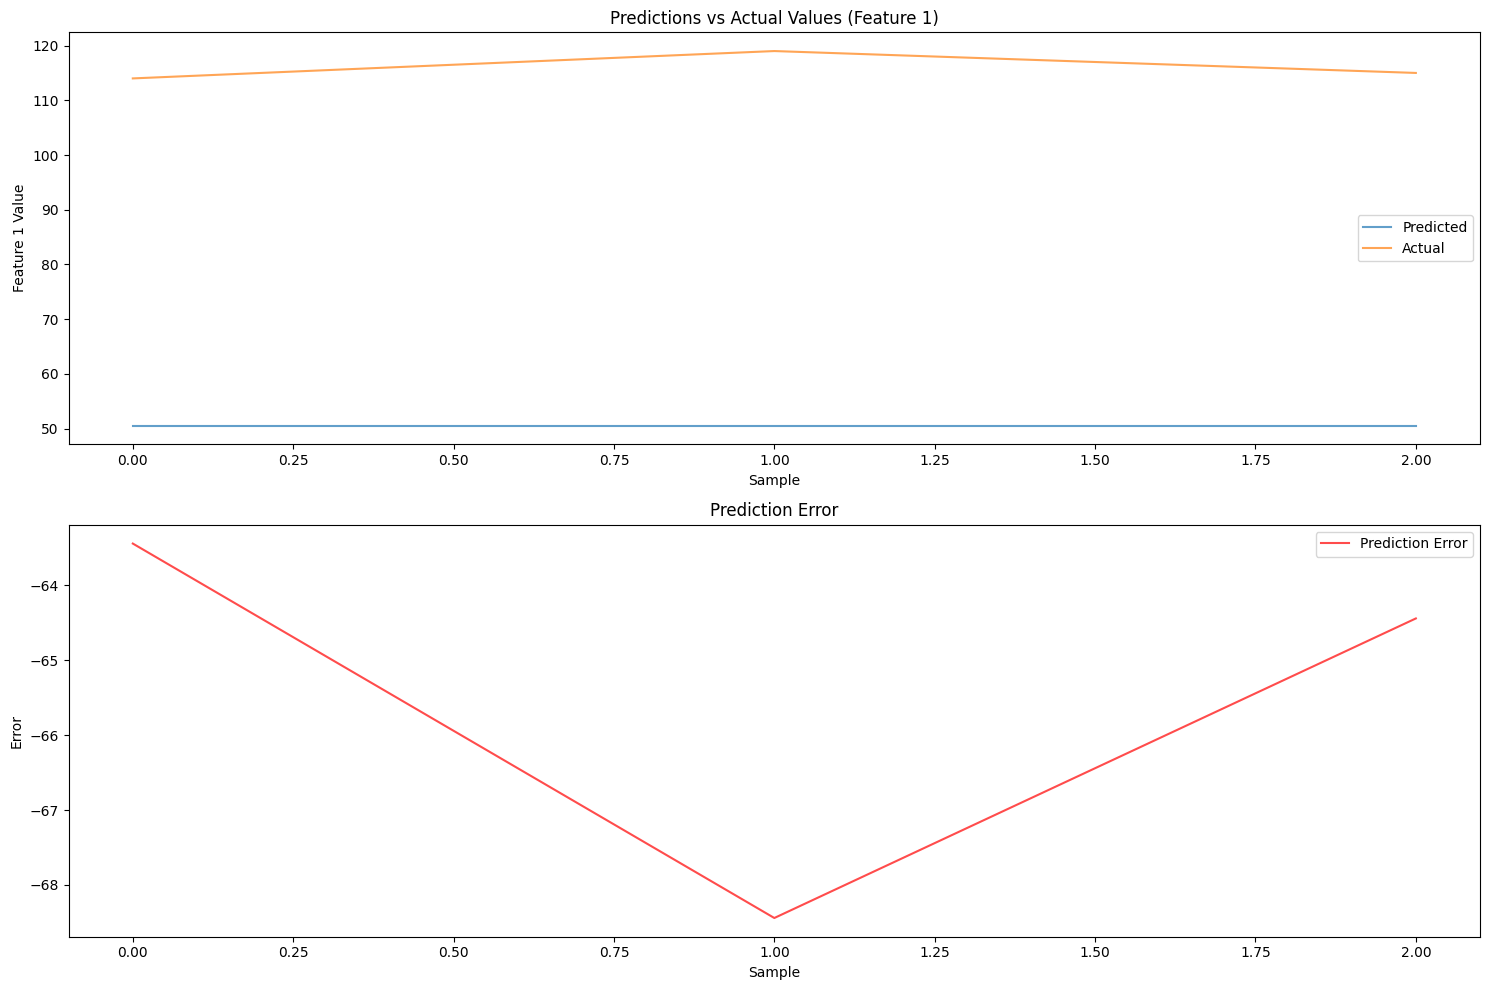

In [490]:
# Plot predictions vs actual values for the first feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot first few samples for visualization
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

ax1.plot(x, test_predictions[:num_samples_to_plot, 0, 0], label='Predicted', alpha=0.7)
ax1.plot(x, test_targets[:num_samples_to_plot, 0, 0], label='Actual', alpha=0.7)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Feature 1 Value")
ax1.set_title("Predictions vs Actual Values (Feature 1)")
ax1.legend()

# Plot prediction error
error = test_predictions[:num_samples_to_plot, 0, 0] - test_targets[:num_samples_to_plot, 0, 0]
ax2.plot(x, error, label='Prediction Error', color='red', alpha=0.7)
ax2.set_xlabel("Sample")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()
plt.tight_layout()

## Decision Tree Model
We will now train and test the Decision Tree model using the raw SMART data.

### Load the data to train the Decision Tree model

In [491]:
columns_to_delete += ['date', 'serial_number']

In [492]:
data = CT.importdata(ct_data_path, normalized_rows, raw_rows, columns_to_delete=columns_to_delete)


Processing CSV files: 100%|██████████| 361/361 [00:07<00:00, 47.66it/s]

Dataset Length:  28518
Dataset Shape:  (28518, 11)
Dataset:      failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0      True                82.0                84.0               100.0   
19     True                83.0                94.0               100.0   
53    False                80.0                90.0               100.0   
4     False                79.0                84.0               100.0   
55    False                72.0                91.0               100.0   

    smart_184_normalized  smart_187_normalized  smart_189_normalized  \
0                  100.0                 100.0                 100.0   
19                   0.0                  60.0                   0.0   
53                   0.0                 100.0                   0.0   
4                  100.0                 100.0                 100.0   
55                   0.0                 100.0                   0.0   

    smart_194_normalized  smart_195_normalized  smart_1

In [493]:

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)

c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


x_train (after SMOTE): [[100.         100.         100.         ...   0.         200.
   54.        ]
 [ 79.          90.         100.         ...   0.         200.
    0.        ]
 [100.          83.         100.         ...   0.         100.
    0.        ]
 ...
 [ 39.51964056  90.27996006  21.64047925 ...   1.         200.
    0.        ]
 [ 79.62055375  84.         100.         ...  22.24110749 200.
    0.        ]
 [100.         163.98889394 100.         ...   0.         200.
    0.        ]]
y_train (after SMOTE): True 16624 33248


In [494]:
# Grid search for best hyperparameters (Gini)
print("\nPerforming grid search for Decision Tree (Gini)...")
best_params, best_score = CT.grid_search_decision_tree(X_train_res, y_train_res)
depth = best_params['max_depth']
leaf = best_params['min_samples_leaf']


Performing grid search for Decision Tree (Gini)...
Best parameters from grid search: {'max_depth': 40, 'min_samples_leaf': 1}
Best cross-validated accuracy: 0.8134


### Train both decision tree models

In [495]:
print("\nTraining Decision Tree with Gini criterion...")
clf_gini = CT.train_using_gini(X_train_res, X_test, y_train_res, depth=depth, leaf=leaf)


Training Decision Tree with Gini criterion...


In [496]:
print("\nTraining Decision Tree with Entropy criterion...")
clf_entropy = CT.train_using_entropy(X_train_res, X_test, y_train_res, depth=depth, leaf=leaf)


Training Decision Tree with Entropy criterion...


### Test models

In [497]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)


Results Using Gini Index:
Predicted values:
[ True  True False ... False  True  True]


In [498]:
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")

Confusion Matrix:  [[6187  954]
 [ 550  865]]
Accuracy :  82.42169237961664
Report :                precision    recall  f1-score   support

       False       0.92      0.87      0.89      7141
        True       0.48      0.61      0.53      1415

    accuracy                           0.82      8556
   macro avg       0.70      0.74      0.71      8556
weighted avg       0.85      0.82      0.83      8556

FP:  954.0
FN:  550.0
TP:  865.0
TN:  6187.0
TPR:  0.6113074204946997
TNR:  0.866405265368996
PPV:  0.4755360087960418
NPV:  0.9183612884073029
FPR:  0.13359473463100405
FNR:  0.38869257950530034
FDR:  0.5244639912039583
ACC:  0.8242169237961664
❌ New gini model accuracy (0.8242) not better than previous best (0.9487)


In [499]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")


Results Using Gini Index:
Predicted values:
[ True  True False ... False  True  True]
Confusion Matrix:  [[6187  954]
 [ 550  865]]
Accuracy :  82.42169237961664
Report :                precision    recall  f1-score   support

       False       0.92      0.87      0.89      7141
        True       0.48      0.61      0.53      1415

    accuracy                           0.82      8556
   macro avg       0.70      0.74      0.71      8556
weighted avg       0.85      0.82      0.83      8556

FP:  954.0
FN:  550.0
TP:  865.0
TN:  6187.0
TPR:  0.6113074204946997
TNR:  0.866405265368996
PPV:  0.4755360087960418
NPV:  0.9183612884073029
FPR:  0.13359473463100405
FNR:  0.38869257950530034
FDR:  0.5244639912039583
ACC:  0.8242169237961664
❌ New gini model accuracy (0.8242) not better than previous best (0.9487)


In [500]:
print("\n" + "="*50)
print("Results Using Entropy:")
print("="*50)
y_pred_entropy = CT.prediction(X_test, clf_entropy)


Results Using Entropy:
Predicted values:
[ True False False ... False  True  True]


In [501]:
CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")

Confusion Matrix:  [[6176  965]
 [ 540  875]]
Accuracy :  82.41000467508182
Report :                precision    recall  f1-score   support

       False       0.92      0.86      0.89      7141
        True       0.48      0.62      0.54      1415

    accuracy                           0.82      8556
   macro avg       0.70      0.74      0.71      8556
weighted avg       0.85      0.82      0.83      8556

FP:  965.0
FN:  540.0
TP:  875.0
TN:  6176.0
TPR:  0.6183745583038869
TNR:  0.8648648648648649
PPV:  0.47554347826086957
NPV:  0.919594997022037
FPR:  0.13513513513513514
FNR:  0.38162544169611307
FDR:  0.5244565217391305
ACC:  0.8241000467508182
❌ New entropy model accuracy (0.8241) not better than previous best (0.9487)


0.8241000467508182

### Save models

In [502]:
# Directory to store models
dt_model_dir = "models/DT"
os.makedirs(dt_model_dir, exist_ok=True)

# Paths for Gini and Entropy models
gini_model_path = os.path.join(dt_model_dir, "dt_gini.joblib")
entropy_model_path = os.path.join(dt_model_dir, "dt_entropy.joblib")

# Helper function to load accuracy if model exists
def load_existing_accuracy(model_path):
    acc_path = model_path + ".acc"
    if os.path.exists(acc_path):
        with open(acc_path, "r") as f:
            return float(f.read().strip())
    return None

# Save model and accuracy
def save_model_and_accuracy(model, model_path, accuracy):
    joblib.dump(model, model_path)
    with open(model_path + ".acc", "w") as f:
        f.write(str(accuracy))

# Check and save Gini model if better
existing_gini_acc = load_existing_accuracy(gini_model_path)
if existing_gini_acc is None or gini_accuracy > existing_gini_acc:
    save_model_and_accuracy(clf_gini, gini_model_path, gini_accuracy)
    print(f"Saved improved Gini model with accuracy {gini_accuracy:.4f}")

# Check and save Entropy model if better
existing_entropy_acc = load_existing_accuracy(entropy_model_path)
entropy_accuracy = CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")
if existing_entropy_acc is None or entropy_accuracy > existing_entropy_acc:
    save_model_and_accuracy(clf_entropy, entropy_model_path, entropy_accuracy)
    print(f"Saved improved Entropy model with accuracy {entropy_accuracy:.4f}")

Confusion Matrix:  [[6176  965]
 [ 540  875]]
Accuracy :  82.41000467508182
Report :                precision    recall  f1-score   support

       False       0.92      0.86      0.89      7141
        True       0.48      0.62      0.54      1415

    accuracy                           0.82      8556
   macro avg       0.70      0.74      0.71      8556
weighted avg       0.85      0.82      0.83      8556

FP:  965.0
FN:  540.0
TP:  875.0
TN:  6176.0
TPR:  0.6183745583038869
TNR:  0.8648648648648649
PPV:  0.47554347826086957
NPV:  0.919594997022037
FPR:  0.13513513513513514
FNR:  0.38162544169611307
FDR:  0.5244565217391305
ACC:  0.8241000467508182
❌ New entropy model accuracy (0.8241) not better than previous best (0.9487)


### Visualize the results

In [503]:
smart_features = [f'smart_{i:03}' for i in range(1, 255)]

In [504]:
CT.plot_decision_tree(clf_gini, smart_features, ['No Failure', 'Failure'])

KeyboardInterrupt: 

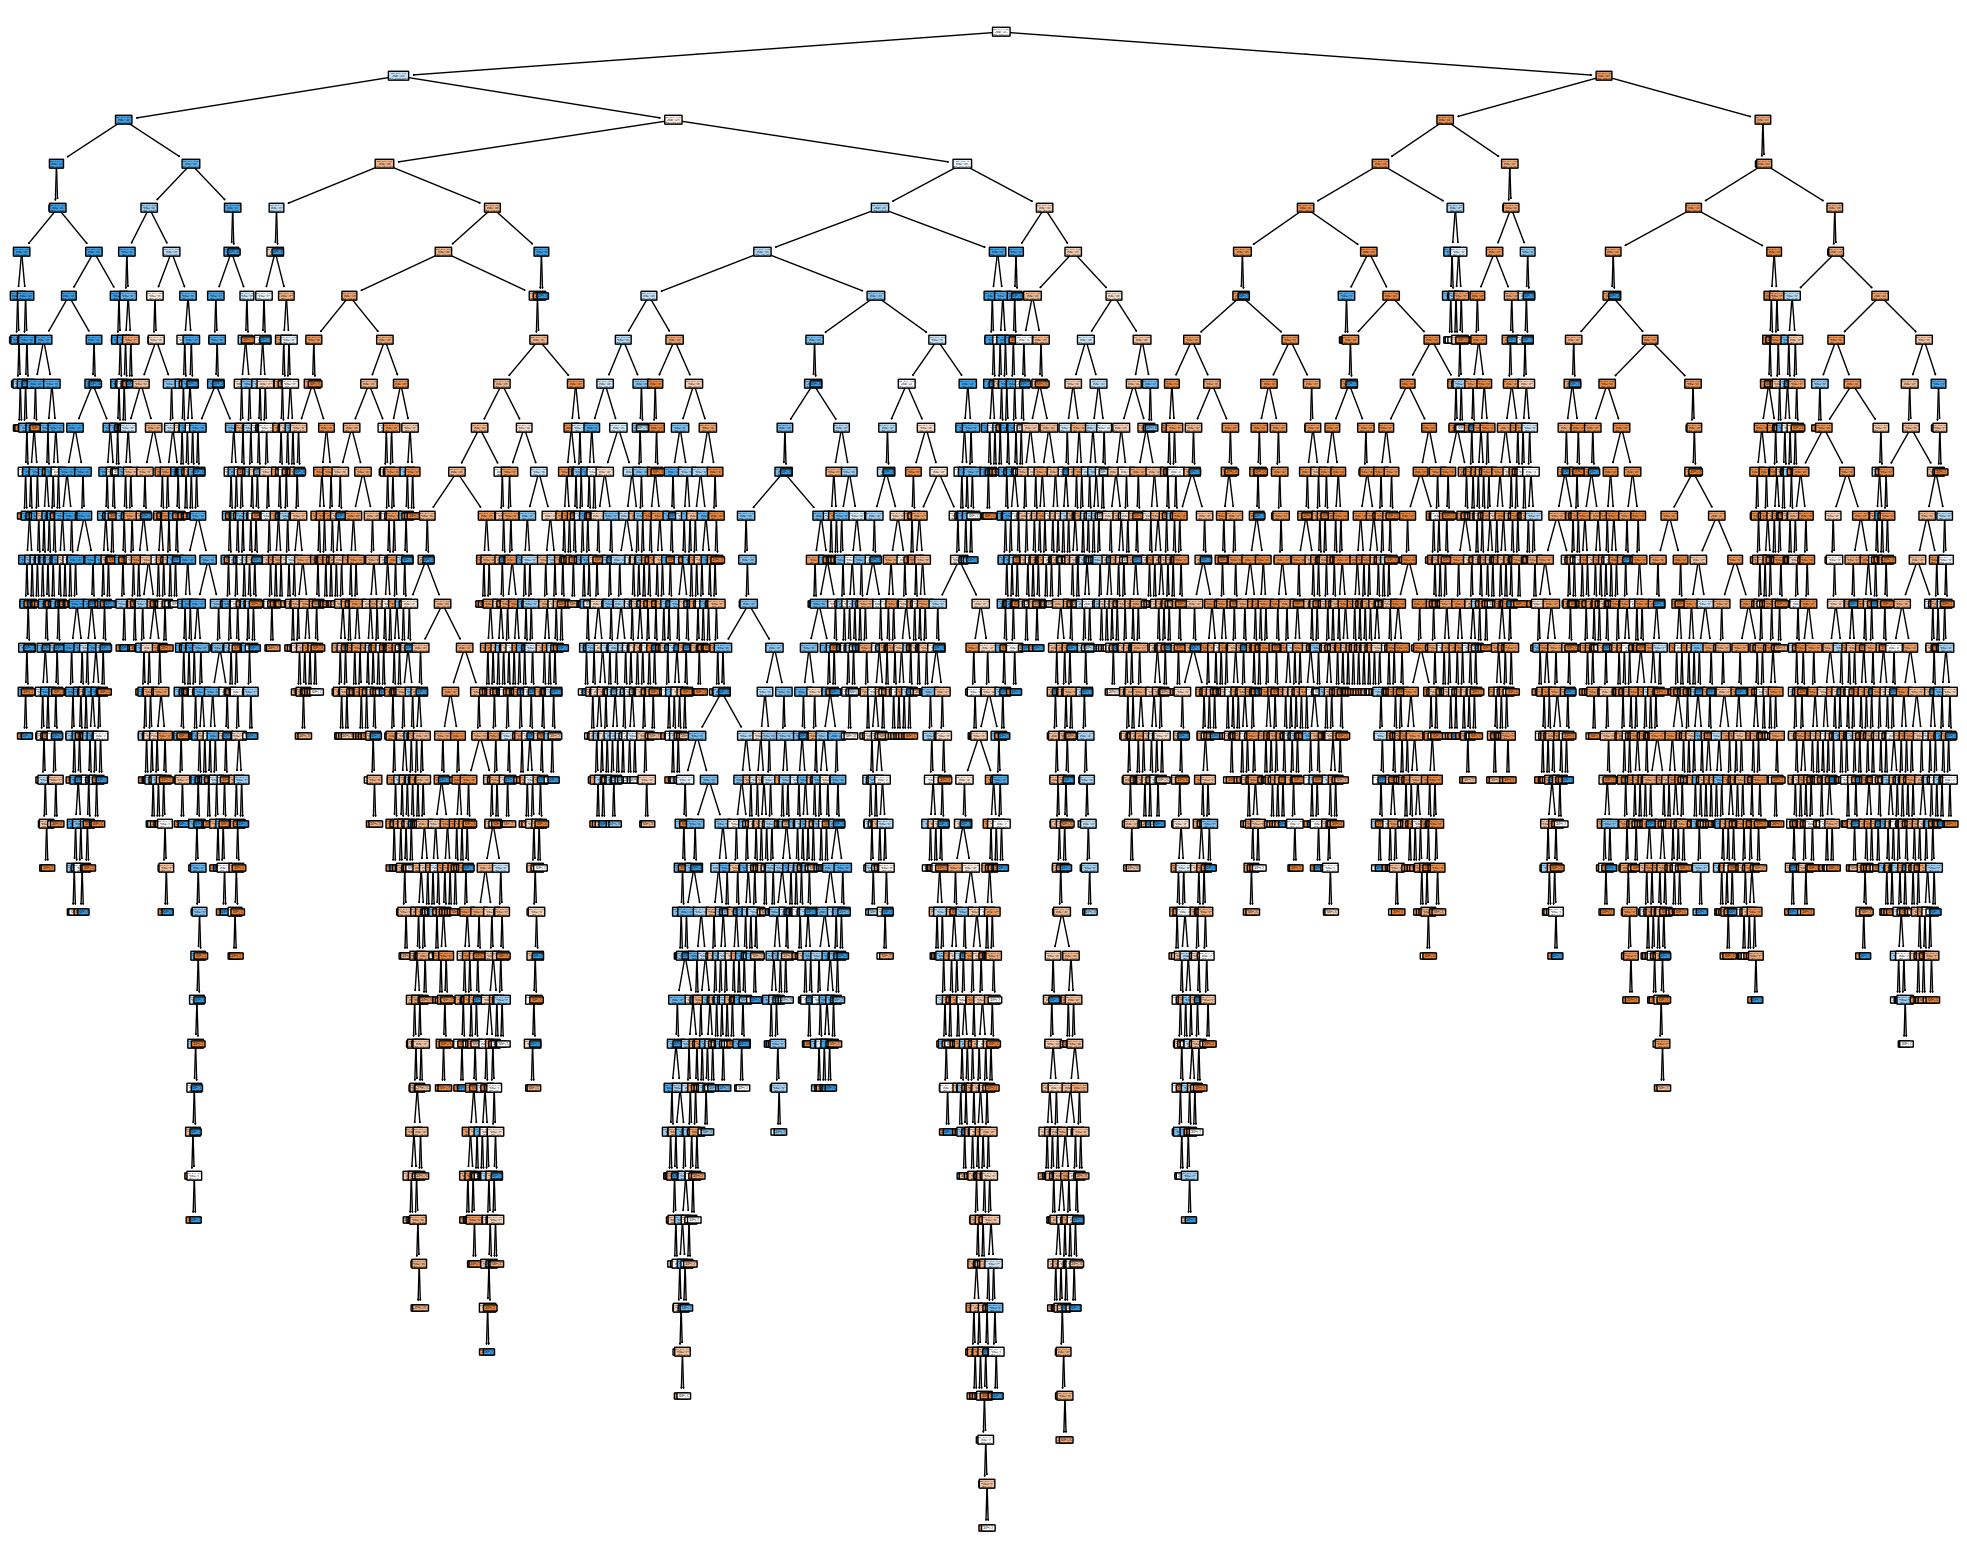

In [ ]:
CT.plot_decision_tree(clf_entropy, smart_features, ['No Failure', 'Failure'])

## Pipeline: LSTM + Decision Tree

In [505]:
path = "../data/a_test/processed_data"
verbose = True    # Create a single data loader that handles the train/test split properly
model_path = 'models/LSTM/lstm_model.pth'

We load all the data to choose randomly drives to generate predictions from

In [506]:
columns_to_delete = ['model', 'capacity_bytes', 'brand_HGST', 'brand_Hitachi', 'brand_SAMSUNG', 'brand_ST', 'brand_Seagate',
    'brand_TOSHIBA', 'brand_WD', 'brand_WDC', 'brand_WUH',
    'model_freq_Muy Bajo', 'model_freq_Bajo', 'model_freq_Medio',
    'model_freq_Alto', 'model_freq_Muy Alto',
    'Lin_capacity_bytes']

In [507]:
num_drives = 5
data_loader = smart.DriveDataLoader(root=path, 
                                train_ratio=0.01, # we are going to use only the testing data
                                min_sequence_length=min_sequence_length + 1,  # to have 1 day to test  
                                verbose=False, num_drives=num_drives,
                                columns_to_delete=columns_to_delete, normalized_rows=normalized_rows, raw_rows=raw_rows)

Loading CSV files: 100%|██████████| 361/361 [00:04<00:00, 75.13it/s]

[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_222_normalized']


In [508]:
selected_drives = data_loader.get_all_data()

print(f"Loaded {len(selected_drives)} days from the dataset from {num_drives} drives.")


Loaded 52 days from the dataset from 5 drives.


In [509]:
# Extract the last day for each drive and store in a DataFrame
last_days_df = selected_drives.groupby('serial_number').tail(1).reset_index(drop=True)
print(last_days_df)

         date   serial_number  failure  smart_1_normalized  \
0  2024-10-26  PL2331LAHD806J    False                 100   
1  2024-09-11        Z304XZKM    False                 110   
2  2024-09-11        Z305K21A    False                 117   
3  2024-08-12        Z305KVPX    False                 117   
4  2025-03-26        ZA10JCF9    False                  79   

   smart_3_normalized  smart_5_normalized  smart_184_normalized  \
0                 143                 100                     0   
1                  91                 100                   100   
2                  92                 100                   100   
3                  91                 100                   100   
4                  84                 100                   100   

   smart_187_normalized  smart_189_normalized  smart_194_normalized  \
0                     0                     0                   181   
1                   100                   100                    31   
2          

In [510]:
model_path = 'models/LSTM/lstm_model.pth'
model, model_metrics = smart.load_model(model_path, device, load_whole_model=True)

✅ Complete model loaded from models/LSTM/lstm_model.joblib
✅ Model metrics loaded from models/LSTM/lstm_model_metrics.json


In [511]:
model.eval()

Net(
  (lstm): LSTM(10, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=10, bias=True)
)

In [512]:
ct_feature_list = []
for row in normalized_rows:
    ct_feature_list.append(f'smart_{row}_normalized')
for row in raw_rows:
    ct_feature_list.append(f'smart_{row}_raw')
ct_feature_list += ['serial_number']
predicted_info = pd.DataFrame(columns=ct_feature_list)

predicted_info

,smart_187_normalized,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_195_normalized,smart_199_normalized,smart_194_normalized,smart_184_normalized,smart_189_normalized,smart_222_normalized,serial_number


In [513]:

for serial, drive_df in tqdm(selected_drives.groupby('serial_number'), desc="Processing drives"):
    # Prepare your input sequence for the LSTM
    features = drive_df.drop(columns=['serial_number', 'date', 'failure']).values
    # Keep only columns from normalized_rows and raw_rows
    cols_to_keep = [f"smart_{i}_normalized" for i in normalized_rows] + [f"smart_{i}_raw" for i in raw_rows]
    features = drive_df[cols_to_keep].values
    # Convert to tensor and add batch/sequence dimensions as needed, and use float64
    input_tensor = torch.tensor(features, dtype=torch.float64).unsqueeze(0)  # shape: [1, seq_len, features]
    # Run through model
    with torch.no_grad():
        prediction = model(input_tensor.to(device))
        last_day_pred = prediction[:, -1, :].cpu().numpy().flatten()
        # Map last_day_pred to ct_feature_list and append to predicted_info
        pred_row = dict(zip(ct_feature_list, last_day_pred))
        pred_row['serial_number'] = serial
        predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)

Processing drives:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Green\AppData\Local\Temp\ipykernel_26928\459539953.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)
Processing drives: 100%|██████████| 5/5 [00:00<00:00, 312.07it/s]C:\Users\Green\AppData\Local\Temp\ipykernel_26928\459539953.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_info = pd.concat([pre

In [514]:
print(predicted_info)

   smart_187_normalized  smart_1_normalized  smart_3_normalized  \
0             50.183099           41.174020           53.301712   
1             50.274135           41.286897           53.286659   
2             50.272801           41.285260           53.286861   
3             50.272788           41.285224           53.286885   
4             50.538810           41.615062           53.242904   

   smart_5_normalized  smart_195_normalized  smart_199_normalized  \
0           69.724479             63.198060             69.731634   
1           69.808314             63.286601             69.700488   
2           69.807049             63.285272             69.700890   
3           69.807080             63.285296             69.700958   
4           70.052072             63.544040             69.609965   

   smart_194_normalized  smart_184_normalized  smart_189_normalized  \
0              9.782611              0.490366             58.405597   
1              9.663915              0.5

In [515]:

clf_gini = load("models/DT/best_gini_tree.joblib")
clf_entropy = load("models/DT/best_entropy_tree.joblib")

In [516]:
serial_numbers = predicted_info['serial_number'].unique()

In [517]:
# Only use the feature columns for prediction to avoid warnings
feature_cols = []

# Add normalized columns
for row in normalized_rows:
    feature_cols.append(f'smart_{row}_normalized')

# Add raw columns  
for row in raw_rows:
    feature_cols.append(f'smart_{row}_raw')

print("Formatted feature columns:")
print(feature_cols)


Formatted feature columns:
['smart_187_normalized', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_195_normalized', 'smart_199_normalized', 'smart_194_normalized', 'smart_184_normalized', 'smart_189_normalized', 'smart_222_normalized']


In [518]:
ct_predictions = CT.prediction(predicted_info[feature_cols].values, clf_gini)

# Add predictions to the DataFrame
predicted_info['CT_Drive_Failed'] = ct_predictions
print(predicted_info)


Predicted values:
[ True  True  True  True  True]
   smart_187_normalized  smart_1_normalized  smart_3_normalized  \
0             50.183099           41.174020           53.301712   
1             50.274135           41.286897           53.286659   
2             50.272801           41.285260           53.286861   
3             50.272788           41.285224           53.286885   
4             50.538810           41.615062           53.242904   

   smart_5_normalized  smart_195_normalized  smart_199_normalized  \
0           69.724479             63.198060             69.731634   
1           69.808314             63.286601             69.700488   
2           69.807049             63.285272             69.700890   
3           69.807080             63.285296             69.700958   
4           70.052072             63.544040             69.609965   

   smart_194_normalized  smart_184_normalized  smart_189_normalized  \
0              9.782611              0.490366             58.

In [519]:

# Compare predicted failure with actual failure for each drive
last_days_df_sorted = last_days_df.set_index('serial_number').loc[serial_numbers].reset_index()
predicted_info['Actual_Failure'] = last_days_df_sorted['failure'].values

# Optionally, print a comparison summary
comparison = predicted_info[['CT_Drive_Failed', 'Actual_Failure']]
print("Prediction vs Actual Failure:\n", comparison)

print("accuracy:", (predicted_info['CT_Drive_Failed'] == predicted_info['Actual_Failure']).mean())



Prediction vs Actual Failure:
    CT_Drive_Failed  Actual_Failure
0             True           False
1             True           False
2             True           False
3             True           False
4             True           False
accuracy: 0.0
